In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.font_manager as fm
import os
from matplotlib import rcParams

# Font settings to prevent character encoding issues
plt.rcParams['axes.unicode_minus'] = False

# Result files to analyze
# result_files = [
#     "../results/python_react_gpt-4o-mini_test_50.json",
#     "../results/python_react_gpt-4o_test_50.json", 
#     "../results/sql_react_gpt-4o-mini_test_50.json", 
#     "../results/sql_react_gpt-4o_test_50.json"
# ]
result_files = [
    "../results/04-10-db_python_react_gpt-4o_mimic_mimic_100.json",
    "../results/04-10-db_sql_react_gpt-4o_mimic_mimic_100.json", 
]

# Load results from file
def load_results(file_path):
    with open(file_path, 'r') as f:
        results = json.load(f)
    return results

# Extract model and agent info from filename
def extract_model_info(file_path):
    filename = os.path.basename(file_path)
    parts = filename.split('_')
    
    # Extract agent type (python_react or sql_react)
    if 'python_react' in filename:
        agent_type = 'python_react'
    elif 'sql_react' in filename:
        agent_type = 'sql_react'
    else:
        agent_type = 'unknown'
    
    # Extract model type (gpt-4o-mini or gpt-4o)
    if 'gpt-4o-mini' in filename:
        model_type = 'gpt-4o-mini'
    elif 'gpt-4o' in filename and 'mini' not in filename:
        model_type = 'gpt-4o'
    else:
        model_type = 'unknown'
    
    return agent_type, model_type

# Create analysis dataframe
def create_analysis_df(results, file_path):
    # Extract model and agent info from file
    agent_type, model_type = extract_model_info(file_path)
    
    # Extract relevant info and metrics from each sample
    samples = []
    
    for item in results['evaluation_history']:
        sample_info = {
            'id': item.get('id'),
            'table_num': item.get('table_num'),
            'answer_type': item.get('answer_type'),
            'question': item.get('question'),
            'expected_answer': item.get('expected_answer'),
            'generated_answer': item.get('generated_answer'),
            'agent_type': agent_type,
            'model_type': model_type
        }
        
        # Add sample-specific metrics
        metrics = item.get('sample_metrics', {})
        sample_info['exact_match'] = metrics.get('exact_match', False)
        sample_info['normalized_match'] = metrics.get('normalized_match', False)
        sample_info['llm_match'] = metrics.get('llm_match', False)
        
        samples.append(sample_info)
    
    return pd.DataFrame(samples)

# Load all result files and create analysis dataframes
all_dfs = []
for file_path in result_files:
    try:
        results = load_results(file_path)
        df = create_analysis_df(results, file_path)
        all_dfs.append(df)
        print(f"Loaded '{file_path}': {len(df)} samples")
    except Exception as e:
        print(f"Failed to load '{file_path}': {str(e)}")

# Merge all dataframes
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"\nTotal {len(combined_df)} samples loaded")
else:
    print("No data loaded.")
    combined_df = pd.DataFrame()  # Create empty dataframe

# Only perform analysis if data is available
if not combined_df.empty:
    # Model and agent performance comparison
    print("\nModel and Agent Performance Comparison")
    model_agent_metrics = combined_df.groupby(['model_type', 'agent_type']).agg({
        'exact_match': 'mean',
        'normalized_match': 'mean',
        'llm_match': 'mean',
        'id': 'count'
    }).rename(columns={'id': 'count'})
    
    display(model_agent_metrics)
    
    # Visualize model and agent performance
    plt.figure(figsize=(14, 7))
    
    # Prepare data
    model_agent_pivot = pd.pivot_table(
        combined_df, 
        values='llm_match', 
        index='agent_type',
        columns='model_type', 
        aggfunc='mean'
    )

    combined_df['table_num'] = combined_df['table_num'].fillna(0)
    
    # Create bar chart
    ax = model_agent_pivot.plot(kind='bar', width=0.7)
    
    plt.title('Model and Agent Performance Comparison (llm_match)', fontsize=15)
    plt.xlabel('Agent Type', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Model', fontsize=12)
    
    # Show values on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze each model separately
    for model_type in combined_df['model_type'].unique():
        model_df = combined_df[combined_df['model_type'] == model_type]
        
        print(f"\n\n{'='*50}")
        print(f"Model: {model_type} Analysis Results (Sample count: {len(model_df)})")
        print(f"{'='*50}")
        
        # 1) Accuracy by difficulty (table_num)
        print("\n1. Accuracy by Difficulty (table_num)")
        
        # Analyze by agent type
        for agent_type in model_df['agent_type'].unique():
            agent_df = model_df[model_df['agent_type'] == agent_type]
            
            print(f"\nAgent: {agent_type}")
            table_metrics = agent_df.groupby('table_num').agg({
                'exact_match': 'mean',
                'normalized_match': 'mean',
                'llm_match': 'mean',
                'id': 'count'
            }).rename(columns={'id': 'count'})
            
            # Display results
            display(table_metrics)
            
            # Visualization
            plt.figure(figsize=(12, 6))
            table_metrics[['exact_match', 'normalized_match', 'llm_match']].plot(
                kind='bar', 
                title=f'{model_type} / {agent_type} - Accuracy by Difficulty (table_num)', 
                ylim=(0, 1),
            )
            plt.xlabel('Number of Tables (Difficulty)')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        
        # 2) Accuracy by answer type
        print("\n2. Accuracy and Correct Count by Answer Type")
        
        # Analyze by agent type
        for agent_type in model_df['agent_type'].unique():
            agent_df = model_df[model_df['agent_type'] == agent_type]
            
            print(f"\nAgent: {agent_type}")
            answer_type_metrics = agent_df.groupby('answer_type').agg({
                'exact_match': ['mean', 'sum'],
                'normalized_match': ['mean', 'sum'],
                'llm_match': ['mean', 'sum'],
                'id': 'count'
            })
            answer_type_metrics.columns = ['exact_match_accuracy', 'exact_match_count', 
                                         'normalized_match_accuracy', 'normalized_match_count',
                                         'llm_match_accuracy', 'llm_match_count', 'total_count']
            
            # Display results
            display(answer_type_metrics)
            
            # Visualization - Accuracy by answer type
            plt.figure(figsize=(14, 6))
            answer_type_accuracy = agent_df.groupby('answer_type').agg({
                'exact_match': 'mean',
                'normalized_match': 'mean',
                'llm_match': 'mean'
            })
            answer_type_accuracy.plot(
                kind='bar', 
                title=f'{model_type} / {agent_type} - Accuracy by Answer Type', 
                ylim=(0, 1)
            )
            plt.xlabel('Answer Type')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        
        # 3) Sample cases where llm_match and normalized_match disagree
        print("\n3. Cases where llm_match and normalized_match disagree")
        
        for agent_type in model_df['agent_type'].unique():
            agent_df = model_df[model_df['agent_type'] == agent_type]
            
            print(f"\nAgent: {agent_type}")
            mismatch_cases = agent_df[agent_df['llm_match'] != agent_df['normalized_match']]
            print(f"Number of mismatched cases: {len(mismatch_cases)}")
            
            if len(mismatch_cases) > 0:
                # Sample up to 5 cases
                sample_size = min(5, len(mismatch_cases))
                mismatch_samples = mismatch_cases.sample(sample_size, random_state=42)
                
                for i, (_, row) in enumerate(mismatch_samples.iterrows(), 1):
                    print(f"\nCase {i}:")
                    print(f"ID: {row['id']}")
                    print(f"Difficulty (table_num): {row['table_num']}")
                    print(f"Answer Type: {row['answer_type']}")
                    print(f"normalized_match: {row['normalized_match']}")
                    print(f"llm_match: {row['llm_match']}")
                    print(f"Question: {row['question']}")
                    print(f"Expected Answer: {row['expected_answer']}")
                    print(f"Generated Answer: {row['generated_answer']}")
            else:
                print("No mismatched cases found.")
        
        # 4) Sample cases where llm_match is incorrect
        print("\n4. Cases where llm_match is incorrect")
        
        for agent_type in model_df['agent_type'].unique():
            agent_df = model_df[model_df['agent_type'] == agent_type]
            
            print(f"\nAgent: {agent_type}")
            wrong_llm_cases = agent_df[agent_df['llm_match'] == False]
            print(f"Number of incorrect cases: {len(wrong_llm_cases)}")
            
            if len(wrong_llm_cases) > 0:
                # Sample up to 5 cases
                sample_size = min(5, len(wrong_llm_cases))
                wrong_samples = wrong_llm_cases.sample(sample_size, random_state=42)
                
                for i, (_, row) in enumerate(wrong_samples.iterrows(), 1):
                    print(f"\nCase {i}:")
                    print(f"ID: {row['id']}")
                    print(f"Difficulty (table_num): {row['table_num']}")
                    print(f"Answer Type: {row['answer_type']}")
                    print(f"exact_match: {row['exact_match']}")
                    print(f"normalized_match: {row['normalized_match']}")
                    print(f"Question: {row['question']}")
                    print(f"Expected Answer: {row['expected_answer']}")
                    print(f"Generated Answer: {row['generated_answer']}")
            else:
                print("No incorrect cases found.")
    
    # Additional analysis on combined data
    print("\n\nCombined Analysis for All Models and Agents")
    
    # Heatmap by model and agent type
    print("\nPerformance Comparison by Model and Agent Type (llm_match)")
    pivot_data = pd.pivot_table(
        combined_df, 
        values='llm_match', 
        index=['table_num', 'answer_type'],
        columns=['model_type', 'agent_type'], 
        aggfunc='mean',
        fill_value=0
    )
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(pivot_data, annot=True, cmap='Blues', vmin=0, vmax=1, fmt='.2f')
    plt.title('Performance Comparison by Model and Agent (llm_match)')
    plt.ylabel('Table Count and Answer Type')
    plt.xlabel('Model and Agent Type')
    plt.tight_layout()
    plt.show()
    
    # Error pattern analysis
    def analyze_error_patterns(df, model_type=None, agent_type=None):
        # Filter data
        filtered_df = df.copy()
        if model_type:
            filtered_df = filtered_df[filtered_df['model_type'] == model_type]
        if agent_type:
            filtered_df = filtered_df[filtered_df['agent_type'] == agent_type]
        
        # Filter for incorrect cases
        wrong_cases = filtered_df[filtered_df['llm_match'] == False]
        
        if len(wrong_cases) == 0:
            return "No incorrect cases found."
        
        # Error rate by answer type
        error_by_type = wrong_cases['answer_type'].value_counts() / filtered_df['answer_type'].value_counts()
        error_by_type = error_by_type.sort_values(ascending=False)
        
        return error_by_type
    
    print("\nError Pattern Analysis: Error Rate by Answer Type (All Models and Agents)")
    error_patterns = analyze_error_patterns(combined_df)
    print(error_patterns)
    
    # Visualize error rates
    if not isinstance(error_patterns, str):
        plt.figure(figsize=(10, 6))
        error_patterns.plot(kind='bar')
        plt.title('Error Rate by Answer Type (All Models and Agents)')
        plt.xlabel('Answer Type')
        plt.ylabel('Error Rate')
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()
    
    # Model performance comparison (box plot)
    plt.figure(figsize=(15, 7))
    box_data = []
    labels = []
    
    for model in combined_df['model_type'].unique():
        for agent in combined_df[combined_df['model_type'] == model]['agent_type'].unique():
            temp_df = combined_df[(combined_df['model_type'] == model) & 
                                (combined_df['agent_type'] == agent)]
            
            box_data.append(temp_df['llm_match'].values)
            labels.append(f"{model}\n{agent}")
    
    plt.boxplot(box_data, labels=labels)
    plt.title('Performance Distribution by Model and Agent (llm_match)', fontsize=15)
    plt.ylabel('Accuracy (llm_match)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(-0.1, 1.1)
    
    # Set y-axis ticks
    plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for analysis. Please check file paths.")

In [6]:

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

# Function to load data - Save and load provided JSON data
def load_data(json_string=None, file_path=None):
    """
    Load data from JSON string or file.
    json_string: JSON formatted string
    file_path: JSON file path
    """
    if json_string:
        # Save JSON string to a temporary file
        with open('temp_data.json', 'w', encoding='utf-8') as f:
            f.write(json_string)
        file_path = 'temp_data.json'
    
    # Load data from file
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    return data

# Function to convert data to DataFrame
def create_dataframe(data):
    """
    Extract necessary information from experiment data and convert to pandas DataFrame.
    """
    records = []
    
    for entry in data['evaluation_history']:
        record = {
            'id': entry['id'],
            'answer_type': entry['answer_type'],
            'table_num': entry['table_num'],
            'question': entry['question'],
            'expected_answer': entry['expected_answer'],
            'generated_answer': entry['generated_answer'],
            'total_turns': entry['total_turns'],
            'exact_match': entry.get('sample_metrics', {}).get('exact_match', False),
            'normalized_match': entry.get('sample_metrics', {}).get('normalized_match', False),
            'llm_match': entry.get('sample_metrics', {}).get('llm_match', False),
            'is_unanswerable': entry['generated_answer'] == 'Unanswerable'
        }
        
        # Add token usage information
        if 'token_usages' in entry:
            total_prompt_tokens = sum(usage.get('prompt_tokens', 0) for usage in entry['token_usages'])
            total_completion_tokens = sum(usage.get('completion_tokens', 0) for usage in entry['token_usages'])
            total_tokens = sum(usage.get('total_tokens', 0) for usage in entry['token_usages'])
            
            record['total_prompt_tokens'] = total_prompt_tokens
            record['total_completion_tokens'] = total_completion_tokens
            record['total_tokens'] = total_tokens
            record['turns_count'] = len(entry['token_usages'])
        
        records.append(record)
    
    return pd.DataFrame(records)

# Function to analyze SQL query complexity
def analyze_query_complexity(data):
    """
    Analyze the complexity of gold SQL queries.
    """
    complexity_metrics = []
    
    for entry in data['evaluation_history']:
        query = entry.get('gold_sql_query', '')
        
        # Calculate complexity metrics
        metrics = {
            'id': entry['id'],
            'table_count': entry['table_num'],
            'query_length': len(query),
            'select_count': query.lower().count('select'),
            'join_count': query.lower().count('join'),
            'where_count': query.lower().count('where'),
            'group_by_count': query.lower().count('group by'),
            'order_by_count': query.lower().count('order by'),
            'having_count': query.lower().count('having'),
            'union_count': query.lower().count('union'),
            'subquery_count': query.count('('),
            'llm_match': entry.get('sample_metrics', {}).get('llm_match', False)
        }
        
        complexity_metrics.append(metrics)
    
    return pd.DataFrame(complexity_metrics)

=== Basic Statistical Analysis ===
Total samples: 100
Exact match rate: 0.37
Normalized match rate: 0.46
LLM match rate: 0.46
'Unanswerable' response rate: 0.35


=== Performance by Answer Type ===
             exact_match  normalized_match  llm_match  is_unanswerable  count
answer_type                                                                  
                    0.37              0.46       0.46             0.35    100


=== Performance by Number of Tables ===
           exact_match  normalized_match  llm_match  is_unanswerable  count
table_num                                                                  
                  0.37              0.46       0.46             0.35    100


=== Performance by Number of Dialog Turns ===
             exact_match  normalized_match  llm_match  is_unanswerable  count
total_turns                                                                  
3               0.000000          0.000000   0.000000         1.000000      1
4               

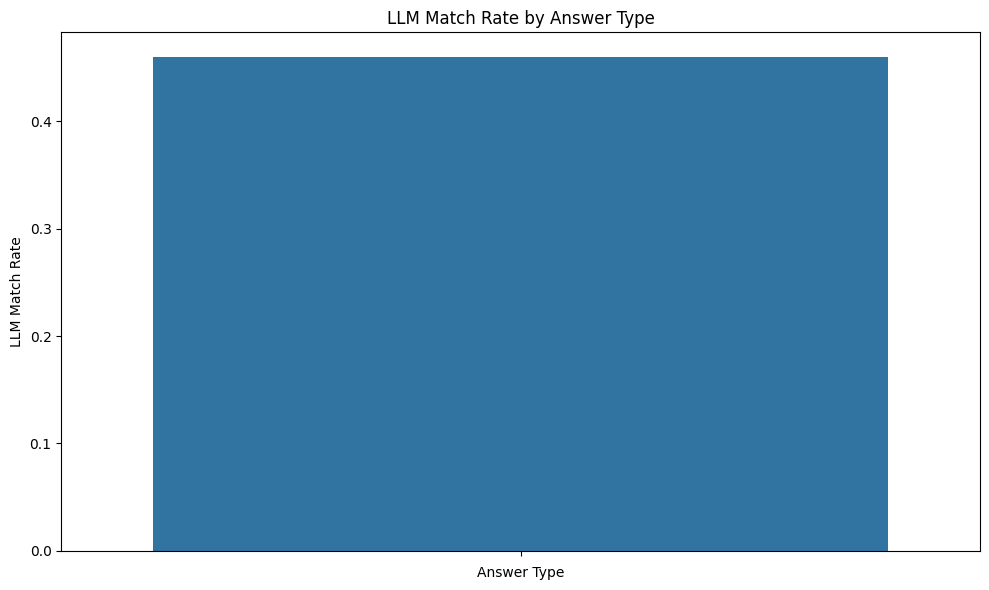

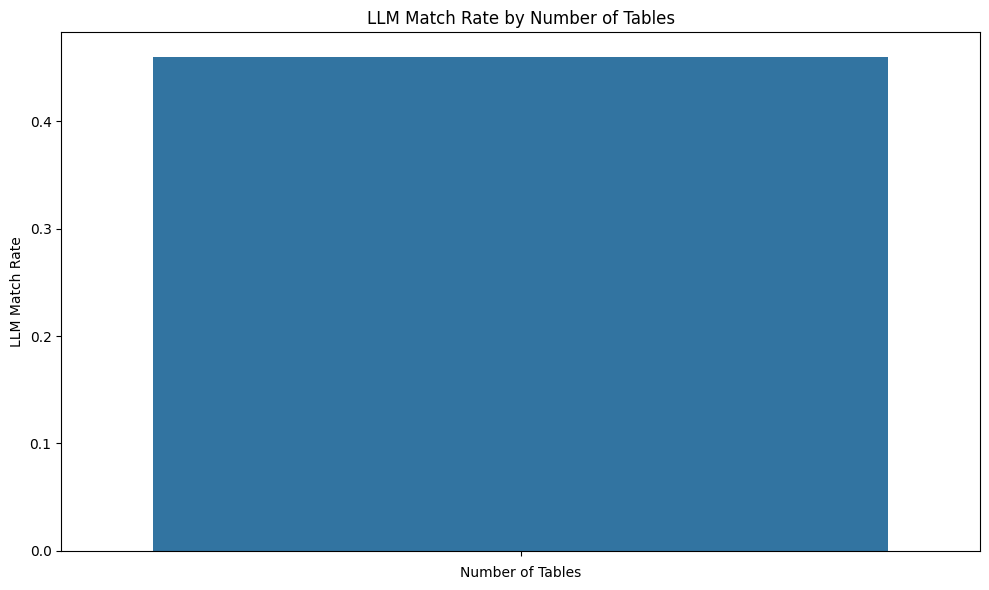

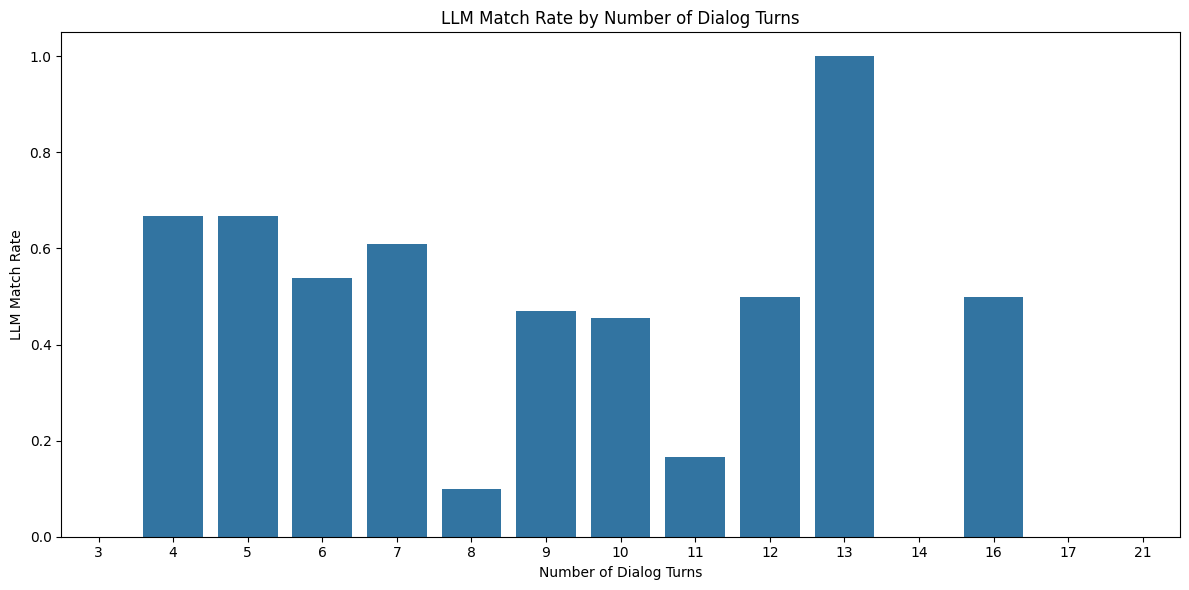

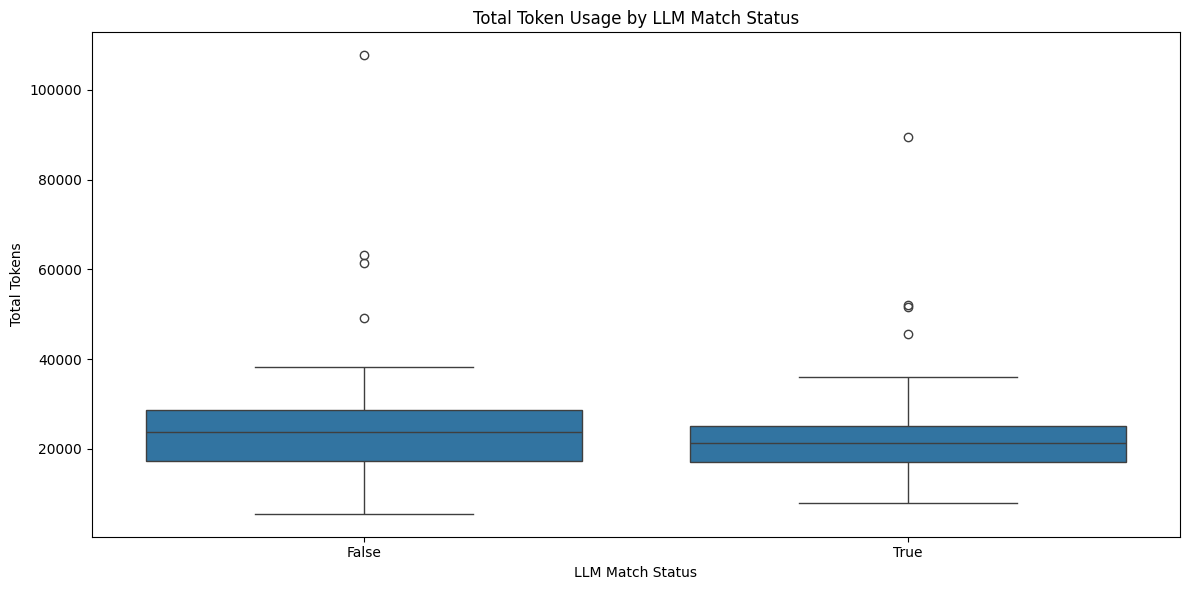

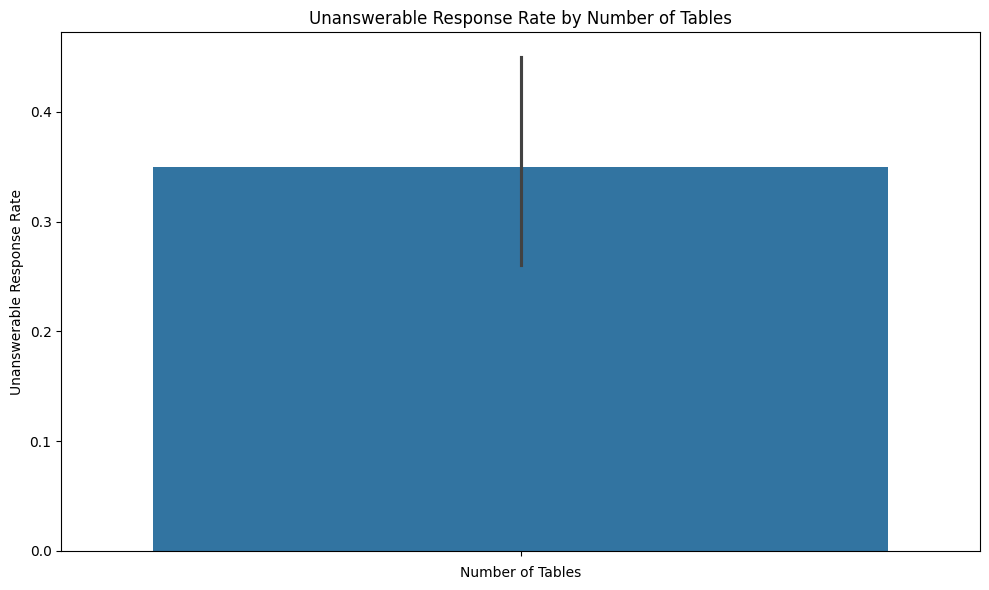

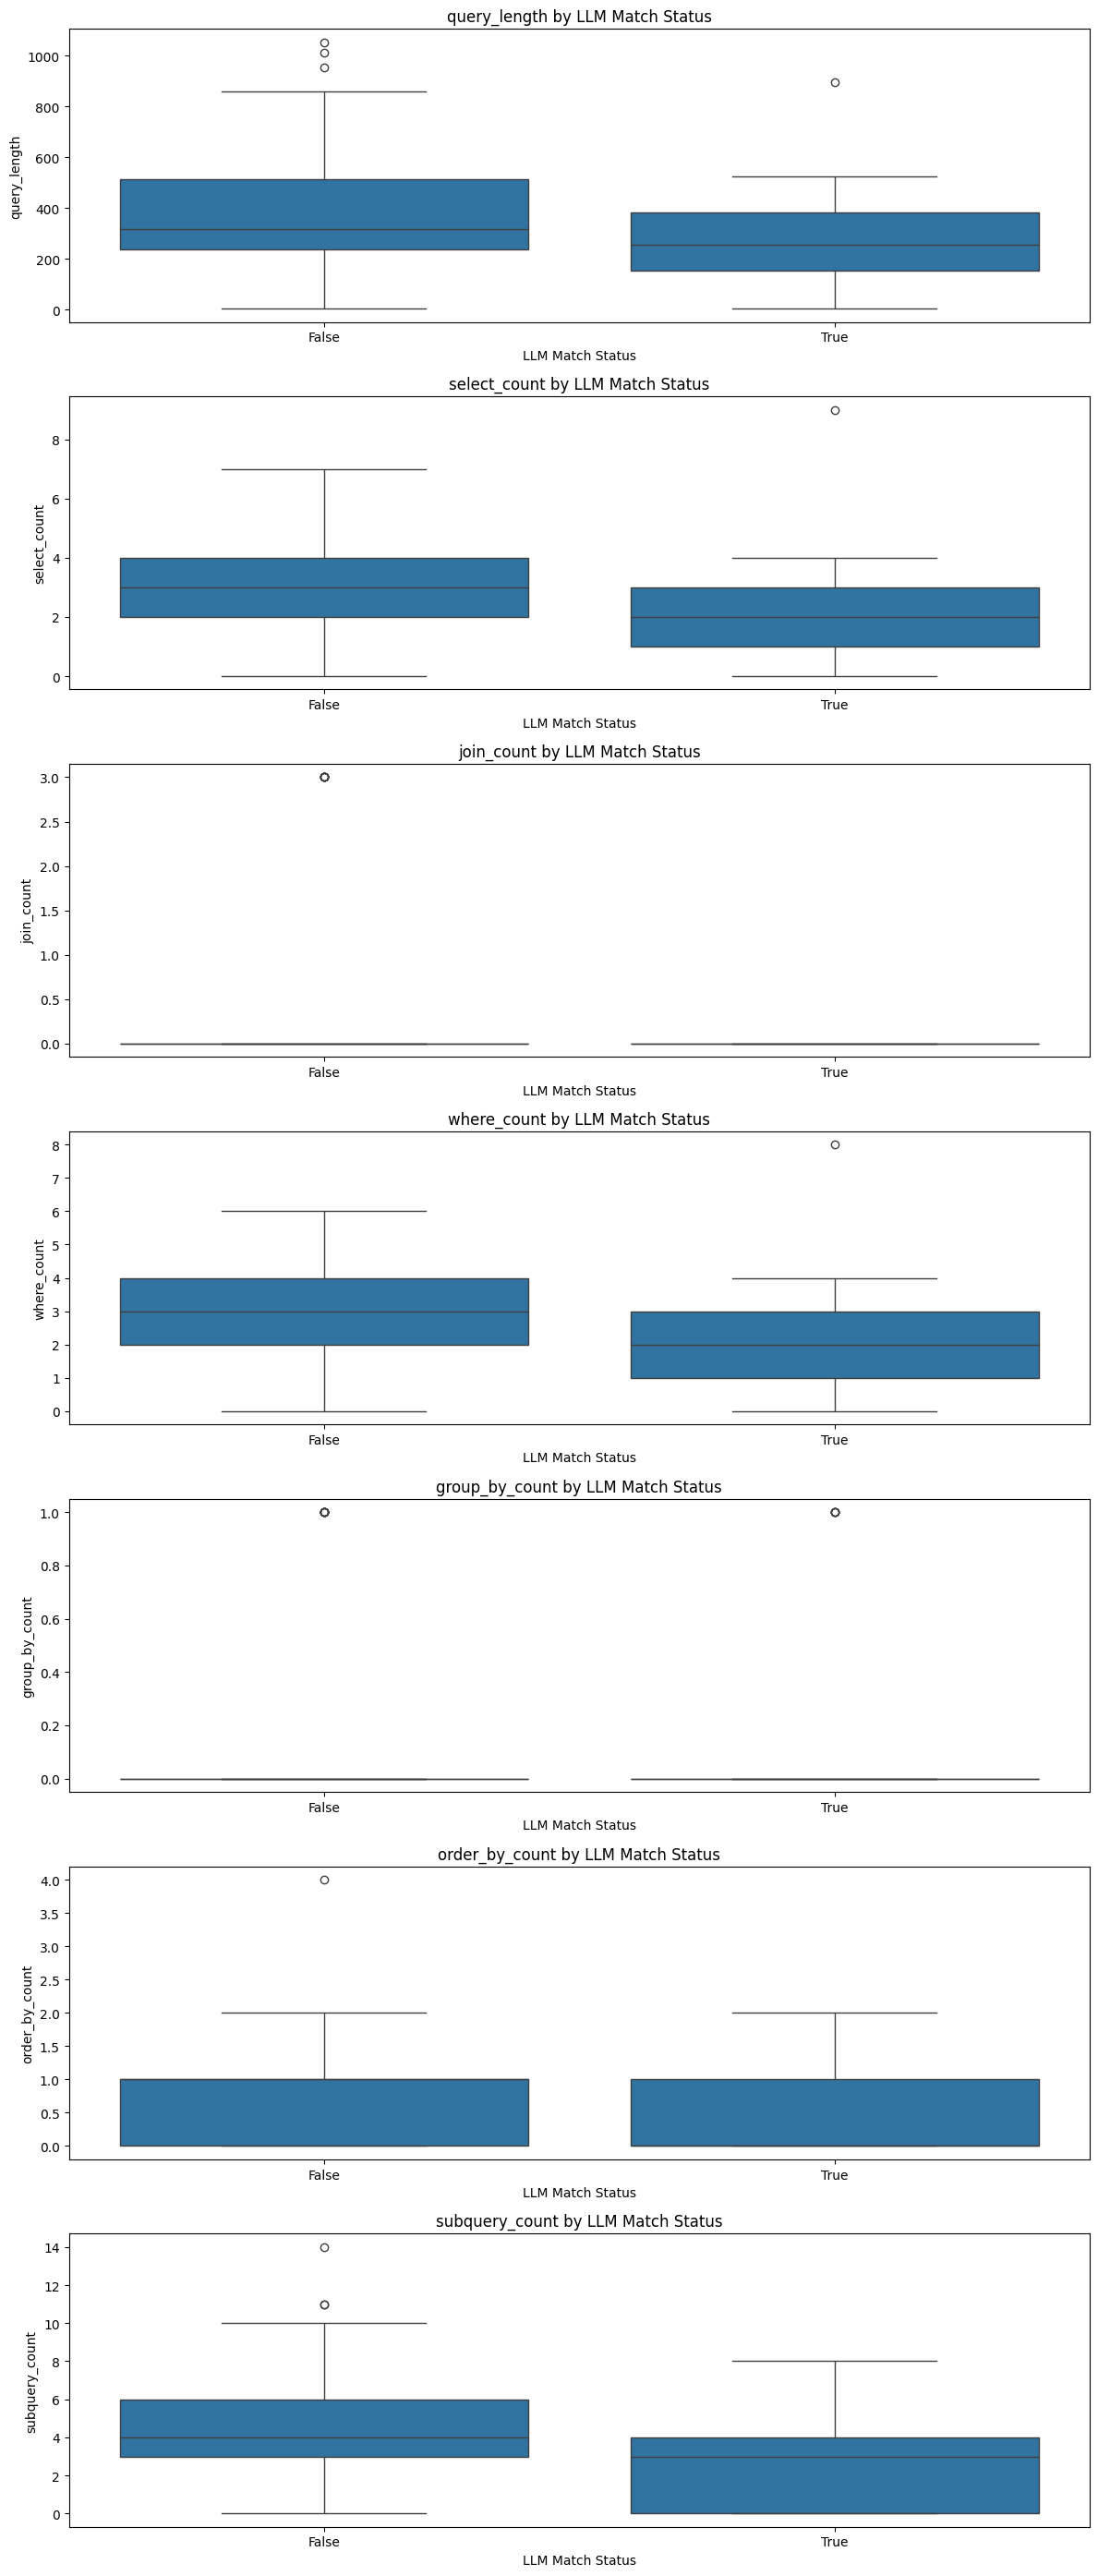

=== Comparison of Successful and Failed Cases ===
Number of successful cases: 46
Number of failed cases: 54


Average dialog turns for successful cases: 7.87
Average dialog turns for failed cases: 8.81


Average token usage for successful cases: 23620.41
Average token usage for failed cases: 25838.13


Table number distribution for successful cases:
table_num
    1.0
Name: proportion, dtype: float64

Table number distribution for failed cases:
table_num
    1.0
Name: proportion, dtype: float64


Answer type distribution for successful cases:
answer_type
    1.0
Name: proportion, dtype: float64

Answer type distribution for failed cases:
answer_type
    1.0
Name: proportion, dtype: float64


=== Analysis of 'Unanswerable' Responses ===
Number of 'Unanswerable' response cases: 35
LLM match rate among 'Unanswerable' responses: 0.20


Table number distribution for 'Unanswerable' responses:
table_num
    1.0
Name: proportion, dtype: float64


Answer type distribution for 'Unanswerable' resp

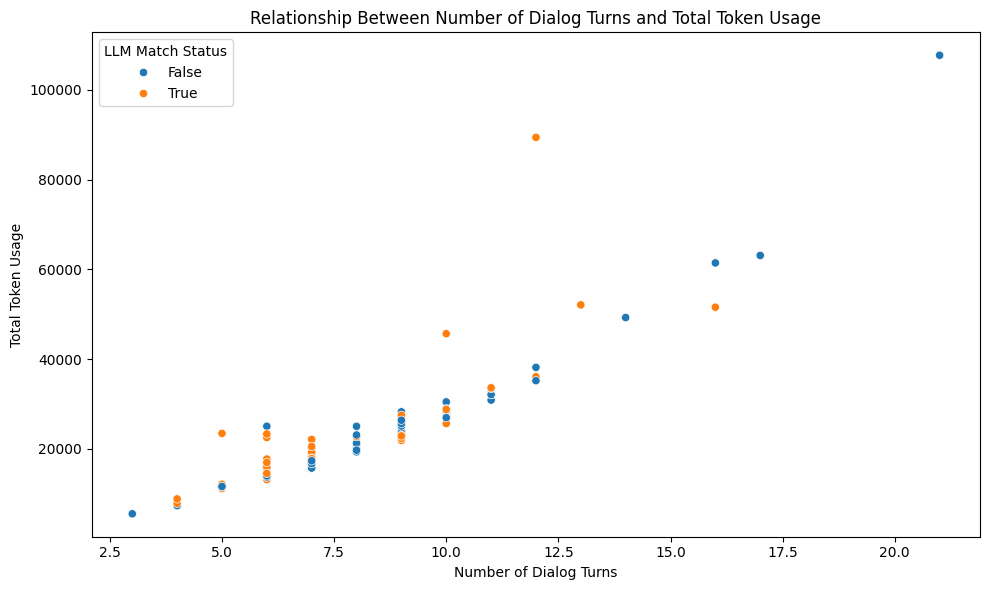

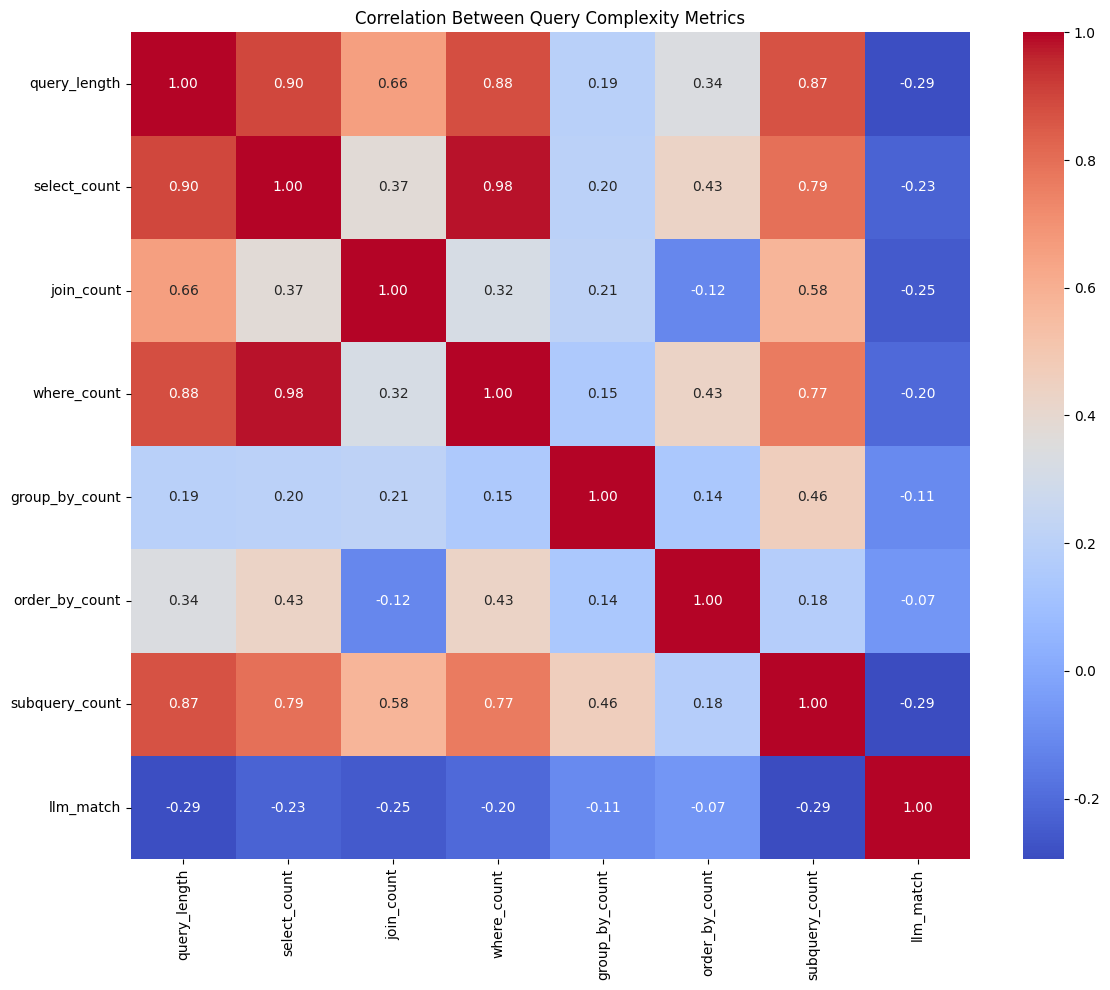

=== Conclusion and Summary ===
1. Overall LLM match rate is 46.00%.


TypeError: unsupported type: <class 'pandas.core.indexes.base.Index'>

In [8]:
result_files = [
    "../results/04-10-db_python_react_gpt-4o_mimic_mimic_100.json",
    "../results/04-10-db_sql_react_gpt-4o_mimic_mimic_100.json", 
]


# 1. 데이터 로드 및 준비
# 아래 코드에서는 위에서 제공된 JSON 문자열이 변수에 저장되어 있다고 가정합니다.
# 실제 사용 시 파일 경로를 지정하여 load_data 함수를 호출하세요.
# data = load_data(file_path='path/to/your/file.json')

# 예시: 데이터 파일을 불러옵니다.
# 실제 사용 시에는 파일 경로를 지정하세요.

data = load_data(file_path='../results/04-10-db_python_react_gpt-4o_mimic_mimic_100.json')  # 또는 load_data(json_string=your_json_string)


# Create DataFrame
df = create_dataframe(data)
complexity_df = analyze_query_complexity(data)

# 2. Basic statistical analysis
print("=== Basic Statistical Analysis ===")
print(f"Total samples: {len(df)}")
print(f"Exact match rate: {df['exact_match'].mean():.2f}")
print(f"Normalized match rate: {df['normalized_match'].mean():.2f}")
print(f"LLM match rate: {df['llm_match'].mean():.2f}")
print(f"'Unanswerable' response rate: {df['is_unanswerable'].mean():.2f}")
print("\n")

# 3. Performance analysis by answer type
answer_type_performance = df.groupby('answer_type').agg({
    'exact_match': 'mean',
    'normalized_match': 'mean',
    'llm_match': 'mean',
    'is_unanswerable': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'})

print("=== Performance by Answer Type ===")
print(answer_type_performance)
print("\n")

# 4. Performance analysis by number of tables
table_num_performance = df.groupby('table_num').agg({
    'exact_match': 'mean',
    'normalized_match': 'mean',
    'llm_match': 'mean',
    'is_unanswerable': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'})

print("=== Performance by Number of Tables ===")
print(table_num_performance)
print("\n")

# 5. Analysis of relationship between dialog turns and performance
turns_performance = df.groupby('total_turns').agg({
    'exact_match': 'mean',
    'normalized_match': 'mean',
    'llm_match': 'mean',
    'is_unanswerable': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'})

print("=== Performance by Number of Dialog Turns ===")
print(turns_performance)
print("\n")

# 6. Visualization

# 6.1 LLM match rate by answer type
plt.figure(figsize=(10, 6))
sns.barplot(x=answer_type_performance.index, y=answer_type_performance['llm_match'])
plt.title('LLM Match Rate by Answer Type')
plt.xlabel('Answer Type')
plt.ylabel('LLM Match Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6.2 LLM match rate by number of tables
plt.figure(figsize=(10, 6))
sns.barplot(x=table_num_performance.index, y=table_num_performance['llm_match'])
plt.title('LLM Match Rate by Number of Tables')
plt.xlabel('Number of Tables')
plt.ylabel('LLM Match Rate')
plt.tight_layout()
plt.show()

# 6.3 LLM match rate by number of dialog turns
plt.figure(figsize=(12, 6))
sns.barplot(x=turns_performance.index, y=turns_performance['llm_match'])
plt.title('LLM Match Rate by Number of Dialog Turns')
plt.xlabel('Number of Dialog Turns')
plt.ylabel('LLM Match Rate')
plt.tight_layout()
plt.show()

# 6.4 Total token usage by LLM match status
plt.figure(figsize=(12, 6))
sns.boxplot(x='llm_match', y='total_tokens', data=df)
plt.title('Total Token Usage by LLM Match Status')
plt.xlabel('LLM Match Status')
plt.ylabel('Total Tokens')
plt.tight_layout()
plt.show()

# 6.5 Relationship between number of tables and unanswerable responses
plt.figure(figsize=(10, 6))
sns.barplot(x='table_num', y='is_unanswerable', data=df)
plt.title('Unanswerable Response Rate by Number of Tables')
plt.xlabel('Number of Tables')
plt.ylabel('Unanswerable Response Rate')
plt.tight_layout()
plt.show()

# 6.6 Relationship between query complexity metrics and LLM match
complexity_metrics = ['query_length', 'select_count', 'join_count', 'where_count', 
                     'group_by_count', 'order_by_count', 'subquery_count']

fig, axes = plt.subplots(nrows=len(complexity_metrics), figsize=(12, 4*len(complexity_metrics)))

for i, metric in enumerate(complexity_metrics):
    sns.boxplot(x='llm_match', y=metric, data=complexity_df, ax=axes[i])
    axes[i].set_title(f'{metric} by LLM Match Status')
    axes[i].set_xlabel('LLM Match Status')
    axes[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

# 7. Comparison of successful and failed cases
successful_cases = df[df['llm_match'] == True]
failed_cases = df[df['llm_match'] == False]

print("=== Comparison of Successful and Failed Cases ===")
print(f"Number of successful cases: {len(successful_cases)}")
print(f"Number of failed cases: {len(failed_cases)}")
print("\n")

# 7.1 Comparison of average dialog turns
print(f"Average dialog turns for successful cases: {successful_cases['total_turns'].mean():.2f}")
print(f"Average dialog turns for failed cases: {failed_cases['total_turns'].mean():.2f}")
print("\n")

# 7.2 Comparison of average token usage
print(f"Average token usage for successful cases: {successful_cases['total_tokens'].mean():.2f}")
print(f"Average token usage for failed cases: {failed_cases['total_tokens'].mean():.2f}")
print("\n")

# 7.3 Comparison of table number distribution
print("Table number distribution for successful cases:")
print(successful_cases['table_num'].value_counts(normalize=True))
print("\nTable number distribution for failed cases:")
print(failed_cases['table_num'].value_counts(normalize=True))
print("\n")

# 7.4 Comparison of answer type distribution
print("Answer type distribution for successful cases:")
print(successful_cases['answer_type'].value_counts(normalize=True))
print("\nAnswer type distribution for failed cases:")
print(failed_cases['answer_type'].value_counts(normalize=True))
print("\n")

# 8. Analysis of unanswerable responses
unanswerable_cases = df[df['is_unanswerable'] == True]

print("=== Analysis of 'Unanswerable' Responses ===")
print(f"Number of 'Unanswerable' response cases: {len(unanswerable_cases)}")
print(f"LLM match rate among 'Unanswerable' responses: {unanswerable_cases['llm_match'].mean():.2f}")
print("\n")

# 8.1 Table number distribution for unanswerable responses
print("Table number distribution for 'Unanswerable' responses:")
print(unanswerable_cases['table_num'].value_counts(normalize=True))
print("\n")

# 8.2 Answer type distribution for unanswerable responses
print("Answer type distribution for 'Unanswerable' responses:")
print(unanswerable_cases['answer_type'].value_counts(normalize=True))
print("\n")

# 9. Question keyword analysis
def extract_keywords(text):
    # Simple keyword extraction function (example)
    # In reality, more complex NLP techniques could be used
    words = re.findall(r'\b\w+\b', text.lower())
    stop_words = {'the', 'is', 'and', 'of', 'in', 'to', 'a', 'for', 'has', 'been', 'what', 'how', 'many', 'times', 'did'}
    keywords = [word for word in words if word not in stop_words and len(word) > 2]
    return keywords

# Comparison of question keywords for successful and failed cases
successful_keywords = []
for question in successful_cases['question']:
    successful_keywords.extend(extract_keywords(question))

failed_keywords = []
for question in failed_cases['question']:
    failed_keywords.extend(extract_keywords(question))

successful_keyword_counter = Counter(successful_keywords)
failed_keyword_counter = Counter(failed_keywords)

print("=== Question Keyword Analysis ===")
print("Top keywords for successful cases:")
print(successful_keyword_counter.most_common(10))
print("\nTop keywords for failed cases:")
print(failed_keyword_counter.most_common(10))
print("\n")

# 10. Relationship between token usage and number of turns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_turns', y='total_tokens', hue='llm_match', data=df)
plt.title('Relationship Between Number of Dialog Turns and Total Token Usage')
plt.xlabel('Number of Dialog Turns')
plt.ylabel('Total Token Usage')
plt.legend(title='LLM Match Status')
plt.tight_layout()
plt.show()

# 11. Correlation between query complexity metrics
plt.figure(figsize=(12, 10))
correlation = complexity_df[complexity_metrics + ['llm_match']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Query Complexity Metrics')
plt.tight_layout()
plt.show()

# 12. Conclusion and summary
print("=== Conclusion and Summary ===")
print("1. Overall LLM match rate is {:.2f}%.".format(df['llm_match'].mean() * 100))
print("2. Performance difference by number of tables: {}".format(
    "Performance tends to decrease as the number of tables increases." if table_num_performance['llm_match'].corr(table_num_performance.index) < 0 
    else "No clear correlation between number of tables and performance."))
print("3. Relationship between dialog turns and performance: {}".format(
    "Performance tends to decrease as the number of dialog turns increases." if df['total_turns'].corr(df['llm_match']) < 0
    else "Performance tends to improve as the number of dialog turns increases." if df['total_turns'].corr(df['llm_match']) > 0
    else "No clear correlation between number of dialog turns and performance."))
print("4. Performance difference by answer type: {} type shows higher performance.".format(
    answer_type_performance['llm_match'].idxmax() if len(answer_type_performance) > 1 else "Only one answer type exists."))
print("5. 'Unanswerable' responses account for {:.2f}% of the total, with an LLM match rate of {:.2f}%.".format(
    df['is_unanswerable'].mean() * 100, 
    unanswerable_cases['llm_match'].mean() * 100 if len(unanswerable_cases) > 0 else 0))


Data loaded successfully.

=== Overall Performance Comparison ===
              exact_match  normalized_match  llm_match  is_unanswerable  \
agent_type                                                                
python_react         0.37              0.46       0.46             0.35   
sql_react            0.37              0.51       0.46             0.19   

              total_turns  total_tokens  count  
agent_type                                      
python_react         8.38      24817.98    100  
sql_react            7.59      18069.77    100  


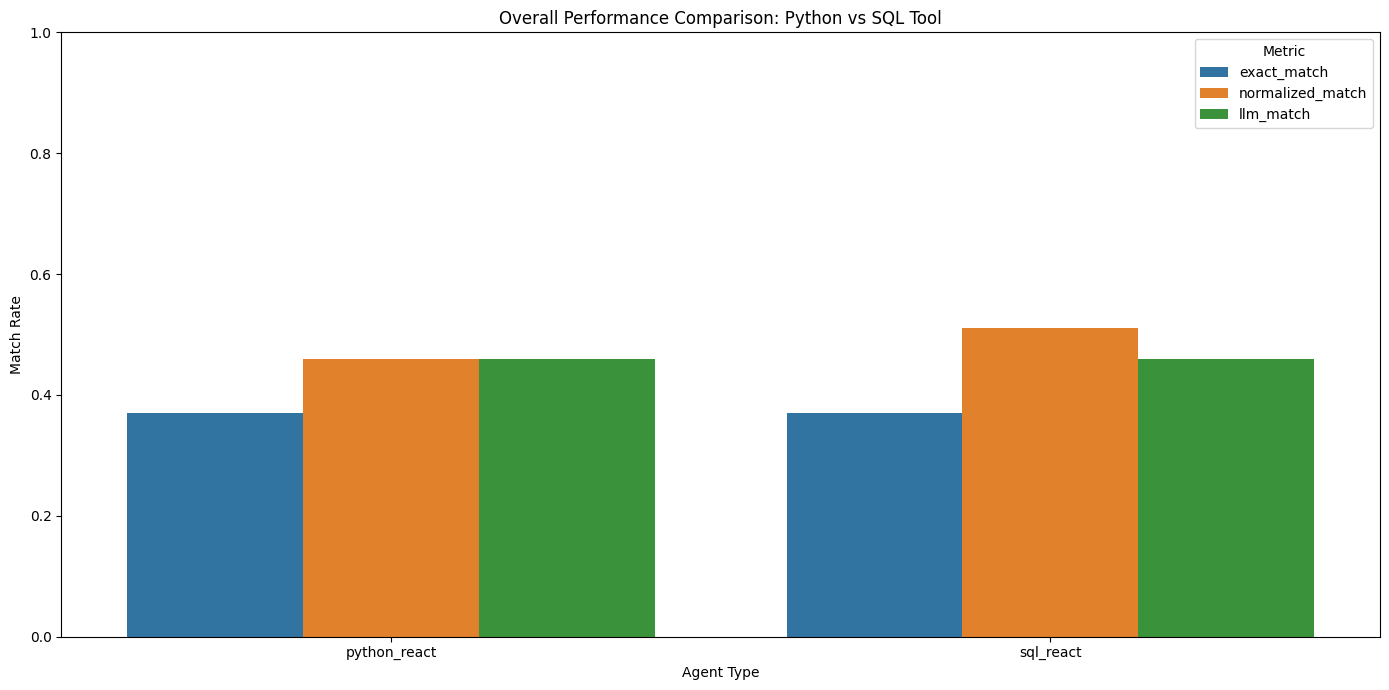


=== Performance by Answer Type ===
     agent_type answer_type  llm_match  count
0  python_react                   0.46    100
1     sql_react                   0.46    100


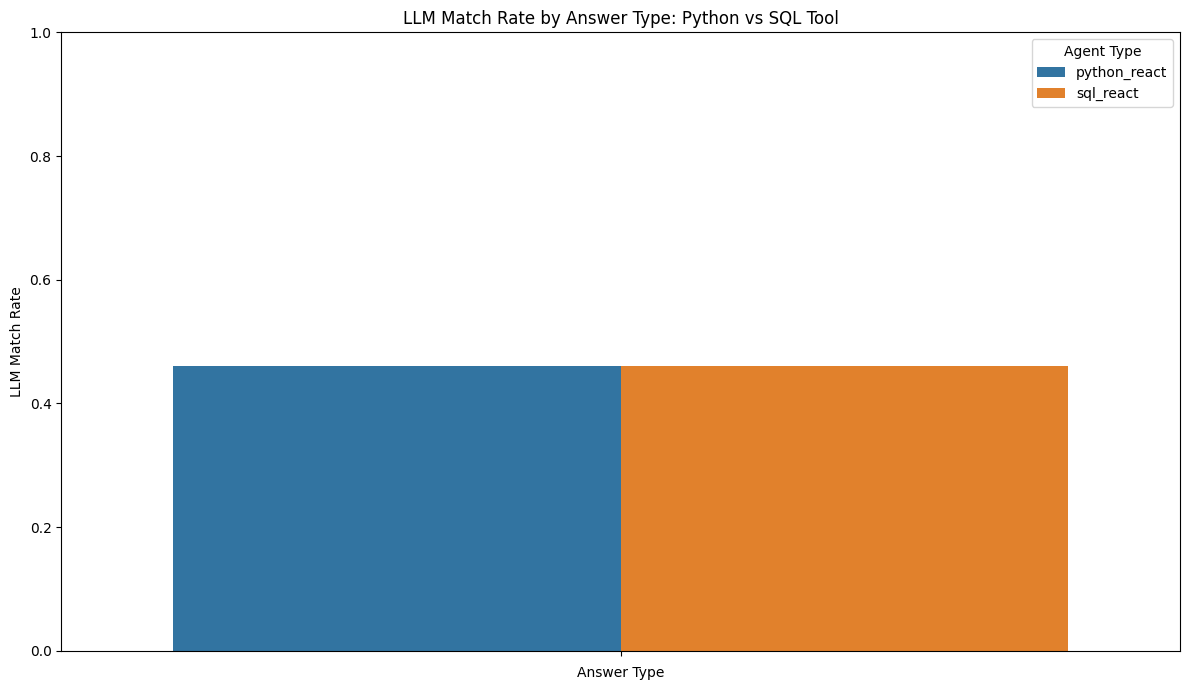


=== Performance by Number of Tables ===
     agent_type table_num  llm_match  count
0  python_react                 0.46    100
1     sql_react                 0.46    100


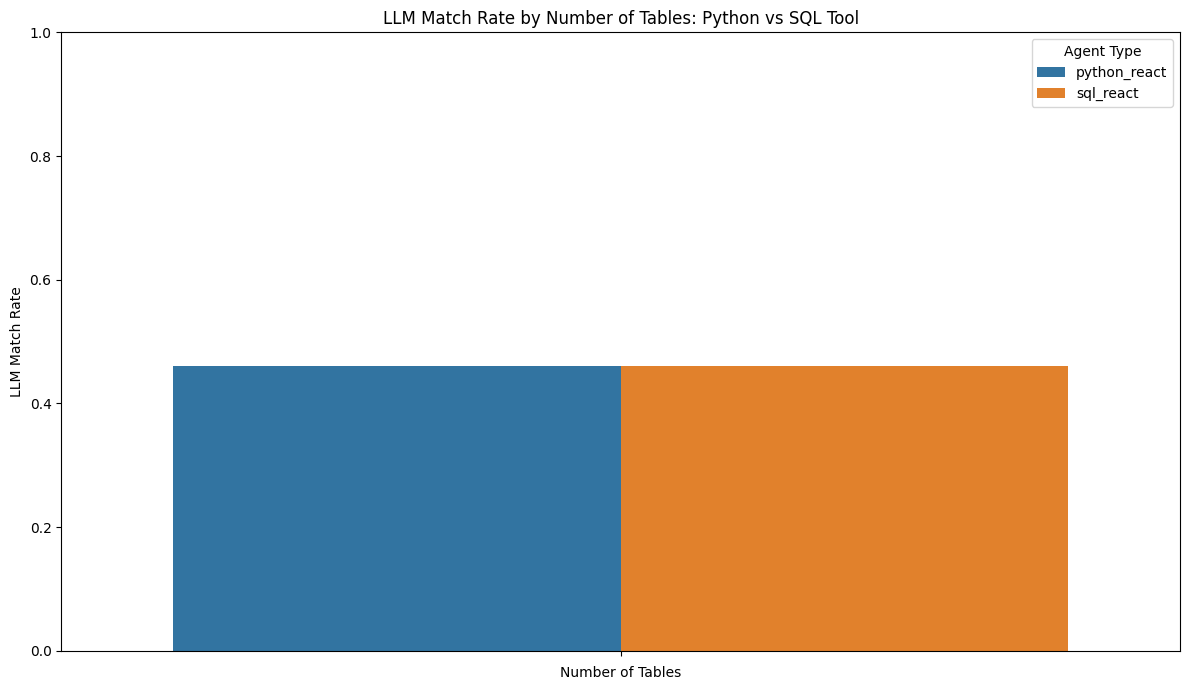


=== Performance by Number of Dialog Turns ===
      agent_type turn_bin  llm_match  count
0   python_react      1-5   0.500000      4
1   python_react     6-10   0.492754     69
2   python_react    11-15   0.391304     23
3   python_react    16-20   0.333333      3
4   python_react    21-25   0.000000      1
5   python_react    26-30        NaN      0
6      sql_react      1-5        NaN      0
7      sql_react     6-10   0.494253     87
8      sql_react    11-15   0.230769     13
9      sql_react    16-20        NaN      0
10     sql_react    21-25        NaN      0
11     sql_react    26-30        NaN      0


/tmp/ipykernel_53561/1303716085.py:206: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  turn_comparison = combined_df.groupby(['agent_type', 'turn_bin']).agg({


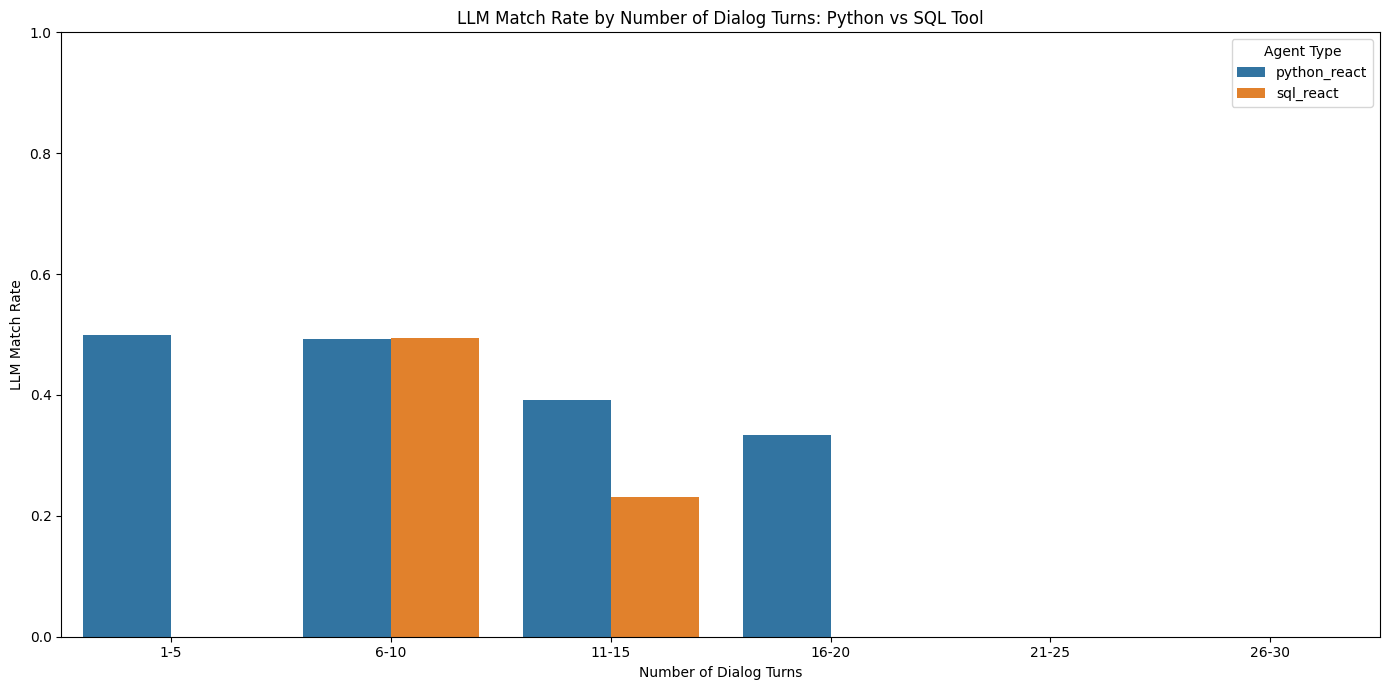


=== Token Usage Comparison ===
              total_prompt_tokens  total_completion_tokens  total_tokens
agent_type                                                              
python_react             23519.20                  1298.78      24817.98
sql_react                17406.05                   663.72      18069.77


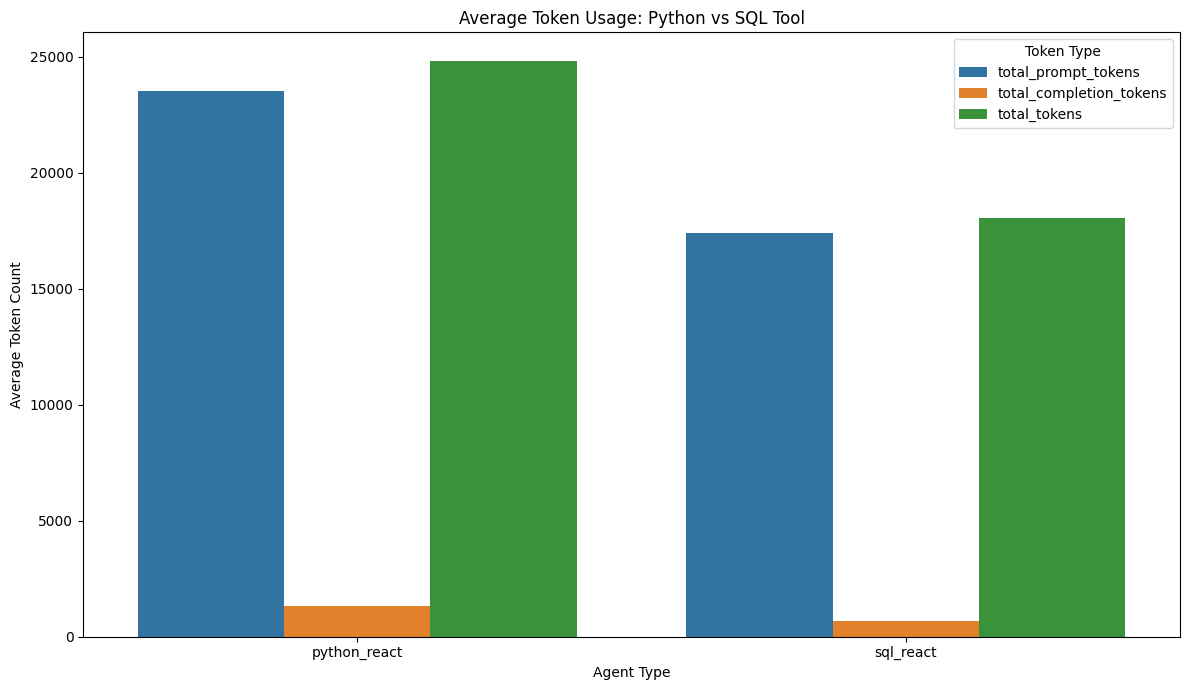


=== Unanswerable Response Comparison ===
              unanswerable_rate
agent_type                     
python_react               0.35
sql_react                  0.19


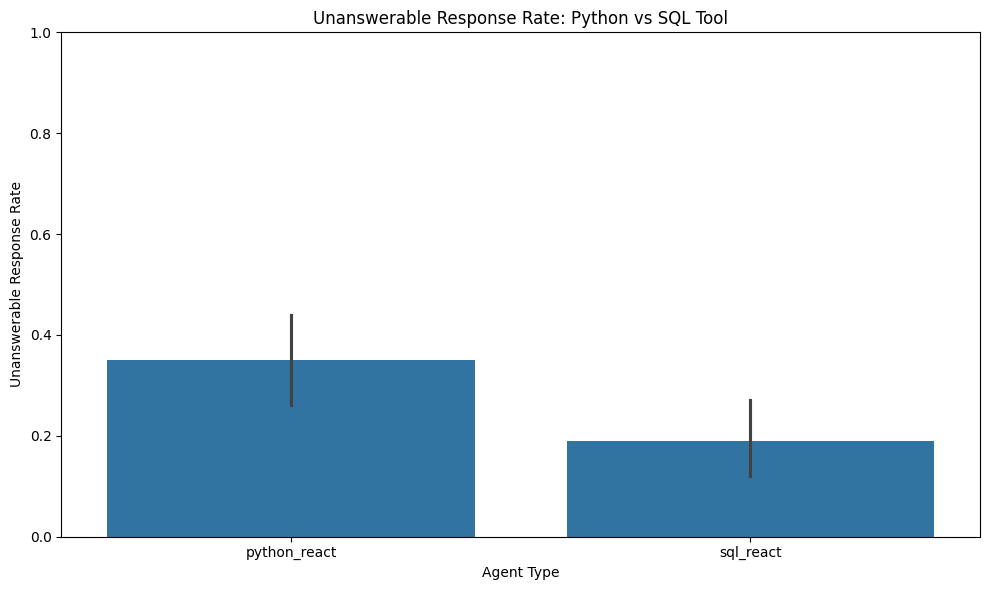


=== Performance on Common Questions ===
Number of common questions: 100
Performance on common questions:
Both correct: 37 (37.00%)
Python only correct: 9 (9.00%)
SQL only correct: 9 (9.00%)
Both wrong: 45 (45.00%)


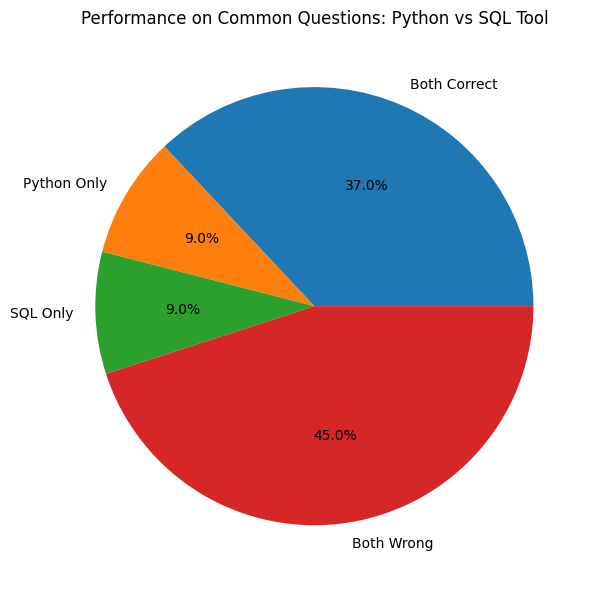


=== Success Rate by Question Complexity ===
              success_short_questions  success_medium_questions  \
agent_type                                                        
python_react                 0.428571                  0.562500   
sql_react                    0.357143                  0.578125   

              success_long_questions  
agent_type                            
python_react                0.181818  
sql_react                   0.181818  


/tmp/ipykernel_53561/1303716085.py:318: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  complexity_comparison = combined_df.groupby('agent_type').apply(


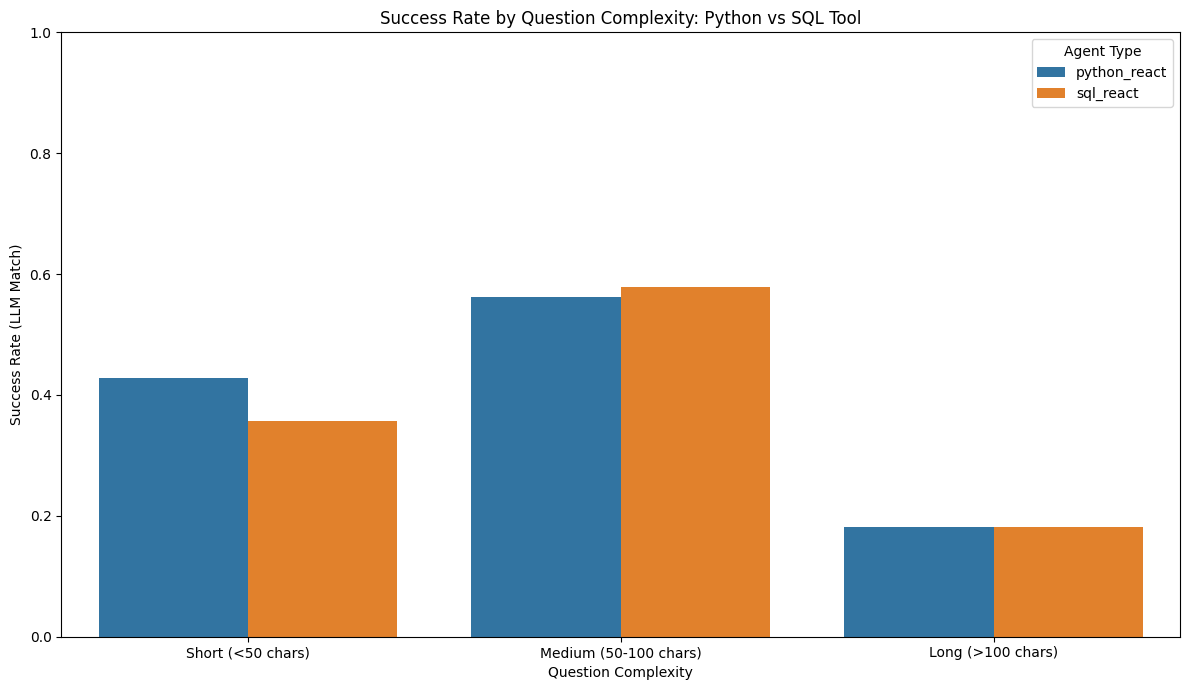


=== Average Number of Turns to Success ===
Python Tool - Average turns to success: 7.87
SQL Tool - Average turns to success: 7.39


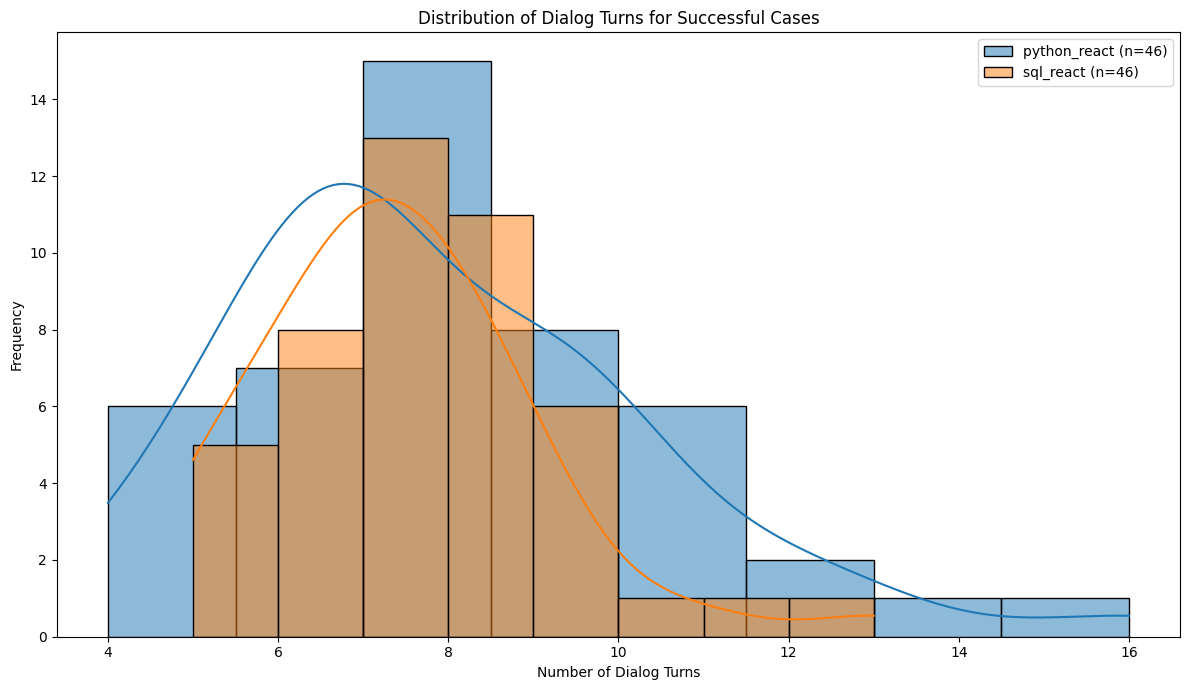

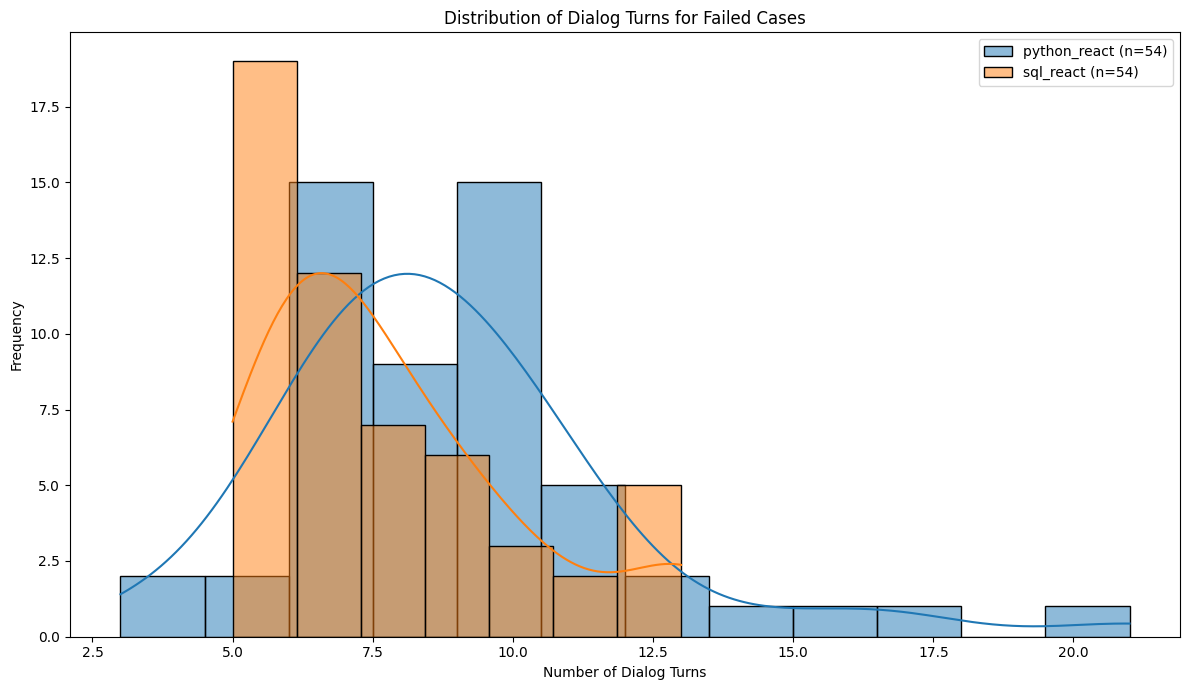


=== Summary and Conclusion ===
Python Tool LLM Match Rate: 46.00%
SQL Tool LLM Match Rate: 46.00%
Difference: 0.00%

Python Tool Average Tokens: 24817.98
SQL Tool Average Tokens: 18069.77
Token Usage Difference: 6748.21

Python Tool Average Turns: 8.38
SQL Tool Average Turns: 7.59
Turn Difference: 0.79

Python Tool performs best on '' answer types: 46.00%
SQL Tool performs best on '' answer types: 46.00%

Final Recommendation:
The Python Tool (python_react) and SQL Tool (sql_react) perform equally in terms of LLM match rate.


In [10]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

# Function to load data from JSON file
def load_data_from_file(file_path):
    """
    Load data from a JSON file.
    file_path: Path to the JSON file
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

# Function to convert data to DataFrame
def create_dataframe(data):
    """
    Extract necessary information from experiment data and convert to pandas DataFrame.
    """
    records = []
    
    for entry in data['evaluation_history']:
        record = {
            'id': entry['id'],
            'answer_type': entry['answer_type'],
            'table_num': entry['table_num'],
            'question': entry['question'],
            'expected_answer': entry['expected_answer'],
            'generated_answer': entry['generated_answer'],
            'total_turns': entry['total_turns'],
            'exact_match': entry.get('sample_metrics', {}).get('exact_match', False),
            'normalized_match': entry.get('sample_metrics', {}).get('normalized_match', False),
            'llm_match': entry.get('sample_metrics', {}).get('llm_match', False),
            'is_unanswerable': entry['generated_answer'] == 'Unanswerable'
        }
        
        # Add token usage information
        if 'token_usages' in entry:
            total_prompt_tokens = sum(usage.get('prompt_tokens', 0) for usage in entry['token_usages'])
            total_completion_tokens = sum(usage.get('completion_tokens', 0) for usage in entry['token_usages'])
            total_tokens = sum(usage.get('total_tokens', 0) for usage in entry['token_usages'])
            
            record['total_prompt_tokens'] = total_prompt_tokens
            record['total_completion_tokens'] = total_completion_tokens
            record['total_tokens'] = total_tokens
            record['turns_count'] = len(entry['token_usages'])
        
        records.append(record)
    
    return pd.DataFrame(records)

# Function to analyze SQL query complexity
def analyze_query_complexity(data):
    """
    Analyze the complexity of gold SQL queries.
    """
    complexity_metrics = []
    
    for entry in data['evaluation_history']:
        query = entry.get('gold_sql_query', '')
        
        # Calculate complexity metrics
        metrics = {
            'id': entry['id'],
            'table_count': entry['table_num'],
            'query_length': len(query),
            'select_count': query.lower().count('select'),
            'join_count': query.lower().count('join'),
            'where_count': query.lower().count('where'),
            'group_by_count': query.lower().count('group by'),
            'order_by_count': query.lower().count('order by'),
            'having_count': query.lower().count('having'),
            'union_count': query.lower().count('union'),
            'subquery_count': query.count('('),
            'llm_match': entry.get('sample_metrics', {}).get('llm_match', False)
        }
        
        complexity_metrics.append(metrics)
    
    return pd.DataFrame(complexity_metrics)

# List of result files
result_files = [
    "../results/04-10-db_python_react_gpt-4o_mimic_mimic_100.json",
    "../results/04-10-db_sql_react_gpt-4o_mimic_mimic_100.json", 
]

# Load the data from both files
try:
    python_data = load_data_from_file(result_files[0])
    sql_data = load_data_from_file(result_files[1])
    
    # Extract the agent type for labeling
    python_agent_type = python_data.get('metadata', {}).get('agent_type', 'python_react')
    sql_agent_type = sql_data.get('metadata', {}).get('agent_type', 'sql_react')
    
    # Create DataFrames
    python_df = create_dataframe(python_data)
    sql_df = create_dataframe(sql_data)
    
    # Add agent type column for identification
    python_df['agent_type'] = python_agent_type
    sql_df['agent_type'] = sql_agent_type
    
    # Combine DataFrames for comparison
    combined_df = pd.concat([python_df, sql_df], ignore_index=True)
    
    # Create query complexity DataFrames
    python_complexity = analyze_query_complexity(python_data)
    sql_complexity = analyze_query_complexity(sql_data)
    
    # Add agent type column for identification
    python_complexity['agent_type'] = python_agent_type
    sql_complexity['agent_type'] = sql_agent_type
    
    # Combine complexity DataFrames
    combined_complexity = pd.concat([python_complexity, sql_complexity], ignore_index=True)
    
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    # If there's an error, create dummy DataFrames for the analysis code to continue
    combined_df = pd.DataFrame()
    combined_complexity = pd.DataFrame()

# 1. Overall Performance Comparison
print("\n=== Overall Performance Comparison ===")
performance_comparison = combined_df.groupby('agent_type').agg({
    'exact_match': 'mean',
    'normalized_match': 'mean',
    'llm_match': 'mean',
    'is_unanswerable': 'mean',
    'total_turns': 'mean',
    'total_tokens': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'})

print(performance_comparison)

# Visualization: Overall Performance Metrics
plt.figure(figsize=(14, 7))
metrics = ['exact_match', 'normalized_match', 'llm_match']
performance_data = performance_comparison[metrics].reset_index()
performance_data_melted = pd.melt(performance_data, id_vars='agent_type', value_vars=metrics, 
                                  var_name='Metric', value_name='Value')

sns.barplot(x='agent_type', y='Value', hue='Metric', data=performance_data_melted)
plt.title('Overall Performance Comparison: Python vs SQL Tool')
plt.xlabel('Agent Type')
plt.ylabel('Match Rate')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# 2. Performance by Answer Type
print("\n=== Performance by Answer Type ===")
answer_type_comparison = combined_df.groupby(['agent_type', 'answer_type']).agg({
    'llm_match': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'}).reset_index()

print(answer_type_comparison)

# Visualization: Performance by Answer Type
plt.figure(figsize=(12, 7))
sns.barplot(x='answer_type', y='llm_match', hue='agent_type', data=answer_type_comparison)
plt.title('LLM Match Rate by Answer Type: Python vs SQL Tool')
plt.xlabel('Answer Type')
plt.ylabel('LLM Match Rate')
plt.ylim(0, 1)
plt.legend(title='Agent Type')
plt.tight_layout()
plt.show()

# 3. Performance by Number of Tables
print("\n=== Performance by Number of Tables ===")
table_comparison = combined_df.groupby(['agent_type', 'table_num']).agg({
    'llm_match': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'}).reset_index()

print(table_comparison)

# Visualization: Performance by Number of Tables
plt.figure(figsize=(12, 7))
sns.barplot(x='table_num', y='llm_match', hue='agent_type', data=table_comparison)
plt.title('LLM Match Rate by Number of Tables: Python vs SQL Tool')
plt.xlabel('Number of Tables')
plt.ylabel('LLM Match Rate')
plt.ylim(0, 1)
plt.legend(title='Agent Type')
plt.tight_layout()
plt.show()

# 4. Performance by Number of Dialog Turns
print("\n=== Performance by Number of Dialog Turns ===")
bins = [0, 5, 10, 15, 20, 25, 30]
labels = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30']
combined_df['turn_bin'] = pd.cut(combined_df['total_turns'], bins=bins, labels=labels, right=False)

turn_comparison = combined_df.groupby(['agent_type', 'turn_bin']).agg({
    'llm_match': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'}).reset_index()

print(turn_comparison)

# Visualization: Performance by Number of Dialog Turns
plt.figure(figsize=(14, 7))
sns.barplot(x='turn_bin', y='llm_match', hue='agent_type', data=turn_comparison)
plt.title('LLM Match Rate by Number of Dialog Turns: Python vs SQL Tool')
plt.xlabel('Number of Dialog Turns')
plt.ylabel('LLM Match Rate')
plt.ylim(0, 1)
plt.legend(title='Agent Type')
plt.tight_layout()
plt.show()

# 5. Token Usage Comparison
print("\n=== Token Usage Comparison ===")
token_comparison = combined_df.groupby('agent_type').agg({
    'total_prompt_tokens': 'mean',
    'total_completion_tokens': 'mean',
    'total_tokens': 'mean'
})

print(token_comparison)

# Visualization: Token Usage Comparison
plt.figure(figsize=(12, 7))
token_data = token_comparison.reset_index()
token_data_melted = pd.melt(token_data, id_vars='agent_type', 
                            value_vars=['total_prompt_tokens', 'total_completion_tokens', 'total_tokens'],
                            var_name='Token Type', value_name='Average Count')

sns.barplot(x='agent_type', y='Average Count', hue='Token Type', data=token_data_melted)
plt.title('Average Token Usage: Python vs SQL Tool')
plt.xlabel('Agent Type')
plt.ylabel('Average Token Count')
plt.legend(title='Token Type')
plt.tight_layout()
plt.show()

# 6. Unanswerable Response Comparison
print("\n=== Unanswerable Response Comparison ===")
unanswerable_comparison = combined_df.groupby('agent_type').agg({
    'is_unanswerable': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count', 'is_unanswerable': 'unanswerable_rate'})

print(unanswerable_comparison[['unanswerable_rate']])

# Visualization: Unanswerable Response Rate
plt.figure(figsize=(10, 6))
sns.barplot(x='agent_type', y='is_unanswerable', data=combined_df)
plt.title('Unanswerable Response Rate: Python vs SQL Tool')
plt.xlabel('Agent Type')
plt.ylabel('Unanswerable Response Rate')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 7. Performance on Common Questions
print("\n=== Performance on Common Questions ===")
# Identify common questions between both datasets
python_questions = set(python_df['question'])
sql_questions = set(sql_df['question'])
common_questions = python_questions.intersection(sql_questions)

print(f"Number of common questions: {len(common_questions)}")

# Filter to only common questions
python_common = python_df[python_df['question'].isin(common_questions)]
sql_common = sql_df[sql_df['question'].isin(common_questions)]

# Create a comparison DataFrame
common_comparison = pd.DataFrame({
    'question': list(common_questions),
    'python_llm_match': [python_common[python_common['question'] == q]['llm_match'].values[0] if len(python_common[python_common['question'] == q]) > 0 else False for q in common_questions],
    'sql_llm_match': [sql_common[sql_common['question'] == q]['llm_match'].values[0] if len(sql_common[sql_common['question'] == q]) > 0 else False for q in common_questions]
})

# Add comparison columns
common_comparison['both_correct'] = common_comparison['python_llm_match'] & common_comparison['sql_llm_match']
common_comparison['python_only'] = common_comparison['python_llm_match'] & ~common_comparison['sql_llm_match']
common_comparison['sql_only'] = ~common_comparison['python_llm_match'] & common_comparison['sql_llm_match']
common_comparison['both_wrong'] = ~common_comparison['python_llm_match'] & ~common_comparison['sql_llm_match']

# Print summary
print("Performance on common questions:")
print(f"Both correct: {common_comparison['both_correct'].sum()} ({common_comparison['both_correct'].mean():.2%})")
print(f"Python only correct: {common_comparison['python_only'].sum()} ({common_comparison['python_only'].mean():.2%})")
print(f"SQL only correct: {common_comparison['sql_only'].sum()} ({common_comparison['sql_only'].mean():.2%})")
print(f"Both wrong: {common_comparison['both_wrong'].sum()} ({common_comparison['both_wrong'].mean():.2%})")

# Visualization: Performance on Common Questions
plt.figure(figsize=(10, 6))
performance_counts = [
    common_comparison['both_correct'].sum(),
    common_comparison['python_only'].sum(),
    common_comparison['sql_only'].sum(),
    common_comparison['both_wrong'].sum()
]
performance_labels = ['Both Correct', 'Python Only', 'SQL Only', 'Both Wrong']
plt.pie(performance_counts, labels=performance_labels, autopct='%1.1f%%')
plt.title('Performance on Common Questions: Python vs SQL Tool')
plt.tight_layout()
plt.show()

# 8. Success Rate by Question Complexity
print("\n=== Success Rate by Question Complexity ===")
# Use query length as a proxy for complexity
complexity_comparison = combined_df.groupby('agent_type').apply(
    lambda x: pd.Series({
        'success_short_questions': x[x['question'].str.len() < 50]['llm_match'].mean(),
        'success_medium_questions': x[(x['question'].str.len() >= 50) & (x['question'].str.len() < 100)]['llm_match'].mean(),
        'success_long_questions': x[x['question'].str.len() >= 100]['llm_match'].mean(),
    })
)

print(complexity_comparison)

# Visualization: Success Rate by Question Complexity
plt.figure(figsize=(12, 7))
complexity_data = complexity_comparison.reset_index()
complexity_data_melted = pd.melt(complexity_data, id_vars='agent_type', 
                                value_vars=['success_short_questions', 'success_medium_questions', 'success_long_questions'],
                                var_name='Question Complexity', value_name='Success Rate')

# Rename the categories for better readability
complexity_data_melted['Question Complexity'] = complexity_data_melted['Question Complexity'].map({
    'success_short_questions': 'Short (<50 chars)',
    'success_medium_questions': 'Medium (50-100 chars)',
    'success_long_questions': 'Long (>100 chars)'
})

sns.barplot(x='Question Complexity', y='Success Rate', hue='agent_type', data=complexity_data_melted)
plt.title('Success Rate by Question Complexity: Python vs SQL Tool')
plt.xlabel('Question Complexity')
plt.ylabel('Success Rate (LLM Match)')
plt.ylim(0, 1)
plt.legend(title='Agent Type')
plt.tight_layout()
plt.show()

# 9. Average Number of Turns to Success
print("\n=== Average Number of Turns to Success ===")
successful_python = python_df[python_df['llm_match'] == True]
successful_sql = sql_df[sql_df['llm_match'] == True]

failed_python = python_df[python_df['llm_match'] == False]
failed_sql = sql_df[sql_df['llm_match'] == False]

print(f"Python Tool - Average turns to success: {successful_python['total_turns'].mean():.2f}")
print(f"SQL Tool - Average turns to success: {successful_sql['total_turns'].mean():.2f}")

# Visualization: Distribution of Turns for Successful Cases
plt.figure(figsize=(12, 7))
sns.histplot(successful_python['total_turns'], kde=True, label=f"{python_agent_type} (n={len(successful_python)})")
sns.histplot(successful_sql['total_turns'], kde=True, label=f"{sql_agent_type} (n={len(successful_sql)})")
plt.title('Distribution of Dialog Turns for Successful Cases')
plt.xlabel('Number of Dialog Turns')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization: Distribution of Turns for Failure Cases
plt.figure(figsize=(12, 7))
sns.histplot(failed_python['total_turns'], kde=True, label=f"{python_agent_type} (n={len(failed_python)})")
sns.histplot(failed_sql['total_turns'], kde=True, label=f"{sql_agent_type} (n={len(failed_sql)})")
plt.title('Distribution of Dialog Turns for Failed Cases')
plt.xlabel('Number of Dialog Turns')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# 10. Summary and Conclusion
print("\n=== Summary and Conclusion ===")
print(f"Python Tool LLM Match Rate: {python_df['llm_match'].mean():.2%}")
print(f"SQL Tool LLM Match Rate: {sql_df['llm_match'].mean():.2%}")
print(f"Difference: {python_df['llm_match'].mean() - sql_df['llm_match'].mean():.2%}")

print(f"\nPython Tool Average Tokens: {python_df['total_tokens'].mean():.2f}")
print(f"SQL Tool Average Tokens: {sql_df['total_tokens'].mean():.2f}")
print(f"Token Usage Difference: {python_df['total_tokens'].mean() - sql_df['total_tokens'].mean():.2f}")

print(f"\nPython Tool Average Turns: {python_df['total_turns'].mean():.2f}")
print(f"SQL Tool Average Turns: {sql_df['total_turns'].mean():.2f}")
print(f"Turn Difference: {python_df['total_turns'].mean() - sql_df['total_turns'].mean():.2f}")

# Identify areas where one tool significantly outperforms the other
python_strength = answer_type_comparison[answer_type_comparison['agent_type'] == python_agent_type].sort_values('llm_match', ascending=False).iloc[0]
sql_strength = answer_type_comparison[answer_type_comparison['agent_type'] == sql_agent_type].sort_values('llm_match', ascending=False).iloc[0]

print(f"\nPython Tool performs best on '{python_strength['answer_type']}' answer types: {python_strength['llm_match']:.2%}")
print(f"SQL Tool performs best on '{sql_strength['answer_type']}' answer types: {sql_strength['llm_match']:.2%}")

# Final recommendation
print("\nFinal Recommendation:")
if python_df['llm_match'].mean() > sql_df['llm_match'].mean():
    print(f"The Python Tool ({python_agent_type}) outperforms the SQL Tool ({sql_agent_type}) with a {python_df['llm_match'].mean() - sql_df['llm_match'].mean():.2%} higher LLM match rate.")
elif sql_df['llm_match'].mean() > python_df['llm_match'].mean():
    print(f"The SQL Tool ({sql_agent_type}) outperforms the Python Tool ({python_agent_type}) with a {sql_df['llm_match'].mean() - python_df['llm_match'].mean():.2%} higher LLM match rate.")
else:
    print(f"The Python Tool ({python_agent_type}) and SQL Tool ({sql_agent_type}) perform equally in terms of LLM match rate.")

Loaded 100 items from dataset.
Dataset columns: ['answer', 'answer_explanation', 'id', 'sql_result', 'db_id', 'question', 'template', 'query', 'value', 'q_tag', 't_tag', 'o_tag', 'tag', 'department', 'importance', 'para_type', 'is_impossible', 'split', 'classification']
Data loaded successfully.
Metadata merge successful. Found classification types: [10  6  7  8  9  2  4  1  3]

=== Overall Performance Comparison ===
              exact_match  normalized_match  llm_match  is_unanswerable  \
agent_type                                                                
python_react         0.37              0.46       0.46             0.35   
sql_react            0.37              0.51       0.46             0.19   

              total_turns  total_tokens  count  
agent_type                                      
python_react         8.38      24817.98    100  
sql_react            7.59      18069.77    100  


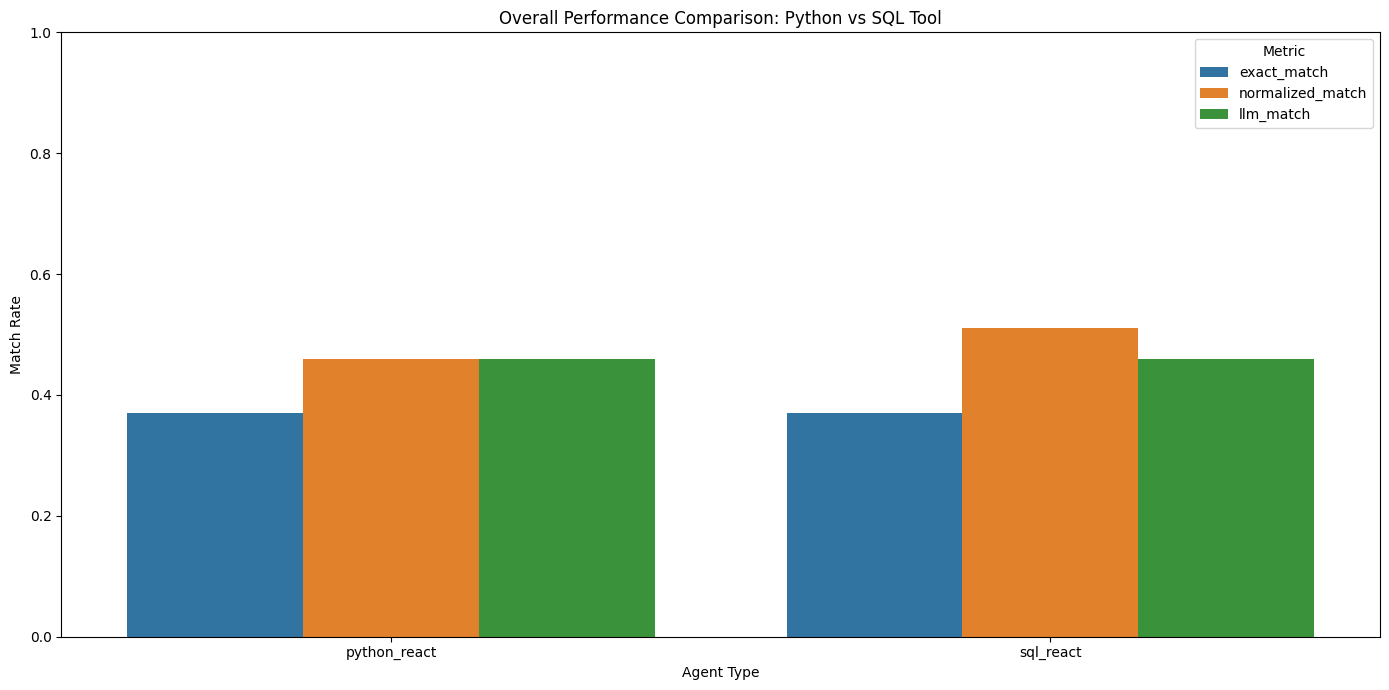


=== Performance by Answer Type ===
     agent_type answer_type  llm_match  count
0  python_react                   0.46    100
1     sql_react                   0.46    100


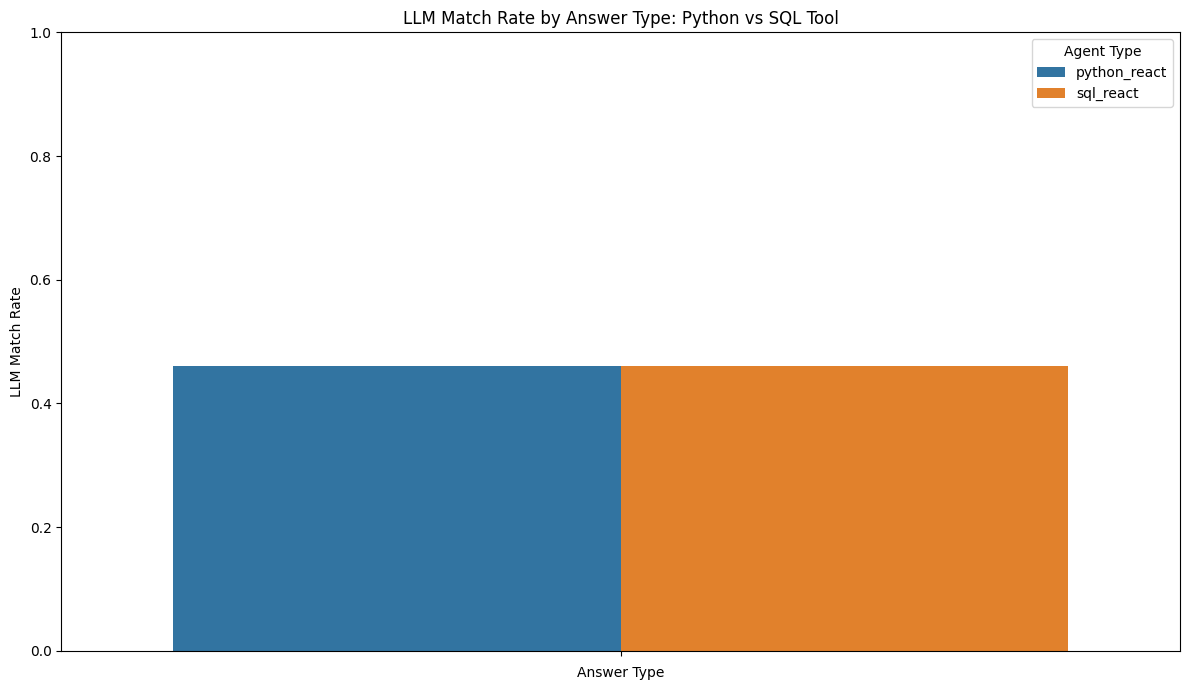


=== Performance by Number of Tables ===
     agent_type table_num  llm_match  count
0  python_react                 0.46    100
1     sql_react                 0.46    100


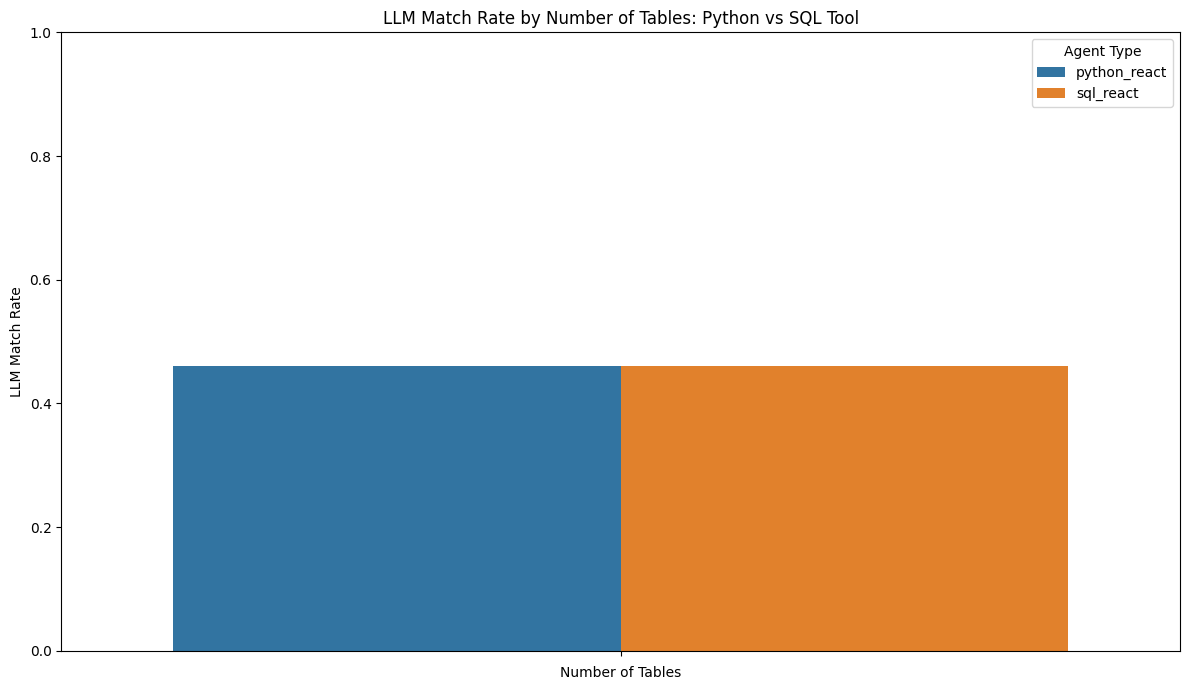

In [17]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from typing import List, Dict, Any, Optional

# Function to load data from JSONL file
def load_dataset_from_jsonl(file_path: str) -> List[Dict[str, Any]]:
    try:
        data = []
        with open(file_path, "r", encoding="utf-8") as file:
            for line_num, line in enumerate(file, 1):
                line = line.strip()
                if not line:
                    continue
                try:
                    item = json.loads(line)
                    data.append(item)
                except json.JSONDecodeError as e:
                    raise ValueError(f"Error parsing JSON at line {line_num}: {e}")

        if not data:
            raise ValueError("The JSONL file is empty.")
        return data
    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{file_path}' was not found.")

# Function to load data from JSON file
def load_data_from_file(file_path):
    """
    Load data from a JSON file.
    file_path: Path to the JSON file
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

# Function to convert data to DataFrame
def create_dataframe(data):
    """
    Extract necessary information from experiment data and convert to pandas DataFrame.
    """
    records = []
    
    for entry in data['evaluation_history']:
        record = {
            'id': entry['id'],
            'answer_type': entry['answer_type'],
            'table_num': entry['table_num'],
            'question': entry['question'],
            'expected_answer': entry['expected_answer'],
            'generated_answer': entry['generated_answer'],
            'total_turns': entry['total_turns'],
            'exact_match': entry.get('sample_metrics', {}).get('exact_match', False),
            'normalized_match': entry.get('sample_metrics', {}).get('normalized_match', False),
            'llm_match': entry.get('sample_metrics', {}).get('llm_match', False),
            'is_unanswerable': entry['generated_answer'] == 'Unanswerable'
        }
        
        # Add token usage information
        if 'token_usages' in entry:
            total_prompt_tokens = sum(usage.get('prompt_tokens', 0) for usage in entry['token_usages'])
            total_completion_tokens = sum(usage.get('completion_tokens', 0) for usage in entry['token_usages'])
            total_tokens = sum(usage.get('total_tokens', 0) for usage in entry['token_usages'])
            
            record['total_prompt_tokens'] = total_prompt_tokens
            record['total_completion_tokens'] = total_completion_tokens
            record['total_tokens'] = total_tokens
            record['turns_count'] = len(entry['token_usages'])
        
        records.append(record)
    
    return pd.DataFrame(records)

# Function to analyze SQL query complexity
def analyze_query_complexity(data):
    """
    Analyze the complexity of gold SQL queries.
    """
    complexity_metrics = []
    
    for entry in data['evaluation_history']:
        query = entry.get('gold_sql_query', '')
        
        # Calculate complexity metrics
        metrics = {
            'id': entry['id'],
            'table_count': entry['table_num'],
            'query_length': len(query),
            'select_count': query.lower().count('select'),
            'join_count': query.lower().count('join'),
            'where_count': query.lower().count('where'),
            'group_by_count': query.lower().count('group by'),
            'order_by_count': query.lower().count('order by'),
            'having_count': query.lower().count('having'),
            'union_count': query.lower().count('union'),
            'subquery_count': query.count('('),
            'llm_match': entry.get('sample_metrics', {}).get('llm_match', False)
        }
        
        complexity_metrics.append(metrics)
    
    return pd.DataFrame(complexity_metrics)

# Function to merge dataset metadata with result dataframes
def merge_dataset_metadata(result_df, dataset_items):
    """
    Merge the dataset metadata with the result dataframe.
    
    Args:
        result_df: DataFrame containing model evaluation results
        dataset_items: List of dictionaries containing dataset metadata
    
    Returns:
        DataFrame with merged metadata
    """
    # Create a dataframe from the dataset items
    dataset_df = pd.DataFrame(dataset_items)
    
    # Select only the columns we're interested in
    metadata_columns = ['id', 'classification', 'is_impossible', 'department', 'importance', 'q_tag']
    dataset_df = dataset_df[metadata_columns]
    
    # Merge with the result dataframe on 'id'
    merged_df = pd.merge(result_df, dataset_df, on='id', how='left')
    
    return merged_df

# List of result files
result_files = [
    "../results/04-10-db_python_react_gpt-4o_mimic_mimic_100.json",
    "../results/04-10-db_sql_react_gpt-4o_mimic_mimic_100.json", 
]

# Path to the dataset file
DATASET_PATH = "../data/evaluation/mimic_100.jsonl"

# Load the dataset
try:
    dataset_items = load_dataset_from_jsonl(DATASET_PATH)
    print(f"Loaded {len(dataset_items)} items from dataset.")
    
    # Create a sample dataframe to inspect columns
    sample_df = pd.DataFrame(dataset_items)
    print("Dataset columns:", sample_df.columns.tolist())
except Exception as e:
    print(f"Error loading dataset: {e}")
    dataset_items = []

# Load the data from both files
try:
    python_data = load_data_from_file(result_files[0])
    sql_data = load_data_from_file(result_files[1])
    
    # Extract the agent type for labeling
    python_agent_type = python_data.get('metadata', {}).get('agent_type', 'python_react')
    sql_agent_type = sql_data.get('metadata', {}).get('agent_type', 'sql_react')
    
    # Create DataFrames
    python_df = create_dataframe(python_data)
    sql_df = create_dataframe(sql_data)
    
    # Add agent type column for identification
    python_df['agent_type'] = python_agent_type
    sql_df['agent_type'] = sql_agent_type
    
    # Merge dataset metadata
    if dataset_items:
        python_df = merge_dataset_metadata(python_df, dataset_items)
        sql_df = merge_dataset_metadata(sql_df, dataset_items)
    
    # Combine DataFrames for comparison
    combined_df = pd.concat([python_df, sql_df], ignore_index=True)
    
    # Create query complexity DataFrames
    python_complexity = analyze_query_complexity(python_data)
    sql_complexity = analyze_query_complexity(sql_data)
    
    # Add agent type column for identification
    python_complexity['agent_type'] = python_agent_type
    sql_complexity['agent_type'] = sql_agent_type
    
    # Combine complexity DataFrames
    combined_complexity = pd.concat([python_complexity, sql_complexity], ignore_index=True)
    
    print("Data loaded successfully.")
    
    # Check if the metadata merge was successful
    if 'classification' in combined_df.columns:
        print(f"Metadata merge successful. Found classification types: {combined_df['classification'].unique()}")
    else:
        print("Metadata merge was not successful.")
except Exception as e:
    print(f"Error loading data: {e}")
    # If there's an error, create dummy DataFrames for the analysis code to continue
    combined_df = pd.DataFrame()
    combined_complexity = pd.DataFrame()

# 1. Overall Performance Comparison
print("\n=== Overall Performance Comparison ===")
performance_comparison = combined_df.groupby('agent_type').agg({
    'exact_match': 'mean',
    'normalized_match': 'mean',
    'llm_match': 'mean',
    'is_unanswerable': 'mean',
    'total_turns': 'mean',
    'total_tokens': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'})

print(performance_comparison)

# Visualization: Overall Performance Metrics
plt.figure(figsize=(14, 7))
metrics = ['exact_match', 'normalized_match', 'llm_match']
performance_data = performance_comparison[metrics].reset_index()
performance_data_melted = pd.melt(performance_data, id_vars='agent_type', value_vars=metrics, 
                                  var_name='Metric', value_name='Value')

sns.barplot(x='agent_type', y='Value', hue='Metric', data=performance_data_melted)
plt.title('Overall Performance Comparison: Python vs SQL Tool')
plt.xlabel('Agent Type')
plt.ylabel('Match Rate')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# 2. Performance by Answer Type
print("\n=== Performance by Answer Type ===")
answer_type_comparison = combined_df.groupby(['agent_type', 'answer_type']).agg({
    'llm_match': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'}).reset_index()

print(answer_type_comparison)

# Visualization: Performance by Answer Type
plt.figure(figsize=(12, 7))
sns.barplot(x='answer_type', y='llm_match', hue='agent_type', data=answer_type_comparison)
plt.title('LLM Match Rate by Answer Type: Python vs SQL Tool')
plt.xlabel('Answer Type')
plt.ylabel('LLM Match Rate')
plt.ylim(0, 1)
plt.legend(title='Agent Type')
plt.tight_layout()
plt.show()

# 3. Performance by Number of Tables
print("\n=== Performance by Number of Tables ===")
table_comparison = combined_df.groupby(['agent_type', 'table_num']).agg({
    'llm_match': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'}).reset_index()

print(table_comparison)

# Visualization: Performance by Number of Tables
plt.figure(figsize=(12, 7))
sns.barplot(x='table_num', y='llm_match', hue='agent_type', data=table_comparison)
plt.title('LLM Match Rate by Number of Tables: Python vs SQL Tool')
plt.xlabel('Number of Tables')
plt.ylabel('LLM Match Rate')
plt.ylim(0, 1)
plt.legend(title='Agent Type')
plt.tight_layout()
plt.show()


In [18]:
combined_df

,id,answer_type,table_num,question,expected_answer,generated_answer,total_turns,exact_match,normalized_match,llm_match,...,total_prompt_tokens,total_completion_tokens,total_tokens,turns_count,agent_type,classification,is_impossible,department,importance,q_tag
0,e29f0d7d2b72c481aa93adf9,,,is patient 20589 a person with a family histor...,Unanswerable,Unanswerable,16,True,True,True,...,50624,944,51568,16,python_react,10,True,[nursing],None,None
1,6ca3cf325f101822bc40d1f3,,,does patient 433 have any procedure appointmen...,Unanswerable,Unanswerable,9,True,True,True,...,22005,971,22976,9,python_react,10,True,[nursing],None,None
2,5717a739649ee336aab058b0,,,"since 4 years ago, how many patients were pres...",18,27,12,False,False,False,...,36237,1922,38159,12,python_react,6,False,"['physician', 'insurance_review']",medium,count the number of patients who were prescrib...
3,4efdd23bb96fca0c046d701a,,,"on 08/21/this year, when was the first time th...",2105-08-21 10:00:00,Unanswerable,9,False,False,False,...,26842,1413,28255,9,python_react,7,False,['-'],medium,when was the [time_filter_exact1] time that pa...
4,ba0ba3cac332ad613a2121ef,,,how many patients were prescribed with magnesi...,1,477,7,False,False,False,...,17365,893,18258,7,python_react,6,False,['-'],medium,count the number of patients who were prescrib...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,bdd7c3d35815502b72513741,,,what was the total length of excise diaphragm ...,Unanswerable,Unanswerable,13,True,True,True,...,38640,777,39417,13,sql_react,10,True,[physician],None,None
196,0a39ff985b511c669b26a5b1,,,tell me the prescriptions patient 88180 has re...,Unanswerable,Patient 88180 received the following prescript...,7,False,False,False,...,18052,1210,19262,7,sql_react,10,True,[physician],None,None
197,bad933add34026f90b110c32,,,what code is associated with icd-11 for aphasi...,Unanswerable,ICD-10 code 7843 is associated with aphasia.,6,False,False,False,...,11114,437,11551,6,sql_react,10,True,[physician],None,None
198,9e9b16699ec219a8b40ee61f,,,when patient 19428 ends the quarantine period ...,Unanswerable,Unanswerable,11,True,True,True,...,26846,838,27684,11,sql_react,10,True,[nursing],None,None



=== Performance by Classification (Question Type) ===
      agent_type  classification  llm_match  count
0   python_react               1   0.625000      8
1   python_react               2   0.400000     10
2   python_react               3   0.714286      7
3   python_react               4   0.166667      6
4   python_react               6   0.227273     22
5   python_react               7   0.833333      6
6   python_react               8   0.440000     25
7   python_react               9   0.333333      6
8   python_react              10   0.800000     10
9      sql_react               1   0.625000      8
10     sql_react               2   0.700000     10
11     sql_react               3   0.714286      7
12     sql_react               4   0.333333      6
13     sql_react               6   0.227273     22
14     sql_react               7   0.666667      6
15     sql_react               8   0.440000     25
16     sql_react               9   0.333333      6
17     sql_react           

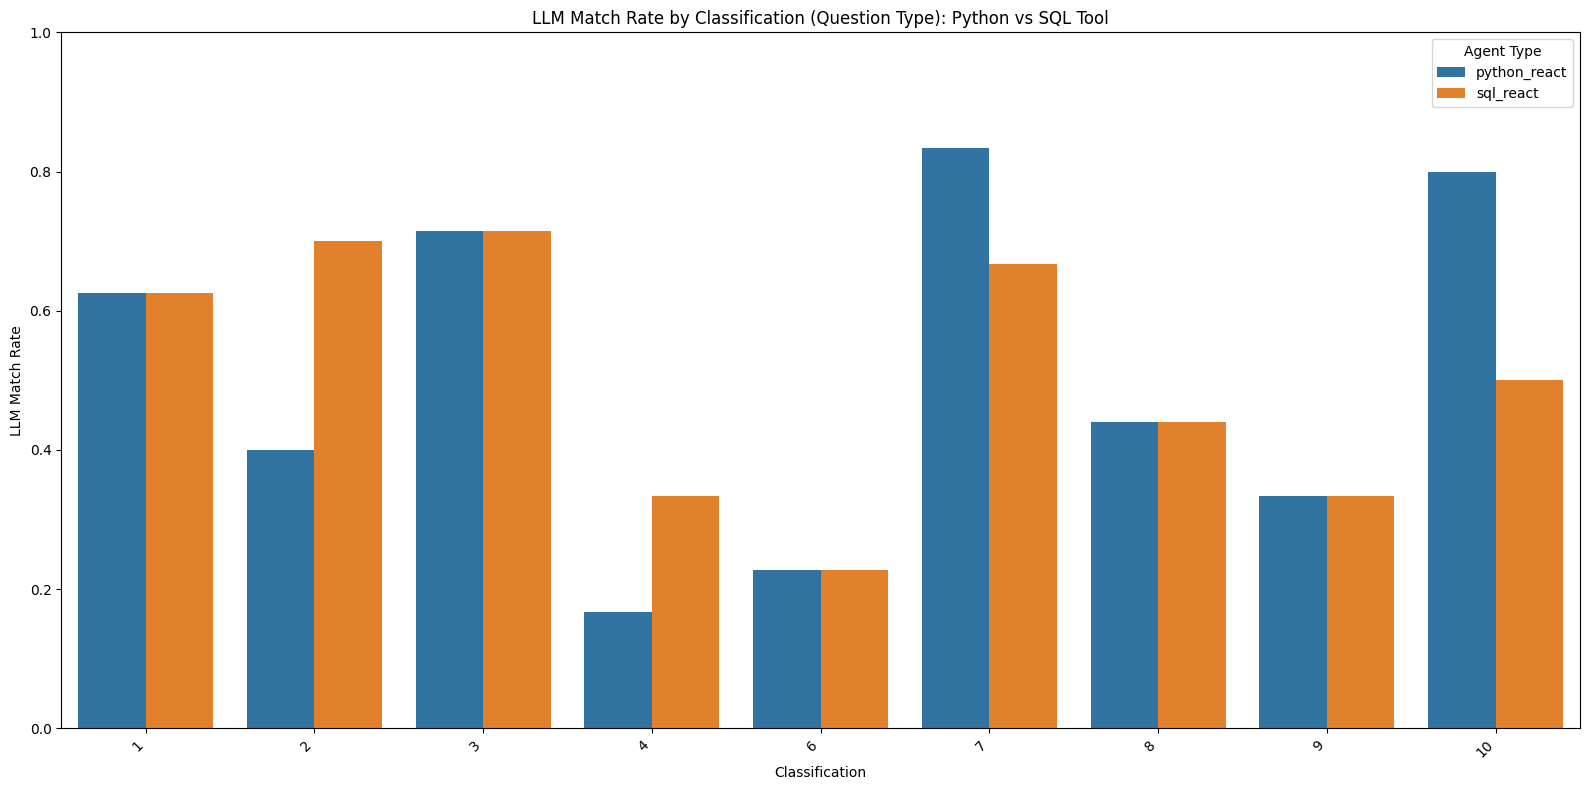

<Figure size 1600x600 with 0 Axes>

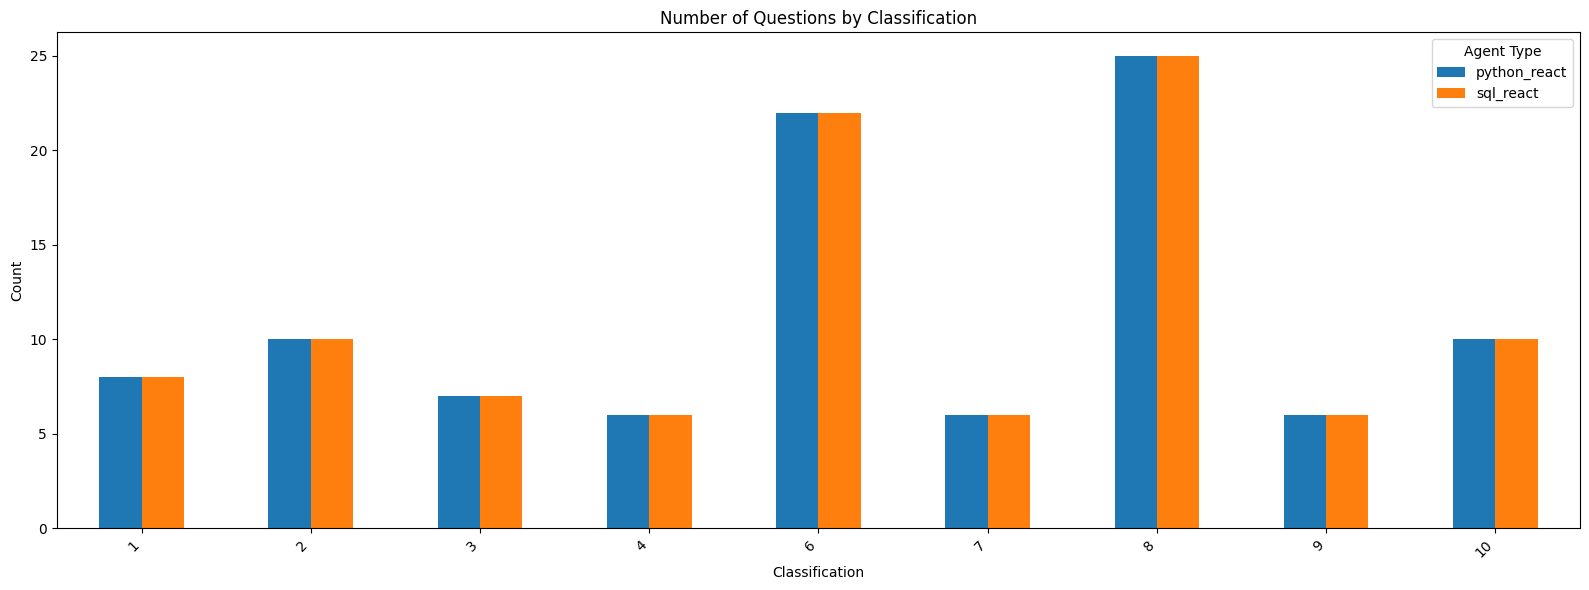


=== Performance by Is Impossible ===
     agent_type  is_impossible  llm_match  count
0  python_react          False   0.422222     90
1  python_react           True   0.800000     10
2     sql_react          False   0.455556     90
3     sql_react           True   0.500000     10


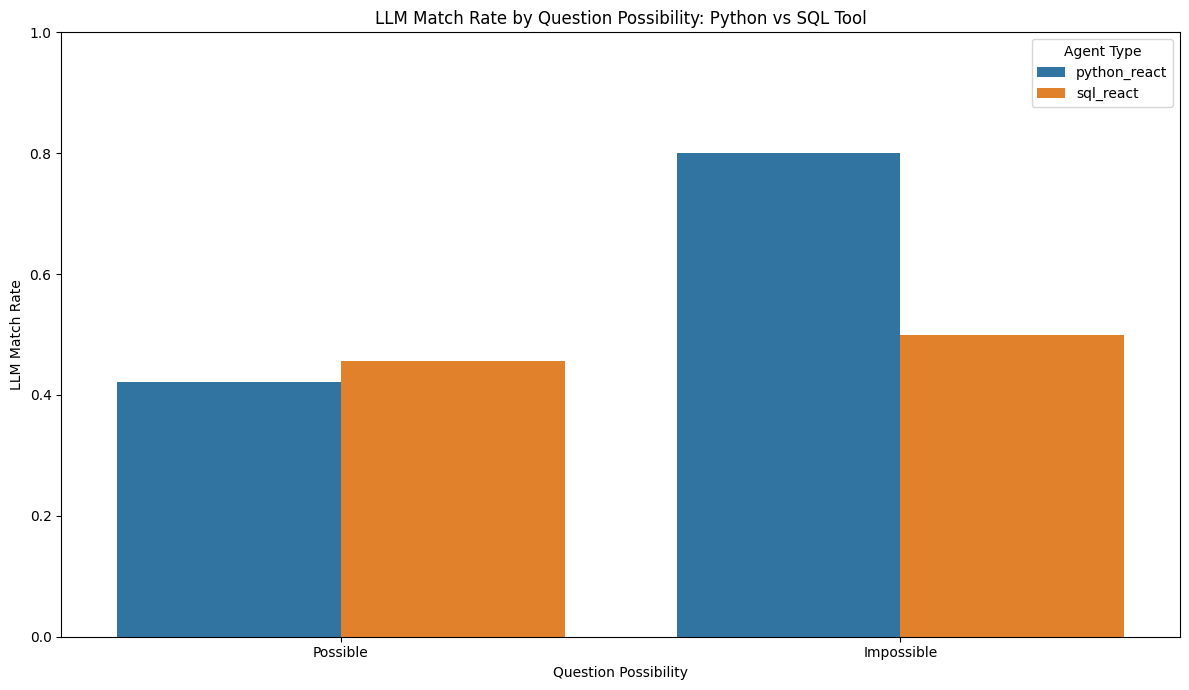


=== Model's Ability to Identify Impossible Questions ===
              correctly_identified_rate  count
agent_type                                    
python_react                        0.7     10
sql_react                           0.6     10


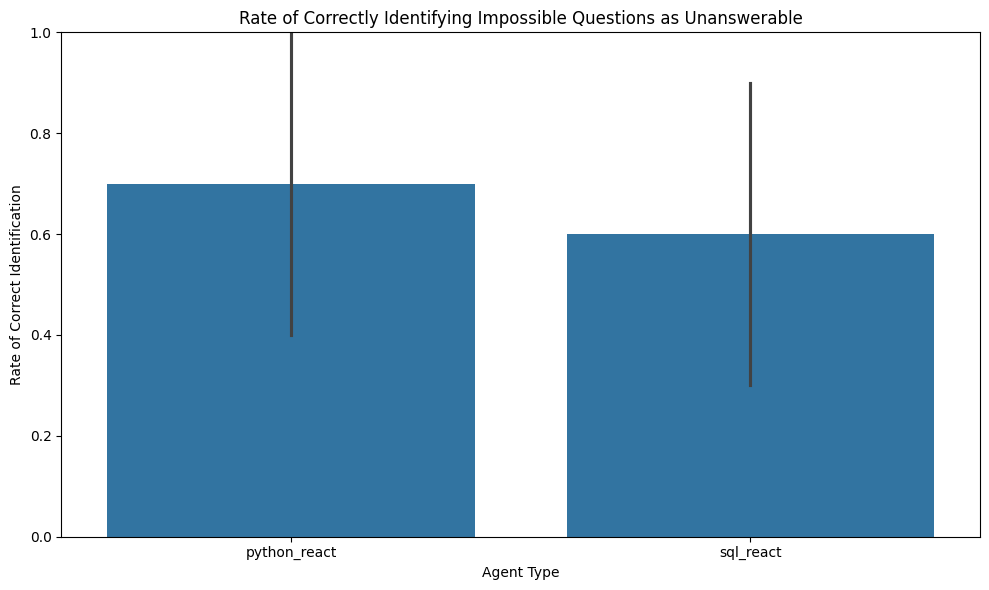


=== Performance by Number of Dialog Turns ===
      agent_type turn_bin  llm_match  count
0   python_react      1-5   0.500000      4
1   python_react     6-10   0.492754     69
2   python_react    11-15   0.391304     23
3   python_react    16-20   0.333333      3
4   python_react    21-25   0.000000      1
5   python_react    26-30        NaN      0
6      sql_react      1-5        NaN      0
7      sql_react     6-10   0.494253     87
8      sql_react    11-15   0.230769     13
9      sql_react    16-20        NaN      0
10     sql_react    21-25        NaN      0
11     sql_react    26-30        NaN      0


/tmp/ipykernel_53561/1658786907.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  turn_comparison = combined_df.groupby(['agent_type', 'turn_bin']).agg({


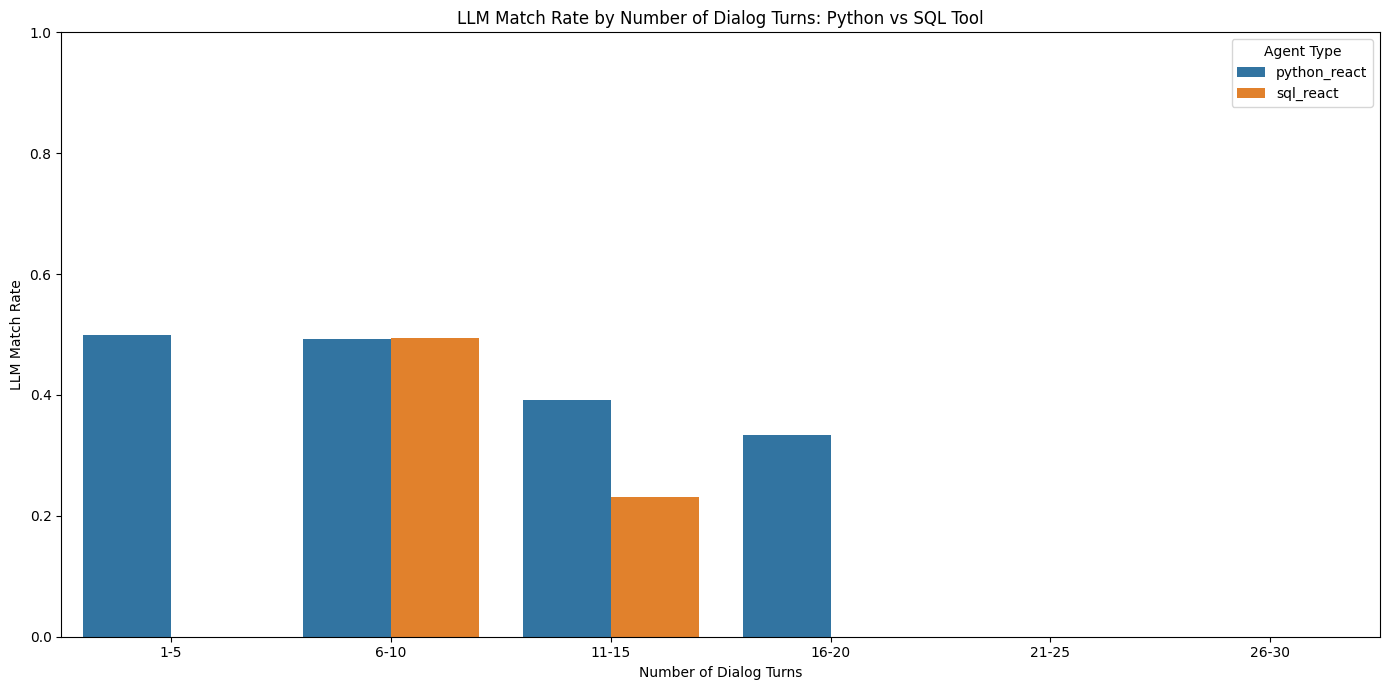


=== Token Usage Comparison ===
              total_prompt_tokens  total_completion_tokens  total_tokens
agent_type                                                              
python_react             23519.20                  1298.78      24817.98
sql_react                17406.05                   663.72      18069.77


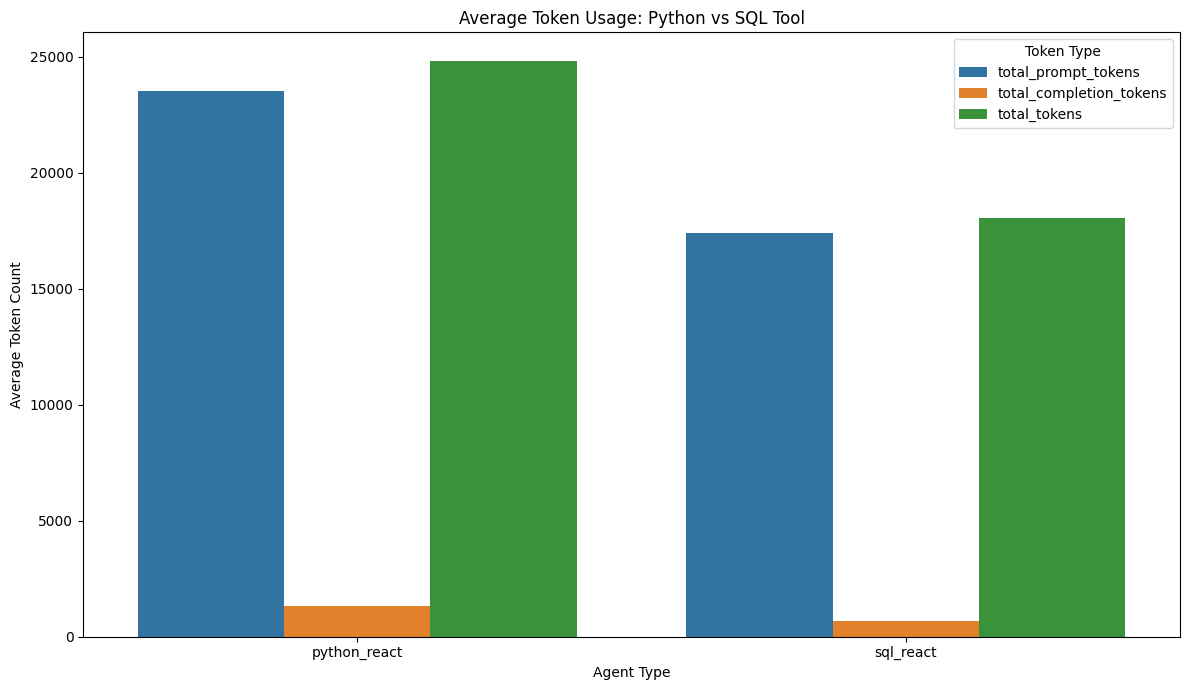


=== Token Usage by Classification ===
      agent_type  classification  total_tokens  llm_match  count
0   python_react               1  36507.125000   0.625000      8
1   python_react               2  16913.400000   0.400000     10
2   python_react               3  33303.142857   0.714286      7
3   python_react               4  24400.833333   0.166667      6
4   python_react               6  26121.818182   0.227273     22
5   python_react               7  18409.666667   0.833333      6
6   python_react               8  23166.800000   0.440000     25
7   python_react               9  23574.833333   0.333333      6
8   python_react              10  23532.300000   0.800000     10
9      sql_react               1  14666.250000   0.625000      8
10     sql_react               2  12855.600000   0.700000     10
11     sql_react               3  18019.714286   0.714286      7
12     sql_react               4  14585.666667   0.333333      6
13     sql_react               6  21631.590909   0.

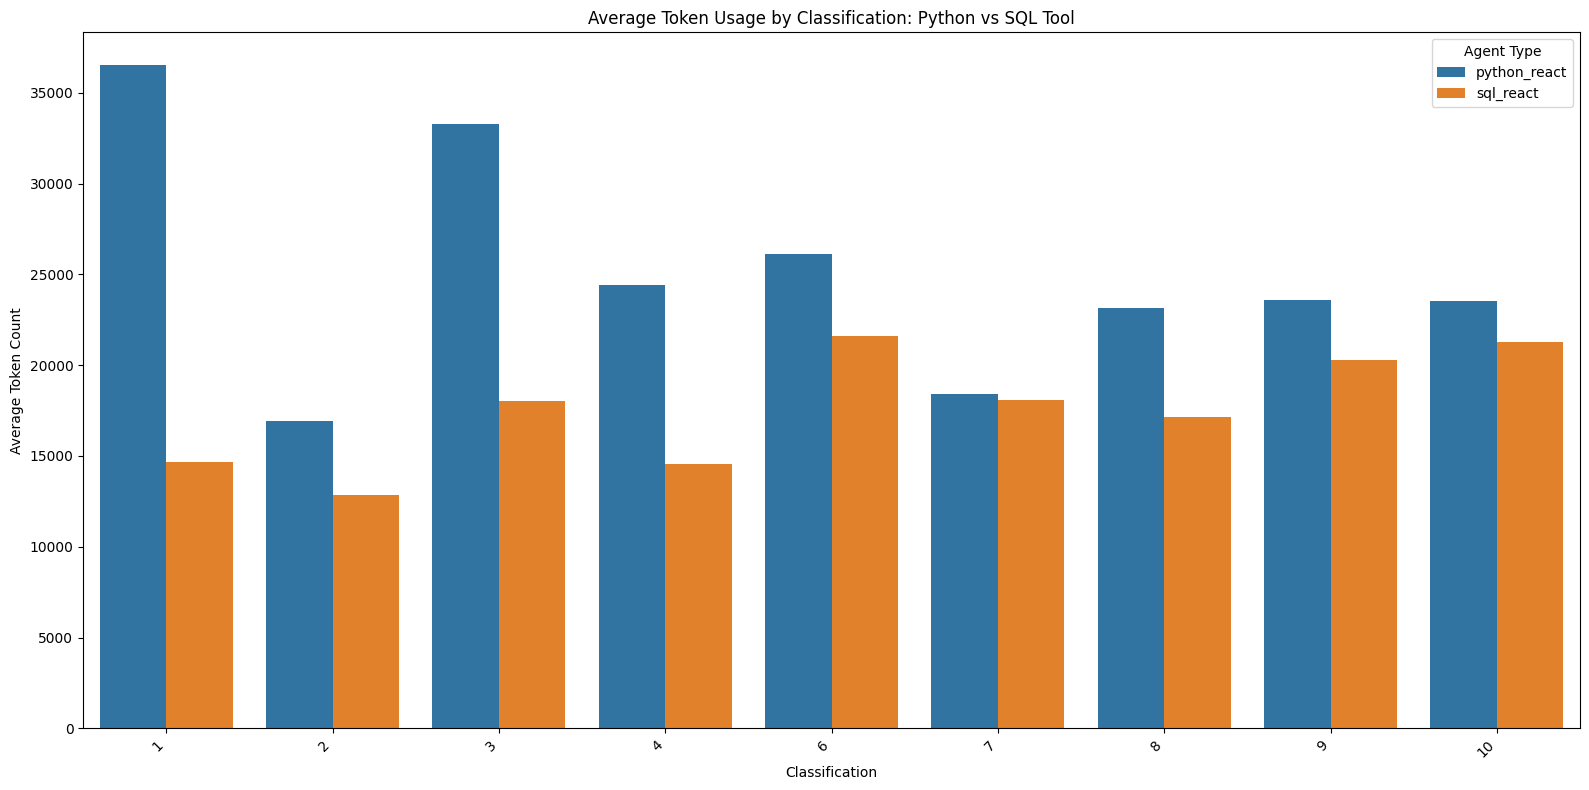


=== Unanswerable Response Comparison ===
              unanswerable_rate
agent_type                     
python_react               0.35
sql_react                  0.19


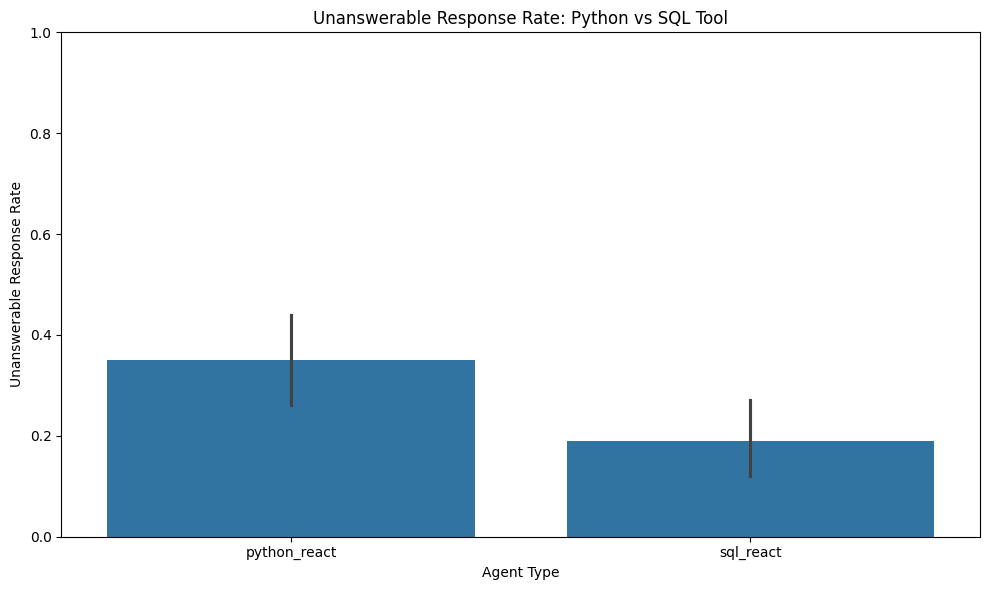


=== Performance on Common Questions ===
Number of common questions: 100
Performance on common questions:
Both correct: 37 (37.00%)
Python only correct: 9 (9.00%)
SQL only correct: 9 (9.00%)
Both wrong: 45 (45.00%)


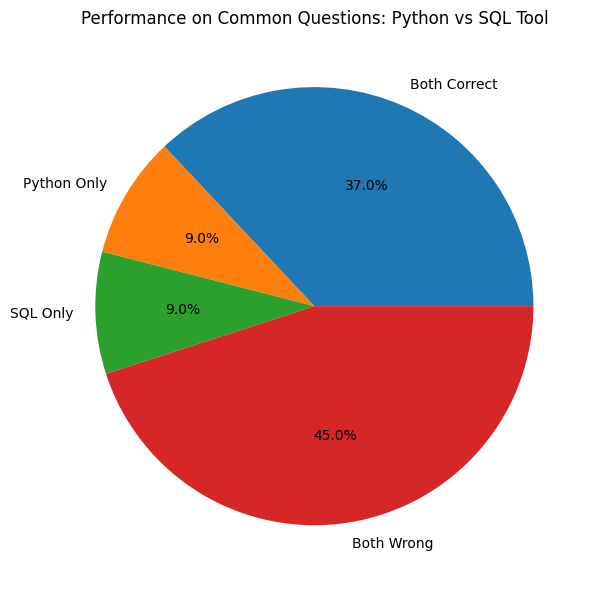


=== Classification Breakdown Where Tools Differ ===
Classifications where Python outperforms SQL:
   classification  count
2               8      3
4              10      3
0               6      1
1               7      1
3               9      1

Classifications where SQL outperforms Python:
   classification  count
0               2      3
3               8      3
1               4      1
2               6      1
4               9      1


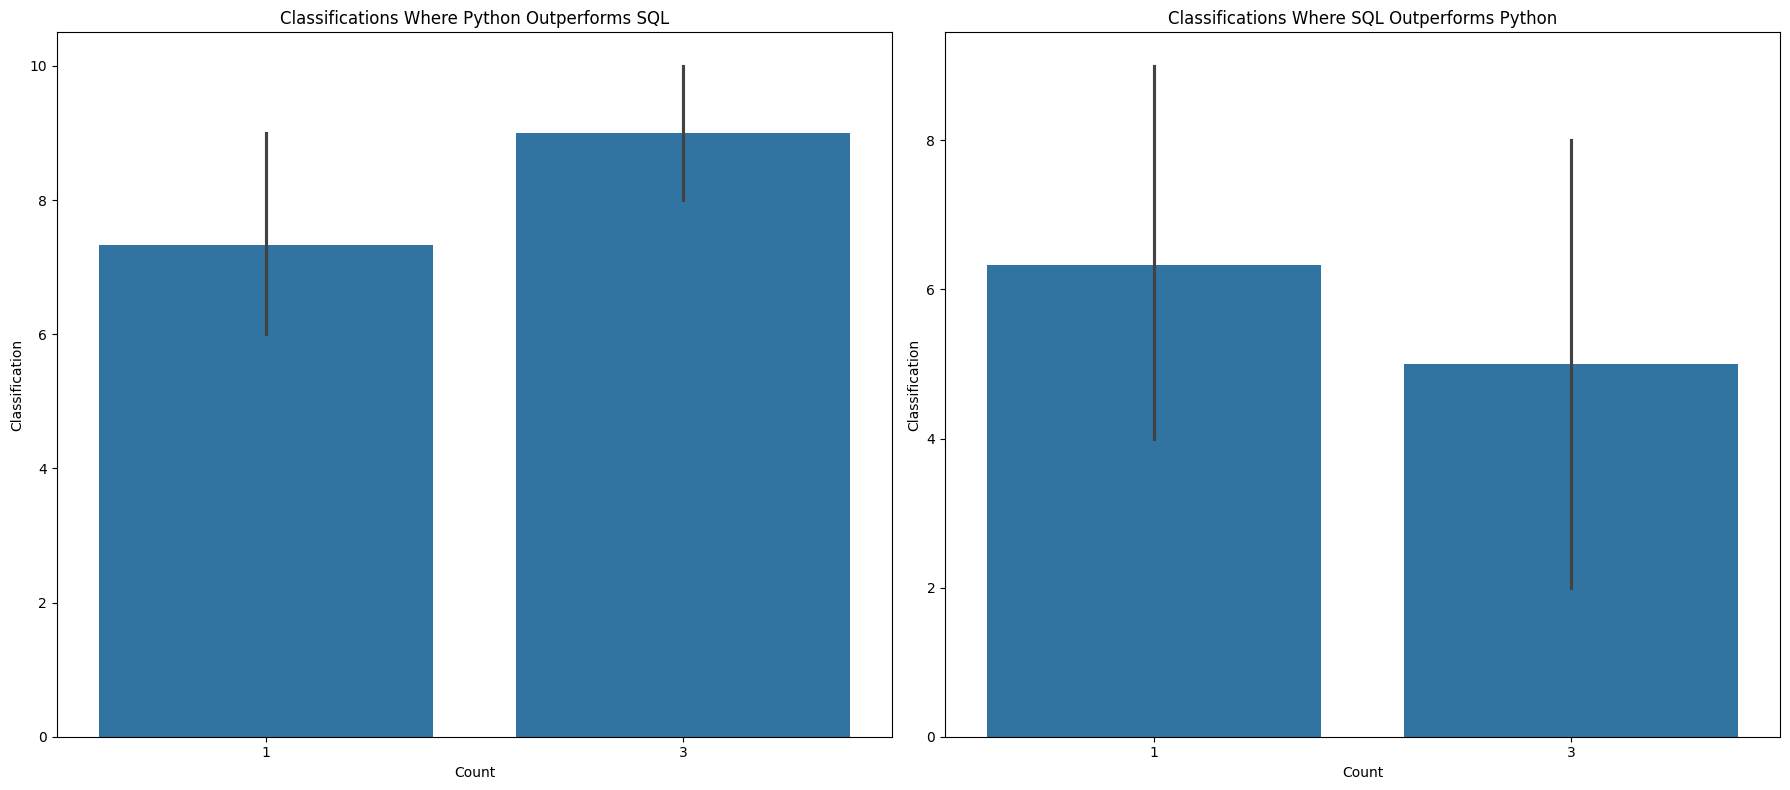


=== Success Rate by Question Complexity ===
              success_short_questions  success_medium_questions  \
agent_type                                                        
python_react                 0.428571                  0.562500   
sql_react                    0.357143                  0.578125   

              success_long_questions  
agent_type                            
python_react                0.181818  
sql_react                   0.181818  


/tmp/ipykernel_53561/1658786907.py:268: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  complexity_comparison = combined_df.groupby('agent_type').apply(


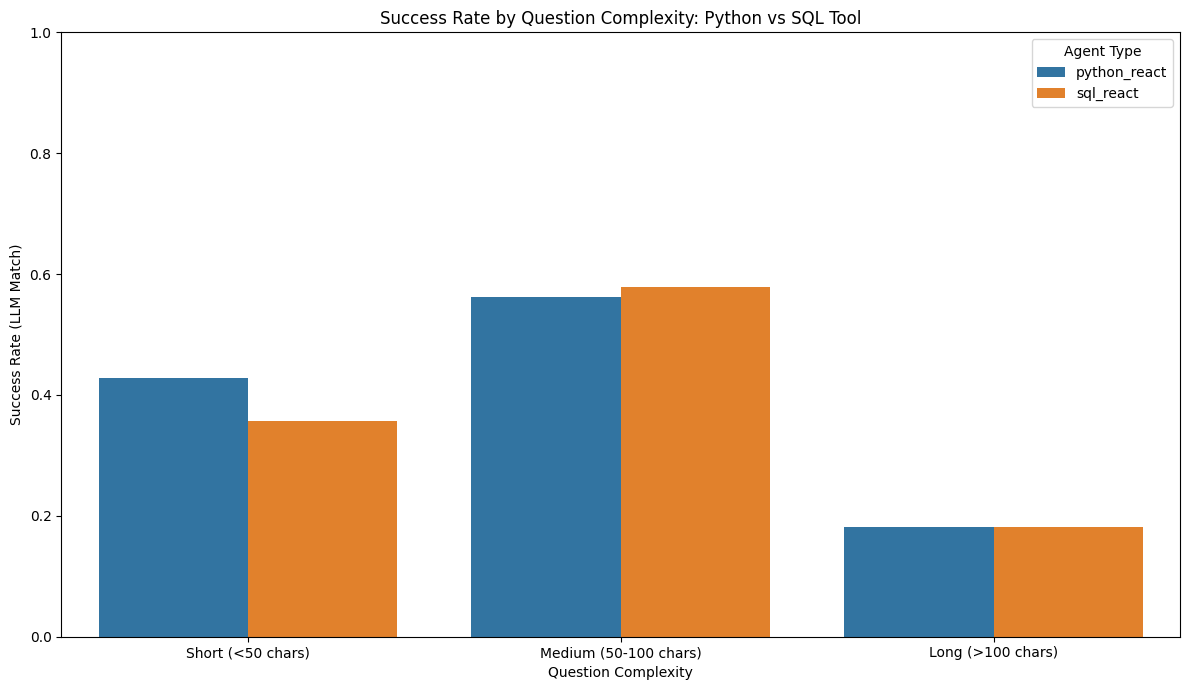


=== Average Number of Turns to Success ===
Python Tool - Average turns to success: 7.87
SQL Tool - Average turns to success: 7.39


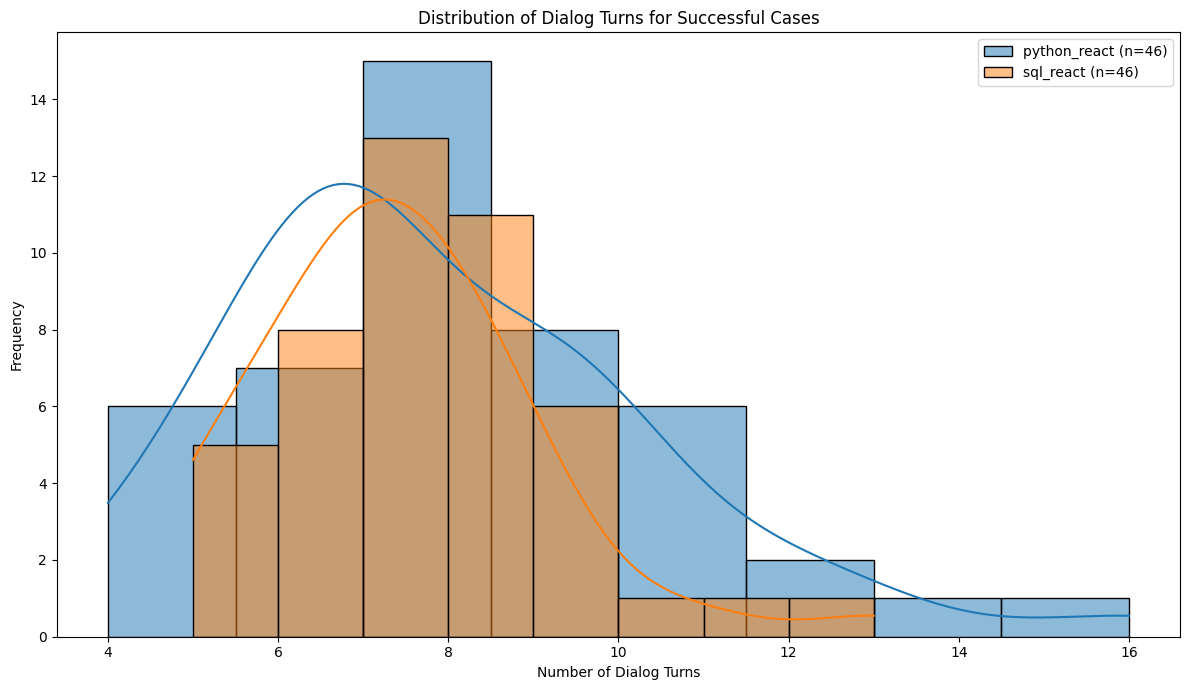


=== Summary and Conclusion ===
Python Tool LLM Match Rate: 46.00%
SQL Tool LLM Match Rate: 46.00%
Difference: 0.00%

Python Tool Average Tokens: 24817.98
SQL Tool Average Tokens: 18069.77
Token Usage Difference: 6748.21

Python Tool Average Turns: 8.38
SQL Tool Average Turns: 7.59
Turn Difference: 0.79

Python Tool performs best on '7' questions: 83.33%
Python Tool performs worst on '4' questions: 16.67%

SQL Tool performs best on '3' questions: 71.43%

SQL Tool performs best on '3' questions: 71.43%
SQL Tool performs worst on '6' questions: 22.73%

Python Tool performance on impossible questions: 80.00%
Python Tool performance on possible questions: 42.22%

SQL Tool performance on impossible questions: 50.00%
SQL Tool performance on possible questions: 45.56%

Final Recommendation:
The Python Tool (python_react) and SQL Tool (sql_react) perform equally in terms of LLM match rate.

Tool Recommendations by Question Type:

Use Python Tool for these question types:
- 10: Python outperfor

In [19]:

# New Analysis 1: Performance by Classification (Question Type)
if 'classification' in combined_df.columns:
    print("\n=== Performance by Classification (Question Type) ===")
    classification_comparison = combined_df.groupby(['agent_type', 'classification']).agg({
        'llm_match': 'mean',
        'id': 'count'
    }).rename(columns={'id': 'count'}).reset_index()
    
    print(classification_comparison)
    
    # Visualization: Performance by Classification
    plt.figure(figsize=(16, 8))
    sns.barplot(x='classification', y='llm_match', hue='agent_type', data=classification_comparison)
    plt.title('LLM Match Rate by Classification (Question Type): Python vs SQL Tool')
    plt.xlabel('Classification')
    plt.ylabel('LLM Match Rate')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Agent Type')
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: Number of questions by classification
    plt.figure(figsize=(16, 6))
    classification_counts = combined_df.groupby(['classification', 'agent_type']).size().unstack()
    classification_counts.plot(kind='bar', figsize=(16, 6))
    plt.title('Number of Questions by Classification')
    plt.xlabel('Classification')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Agent Type')
    plt.tight_layout()
    plt.show()

# New Analysis 2: Performance by Is Impossible
if 'is_impossible' in combined_df.columns:
    print("\n=== Performance by Is Impossible ===")
    impossible_comparison = combined_df.groupby(['agent_type', 'is_impossible']).agg({
        'llm_match': 'mean',
        'id': 'count'
    }).rename(columns={'id': 'count'}).reset_index()
    
    print(impossible_comparison)
    
    # Convert is_impossible to a more readable format for visualization
    impossible_comparison['Possibility'] = impossible_comparison['is_impossible'].map(
        {True: 'Impossible', False: 'Possible'}
    )
    
    # Visualization: Performance by Is Impossible
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Possibility', y='llm_match', hue='agent_type', data=impossible_comparison)
    plt.title('LLM Match Rate by Question Possibility: Python vs SQL Tool')
    plt.xlabel('Question Possibility')
    plt.ylabel('LLM Match Rate')
    plt.ylim(0, 1)
    plt.legend(title='Agent Type')
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: Is model correctly identifying impossible questions?
    if 'is_unanswerable' in combined_df.columns:
        print("\n=== Model's Ability to Identify Impossible Questions ===")
        
        # Create a subset with only impossible questions
        impossible_questions = combined_df[combined_df['is_impossible'] == True]
        
        # Calculate the percentage of impossible questions correctly identified as unanswerable
        correctly_identified = impossible_questions.groupby('agent_type').agg({
            'is_unanswerable': 'mean',
            'id': 'count'
        }).rename(columns={'id': 'count', 'is_unanswerable': 'correctly_identified_rate'})
        
        print(correctly_identified)
        
        # Visualization: Correctly Identifying Impossible Questions
        plt.figure(figsize=(10, 6))
        sns.barplot(x='agent_type', y='is_unanswerable', data=impossible_questions)
        plt.title('Rate of Correctly Identifying Impossible Questions as Unanswerable')
        plt.xlabel('Agent Type')
        plt.ylabel('Rate of Correct Identification')
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

# 4. Performance by Number of Dialog Turns
print("\n=== Performance by Number of Dialog Turns ===")
bins = [0, 5, 10, 15, 20, 25, 30]
labels = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30']
combined_df['turn_bin'] = pd.cut(combined_df['total_turns'], bins=bins, labels=labels, right=False)

turn_comparison = combined_df.groupby(['agent_type', 'turn_bin']).agg({
    'llm_match': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'}).reset_index()

print(turn_comparison)

# Visualization: Performance by Number of Dialog Turns
plt.figure(figsize=(14, 7))
sns.barplot(x='turn_bin', y='llm_match', hue='agent_type', data=turn_comparison)
plt.title('LLM Match Rate by Number of Dialog Turns: Python vs SQL Tool')
plt.xlabel('Number of Dialog Turns')
plt.ylabel('LLM Match Rate')
plt.ylim(0, 1)
plt.legend(title='Agent Type')
plt.tight_layout()
plt.show()

# 5. Token Usage Comparison
print("\n=== Token Usage Comparison ===")
token_comparison = combined_df.groupby('agent_type').agg({
    'total_prompt_tokens': 'mean',
    'total_completion_tokens': 'mean',
    'total_tokens': 'mean'
})

print(token_comparison)

# Visualization: Token Usage Comparison
plt.figure(figsize=(12, 7))
token_data = token_comparison.reset_index()
token_data_melted = pd.melt(token_data, id_vars='agent_type', 
                            value_vars=['total_prompt_tokens', 'total_completion_tokens', 'total_tokens'],
                            var_name='Token Type', value_name='Average Count')

sns.barplot(x='agent_type', y='Average Count', hue='Token Type', data=token_data_melted)
plt.title('Average Token Usage: Python vs SQL Tool')
plt.xlabel('Agent Type')
plt.ylabel('Average Token Count')
plt.legend(title='Token Type')
plt.tight_layout()
plt.show()

# New Analysis 3: Performance and Token Usage by Classification
if 'classification' in combined_df.columns:
    print("\n=== Token Usage by Classification ===")
    token_by_classification = combined_df.groupby(['agent_type', 'classification']).agg({
        'total_tokens': 'mean',
        'llm_match': 'mean',
        'id': 'count'
    }).rename(columns={'id': 'count'}).reset_index()
    
    print(token_by_classification[['agent_type', 'classification', 'total_tokens', 'llm_match', 'count']])
    
    # Visualization: Token Usage by Classification
    plt.figure(figsize=(16, 8))
    sns.barplot(x='classification', y='total_tokens', hue='agent_type', data=token_by_classification)
    plt.title('Average Token Usage by Classification: Python vs SQL Tool')
    plt.xlabel('Classification')
    plt.ylabel('Average Token Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Agent Type')
    plt.tight_layout()
    plt.show()

# 6. Unanswerable Response Comparison
print("\n=== Unanswerable Response Comparison ===")
unanswerable_comparison = combined_df.groupby('agent_type').agg({
    'is_unanswerable': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count', 'is_unanswerable': 'unanswerable_rate'})

print(unanswerable_comparison[['unanswerable_rate']])

# Visualization: Unanswerable Response Rate
plt.figure(figsize=(10, 6))
sns.barplot(x='agent_type', y='is_unanswerable', data=combined_df)
plt.title('Unanswerable Response Rate: Python vs SQL Tool')
plt.xlabel('Agent Type')
plt.ylabel('Unanswerable Response Rate')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 7. Performance on Common Questions
print("\n=== Performance on Common Questions ===")
# Identify common questions between both datasets
python_questions = set(python_df['question'])
sql_questions = set(sql_df['question'])
common_questions = python_questions.intersection(sql_questions)

print(f"Number of common questions: {len(common_questions)}")

# Filter to only common questions
python_common = python_df[python_df['question'].isin(common_questions)]
sql_common = sql_df[sql_df['question'].isin(common_questions)]

# Create a comparison DataFrame
common_comparison = pd.DataFrame({
    'question': list(common_questions),
    'python_llm_match': [python_common[python_common['question'] == q]['llm_match'].values[0] if len(python_common[python_common['question'] == q]) > 0 else False for q in common_questions],
    'sql_llm_match': [sql_common[sql_common['question'] == q]['llm_match'].values[0] if len(sql_common[sql_common['question'] == q]) > 0 else False for q in common_questions]
})

# Add comparison columns
common_comparison['both_correct'] = common_comparison['python_llm_match'] & common_comparison['sql_llm_match']
common_comparison['python_only'] = common_comparison['python_llm_match'] & ~common_comparison['sql_llm_match']
common_comparison['sql_only'] = ~common_comparison['python_llm_match'] & common_comparison['sql_llm_match']
common_comparison['both_wrong'] = ~common_comparison['python_llm_match'] & ~common_comparison['sql_llm_match']

# Print summary
print("Performance on common questions:")
print(f"Both correct: {common_comparison['both_correct'].sum()} ({common_comparison['both_correct'].mean():.2%})")
print(f"Python only correct: {common_comparison['python_only'].sum()} ({common_comparison['python_only'].mean():.2%})")
print(f"SQL only correct: {common_comparison['sql_only'].sum()} ({common_comparison['sql_only'].mean():.2%})")
print(f"Both wrong: {common_comparison['both_wrong'].sum()} ({common_comparison['both_wrong'].mean():.2%})")

# Visualization: Performance on Common Questions
plt.figure(figsize=(10, 6))
performance_counts = [
    common_comparison['both_correct'].sum(),
    common_comparison['python_only'].sum(),
    common_comparison['sql_only'].sum(),
    common_comparison['both_wrong'].sum()
]
performance_labels = ['Both Correct', 'Python Only', 'SQL Only', 'Both Wrong']
plt.pie(performance_counts, labels=performance_labels, autopct='%1.1f%%')
plt.title('Performance on Common Questions: Python vs SQL Tool')
plt.tight_layout()
plt.show()

# New Analysis 4: Classification breakdown of questions where tools differ
if 'classification' in combined_df.columns and len(common_questions) > 0:
    print("\n=== Classification Breakdown Where Tools Differ ===")
    
    # Add classification to common_comparison
    python_class_map = {q: cls for q, cls in zip(python_common['question'], python_common['classification'])}
    common_comparison['classification'] = common_comparison['question'].map(python_class_map)
    
    # Count where Python is correct but SQL is not
    python_better = common_comparison[common_comparison['python_only']].groupby('classification').size().reset_index(name='count')
    python_better = python_better.sort_values('count', ascending=False)
    
    # Count where SQL is correct but Python is not
    sql_better = common_comparison[common_comparison['sql_only']].groupby('classification').size().reset_index(name='count')
    sql_better = sql_better.sort_values('count', ascending=False)
    
    print("Classifications where Python outperforms SQL:")
    print(python_better)
    
    print("\nClassifications where SQL outperforms Python:")
    print(sql_better)
    
    # Visualization: Classification breakdown of differing performance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Python outperforms SQL
    if len(python_better) > 0:
        sns.barplot(x='count', y='classification', data=python_better, ax=ax1)
        ax1.set_title('Classifications Where Python Outperforms SQL')
        ax1.set_xlabel('Count')
        ax1.set_ylabel('Classification')
    
    # SQL outperforms Python
    if len(sql_better) > 0:
        sns.barplot(x='count', y='classification', data=sql_better, ax=ax2)
        ax2.set_title('Classifications Where SQL Outperforms Python')
        ax2.set_xlabel('Count')
        ax2.set_ylabel('Classification')
    
    plt.tight_layout()
    plt.show()

# 8. Success Rate by Question Complexity
print("\n=== Success Rate by Question Complexity ===")
# Use query length as a proxy for complexity
complexity_comparison = combined_df.groupby('agent_type').apply(
    lambda x: pd.Series({
        'success_short_questions': x[x['question'].str.len() < 50]['llm_match'].mean(),
        'success_medium_questions': x[(x['question'].str.len() >= 50) & (x['question'].str.len() < 100)]['llm_match'].mean(),
        'success_long_questions': x[x['question'].str.len() >= 100]['llm_match'].mean(),
    })
)

print(complexity_comparison)

# Visualization: Success Rate by Question Complexity
plt.figure(figsize=(12, 7))
complexity_data = complexity_comparison.reset_index()
complexity_data_melted = pd.melt(complexity_data, id_vars='agent_type', 
                                value_vars=['success_short_questions', 'success_medium_questions', 'success_long_questions'],
                                var_name='Question Complexity', value_name='Success Rate')

# Rename the categories for better readability
complexity_data_melted['Question Complexity'] = complexity_data_melted['Question Complexity'].map({
    'success_short_questions': 'Short (<50 chars)',
    'success_medium_questions': 'Medium (50-100 chars)',
    'success_long_questions': 'Long (>100 chars)'
})

sns.barplot(x='Question Complexity', y='Success Rate', hue='agent_type', data=complexity_data_melted)
plt.title('Success Rate by Question Complexity: Python vs SQL Tool')
plt.xlabel('Question Complexity')
plt.ylabel('Success Rate (LLM Match)')
plt.ylim(0, 1)
plt.legend(title='Agent Type')
plt.tight_layout()
plt.show()

# 9. Average Number of Turns to Success
print("\n=== Average Number of Turns to Success ===")
successful_python = python_df[python_df['llm_match'] == True]
successful_sql = sql_df[sql_df['llm_match'] == True]

print(f"Python Tool - Average turns to success: {successful_python['total_turns'].mean():.2f}")
print(f"SQL Tool - Average turns to success: {successful_sql['total_turns'].mean():.2f}")

# Visualization: Distribution of Turns for Successful Cases
plt.figure(figsize=(12, 7))
sns.histplot(successful_python['total_turns'], kde=True, label=f"{python_agent_type} (n={len(successful_python)})")
sns.histplot(successful_sql['total_turns'], kde=True, label=f"{sql_agent_type} (n={len(successful_sql)})")
plt.title('Distribution of Dialog Turns for Successful Cases')
plt.xlabel('Number of Dialog Turns')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# 10. Summary and Conclusion
print("\n=== Summary and Conclusion ===")
print(f"Python Tool LLM Match Rate: {python_df['llm_match'].mean():.2%}")
print(f"SQL Tool LLM Match Rate: {sql_df['llm_match'].mean():.2%}")
print(f"Difference: {python_df['llm_match'].mean() - sql_df['llm_match'].mean():.2%}")

print(f"\nPython Tool Average Tokens: {python_df['total_tokens'].mean():.2f}")
print(f"SQL Tool Average Tokens: {sql_df['total_tokens'].mean():.2f}")
print(f"Token Usage Difference: {python_df['total_tokens'].mean() - sql_df['total_tokens'].mean():.2f}")

print(f"\nPython Tool Average Turns: {python_df['total_turns'].mean():.2f}")
print(f"SQL Tool Average Turns: {sql_df['total_turns'].mean():.2f}")
print(f"Turn Difference: {python_df['total_turns'].mean() - sql_df['total_turns'].mean():.2f}")

# Classification-specific insights
if 'classification' in combined_df.columns:
    # Python's best and worst classifications
    python_class_perf = combined_df[combined_df['agent_type'] == python_agent_type].groupby('classification').agg({
        'llm_match': ['mean', 'count']
    })
    python_class_perf.columns = ['match_rate', 'count']
    python_class_perf = python_class_perf[python_class_perf['count'] >= 5]  # Only include classifications with at least 5 samples
    
    python_best_class = python_class_perf.sort_values('match_rate', ascending=False).index[0]
    python_worst_class = python_class_perf.sort_values('match_rate').index[0]
    
    # SQL's best and worst classifications
    sql_class_perf = combined_df[combined_df['agent_type'] == sql_agent_type].groupby('classification').agg({
        'llm_match': ['mean', 'count']
    })
    sql_class_perf.columns = ['match_rate', 'count']
    sql_class_perf = sql_class_perf[sql_class_perf['count'] >= 5]  # Only include classifications with at least 5 samples
    
    sql_best_class = sql_class_perf.sort_values('match_rate', ascending=False).index[0]
    sql_worst_class = sql_class_perf.sort_values('match_rate').index[0]
    
    print(f"\nPython Tool performs best on '{python_best_class}' questions: {python_class_perf.loc[python_best_class, 'match_rate']:.2%}")
    print(f"Python Tool performs worst on '{python_worst_class}' questions: {python_class_perf.loc[python_worst_class, 'match_rate']:.2%}")
    
    print(f"\nSQL Tool performs best on '{sql_best_class}' questions: {sql_class_perf.loc[sql_best_class, 'match_rate']:.2%}")
    print(f"\nSQL Tool performs best on '{sql_best_class}' questions: {sql_class_perf.loc[sql_best_class, 'match_rate']:.2%}")
    print(f"SQL Tool performs worst on '{sql_worst_class}' questions: {sql_class_perf.loc[sql_worst_class, 'match_rate']:.2%}")

# Impossible question insights
if 'is_impossible' in combined_df.columns:
    # Performance on impossible vs possible questions
    python_impossible = combined_df[(combined_df['agent_type'] == python_agent_type) & (combined_df['is_impossible'] == True)]['llm_match'].mean()
    python_possible = combined_df[(combined_df['agent_type'] == python_agent_type) & (combined_df['is_impossible'] == False)]['llm_match'].mean()
    
    sql_impossible = combined_df[(combined_df['agent_type'] == sql_agent_type) & (combined_df['is_impossible'] == True)]['llm_match'].mean()
    sql_possible = combined_df[(combined_df['agent_type'] == sql_agent_type) & (combined_df['is_impossible'] == False)]['llm_match'].mean()
    
    print(f"\nPython Tool performance on impossible questions: {python_impossible:.2%}")
    print(f"Python Tool performance on possible questions: {python_possible:.2%}")
    
    print(f"\nSQL Tool performance on impossible questions: {sql_impossible:.2%}")
    print(f"SQL Tool performance on possible questions: {sql_possible:.2%}")

# Final recommendation
print("\nFinal Recommendation:")
if python_df['llm_match'].mean() > sql_df['llm_match'].mean():
    print(f"The Python Tool ({python_agent_type}) outperforms the SQL Tool ({sql_agent_type}) with a {python_df['llm_match'].mean() - sql_df['llm_match'].mean():.2%} higher LLM match rate.")
elif sql_df['llm_match'].mean() > python_df['llm_match'].mean():
    print(f"The SQL Tool ({sql_agent_type}) outperforms the Python Tool ({python_agent_type}) with a {sql_df['llm_match'].mean() - python_df['llm_match'].mean():.2%} higher LLM match rate.")
else:
    print(f"The Python Tool ({python_agent_type}) and SQL Tool ({sql_agent_type}) perform equally in terms of LLM match rate.")

# Additional recommendations based on classification and impossibility
if 'classification' in combined_df.columns and 'is_impossible' in combined_df.columns:
    print("\nTool Recommendations by Question Type:")
    
    # Identify question types where one tool significantly outperforms the other
    classification_diff = classification_comparison.pivot(index='classification', columns='agent_type', values='llm_match')
    classification_diff['difference'] = classification_diff[python_agent_type] - classification_diff[sql_agent_type]
    
    # Get top 3 classifications where Python outperforms SQL
    python_advantages = classification_diff.sort_values('difference', ascending=False).head(3)
    
    # Get top 3 classifications where SQL outperforms Python
    sql_advantages = classification_diff.sort_values('difference').head(3)
    
    print("\nUse Python Tool for these question types:")
    for idx, row in python_advantages.iterrows():
        if row['difference'] > 0.1:  # Only report if difference is substantial
            print(f"- {idx}: Python outperforms by {row['difference']:.2%}")
    
    print("\nUse SQL Tool for these question types:")
    for idx, row in sql_advantages.iterrows():
        if row['difference'] < -0.1:  # Only report if difference is substantial
            print(f"- {idx}: SQL outperforms by {abs(row['difference']):.2%}")
    
    # Recommendation for impossible questions
    impossible_diff = python_impossible - sql_impossible
    if abs(impossible_diff) > 0.1:
        print("\nFor impossible questions:")
        if impossible_diff > 0:
            print(f"- Python Tool performs better by {impossible_diff:.2%}")
        else:
            print(f"- SQL Tool performs better by {abs(impossible_diff):.2%}")

# Create a table that summarizes key metrics
print("\n=== Key Metrics Summary Table ===")
summary_metrics = pd.DataFrame({
    'Metric': [
        'Overall LLM Match Rate', 
        'Performance on Possible Questions', 
        'Performance on Impossible Questions',
        'Average Turns',
        'Average Tokens',
        'Unanswerable Response Rate'
    ],
    python_agent_type: [
        f"{python_df['llm_match'].mean():.2%}",
        f"{python_possible:.2%}" if 'is_impossible' in combined_df.columns else "N/A",
        f"{python_impossible:.2%}" if 'is_impossible' in combined_df.columns else "N/A",
        f"{python_df['total_turns'].mean():.2f}",
        f"{python_df['total_tokens'].mean():.2f}",
        f"{python_df['is_unanswerable'].mean():.2%}"
    ],
    sql_agent_type: [
        f"{sql_df['llm_match'].mean():.2%}",
        f"{sql_possible:.2%}" if 'is_impossible' in combined_df.columns else "N/A",
        f"{sql_impossible:.2%}" if 'is_impossible' in combined_df.columns else "N/A",
        f"{sql_df['total_turns'].mean():.2f}",
        f"{sql_df['total_tokens'].mean():.2f}",
        f"{sql_df['is_unanswerable'].mean():.2%}"
    ]
})

print(summary_metrics.to_string(index=False))

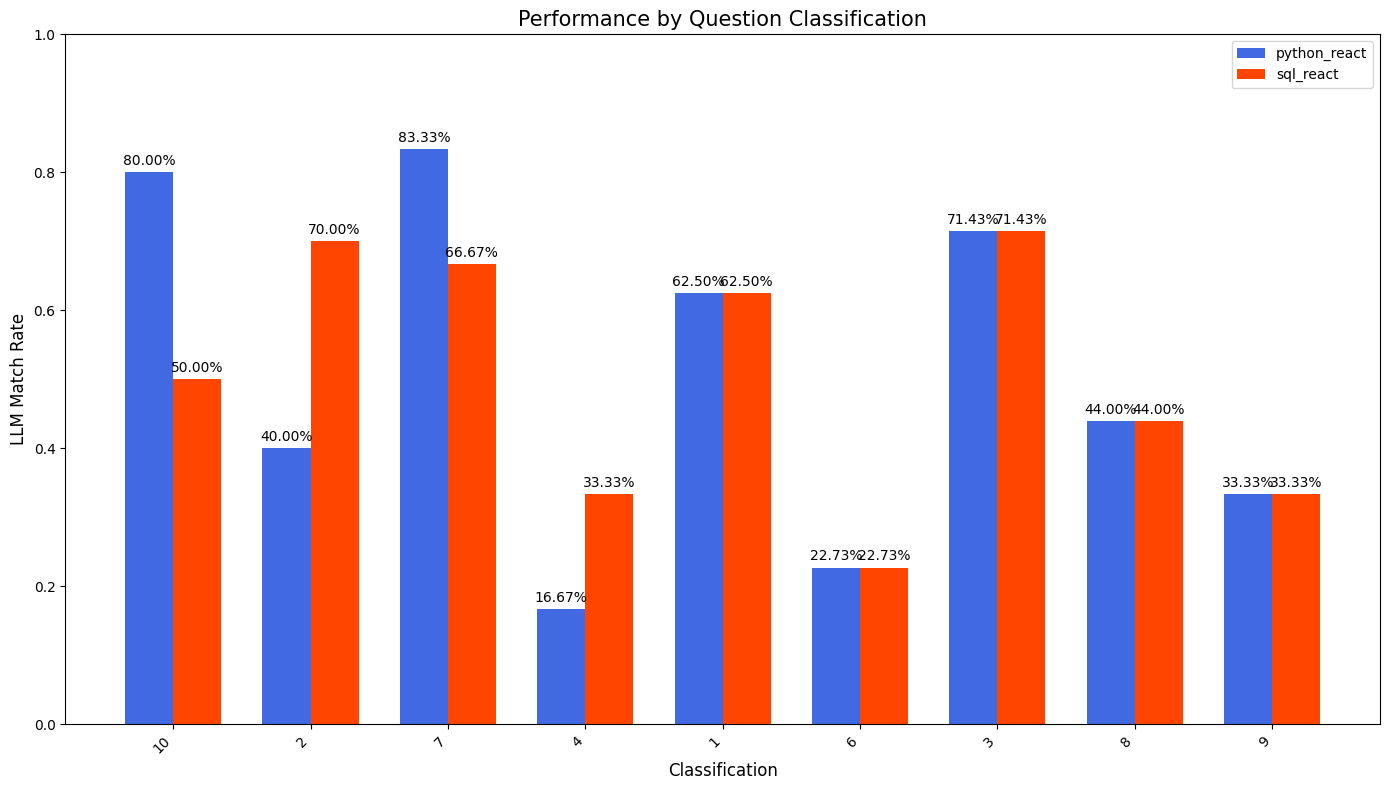

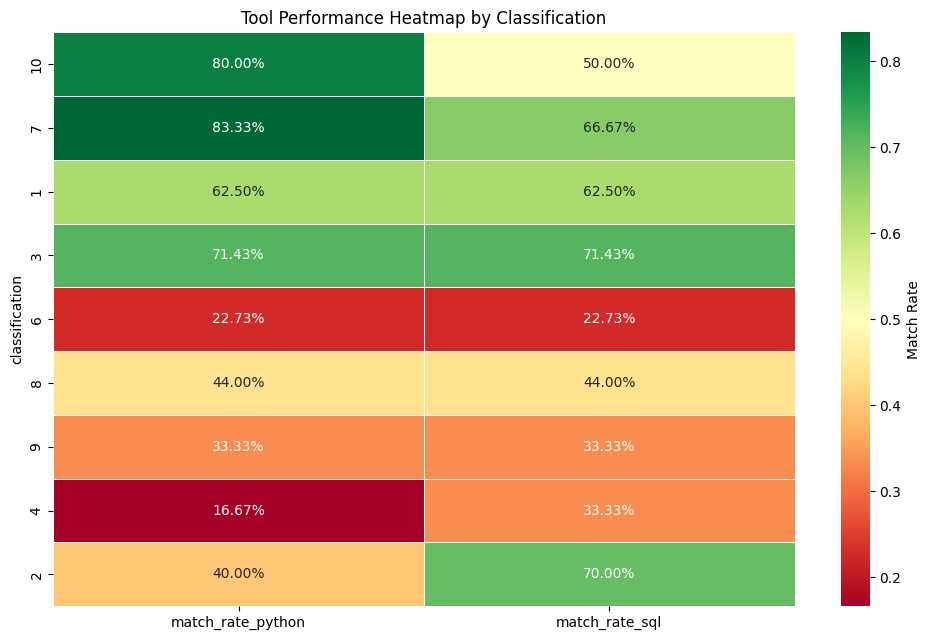

/tmp/ipykernel_53561/1330797052.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_53561/1330797052.py:101: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  ax = sns.barplot(


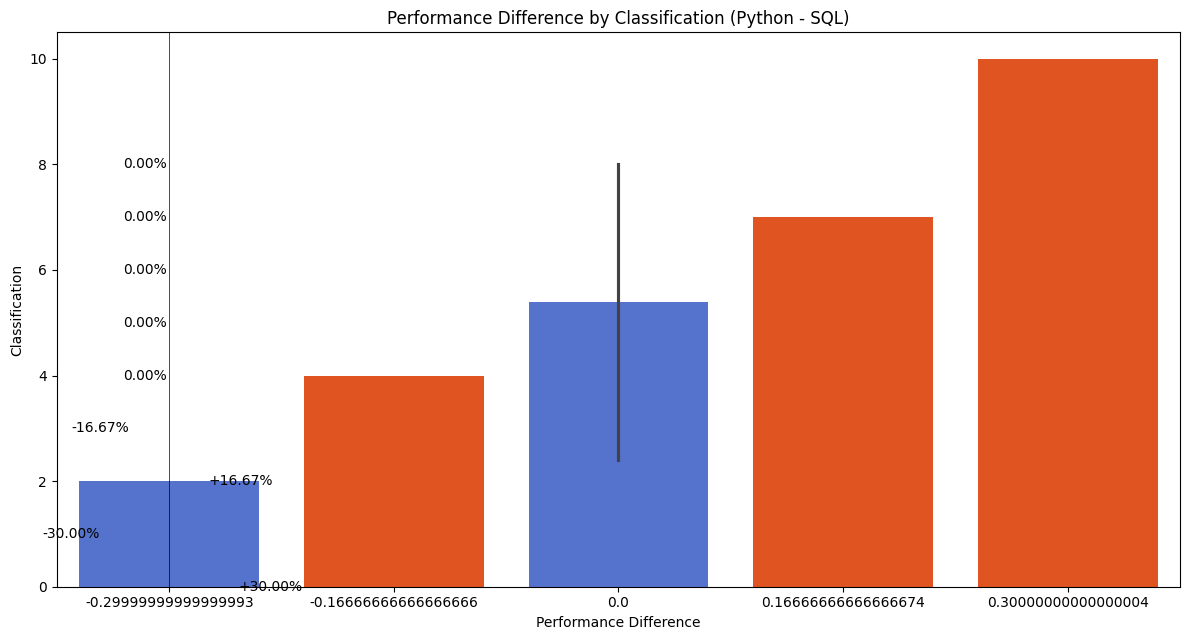

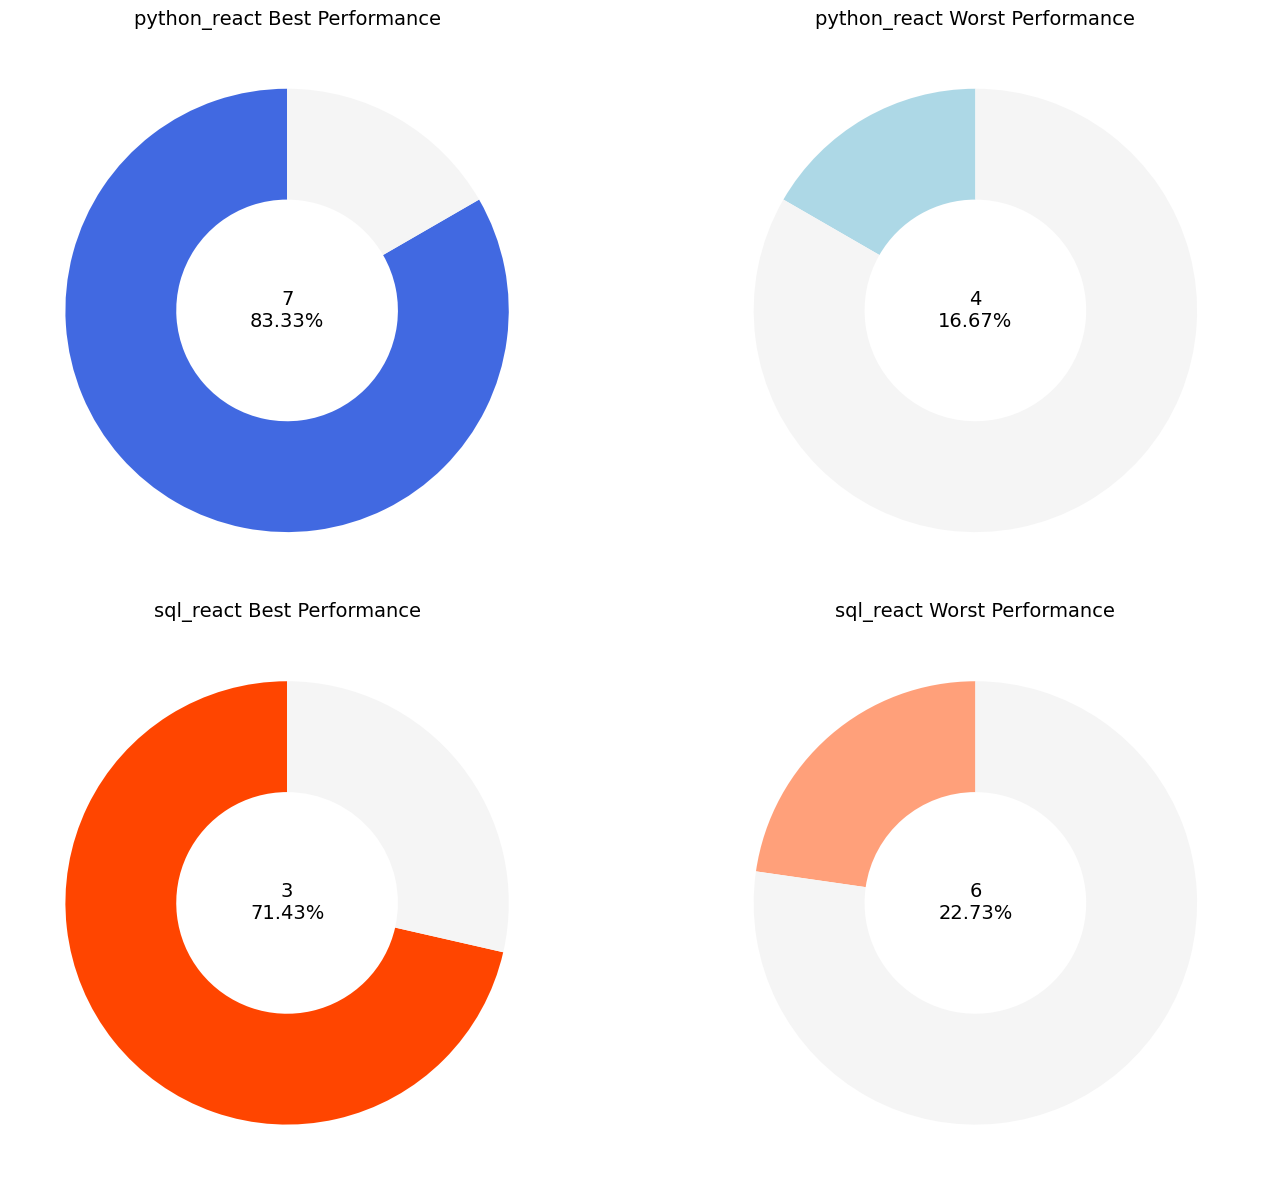

In [21]:
# 질문 유형별 성능 시각화 개선 코드
if 'classification' in combined_df.columns:
    # 각 도구별 질문 유형 성능 계산
    python_class_perf = combined_df[combined_df['agent_type'] == python_agent_type].groupby('classification').agg({
        'llm_match': ['mean', 'count']
    })
    python_class_perf.columns = ['match_rate', 'count']
    python_class_perf = python_class_perf[python_class_perf['count'] >= 5]  # 샘플이 5개 이상인 유형만 포함
    
    sql_class_perf = combined_df[combined_df['agent_type'] == sql_agent_type].groupby('classification').agg({
        'llm_match': ['mean', 'count']
    })
    sql_class_perf.columns = ['match_rate', 'count']
    sql_class_perf = sql_class_perf[sql_class_perf['count'] >= 5]  # 샘플이 5개 이상인 유형만 포함
    
    # 두 도구의 성능 비교를 위한 데이터프레임 생성
    class_comparison = pd.merge(
        python_class_perf.reset_index()[['classification', 'match_rate']], 
        sql_class_perf.reset_index()[['classification', 'match_rate']], 
        on='classification', 
        suffixes=('_python', '_sql')
    )
    
    # 차이 계산
    class_comparison['difference'] = class_comparison['match_rate_python'] - class_comparison['match_rate_sql']
    class_comparison['abs_difference'] = class_comparison['difference'].abs()  # abs() 메서드 사용
    class_comparison['better_tool'] = class_comparison['difference'].apply(
        lambda x: python_agent_type if x > 0 else sql_agent_type
    )
    
    # 1. 도구별 성능 비교 막대 차트
    # 데이터 준비
    class_comparison_sorted = class_comparison.sort_values(by='abs_difference', ascending=False)
    classifications = class_comparison_sorted['classification']
    python_rates = class_comparison_sorted['match_rate_python']
    sql_rates = class_comparison_sorted['match_rate_sql']
    
    # 위치 설정
    x = np.arange(len(classifications))
    width = 0.35
    
    # 그래프 생성
    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width/2, python_rates, width, label=f'{python_agent_type}', color='royalblue')
    rects2 = ax.bar(x + width/2, sql_rates, width, label=f'{sql_agent_type}', color='orangered')
    
    # 그래프 세부 설정
    ax.set_title('Performance by Question Classification', fontsize=15)
    ax.set_xlabel('Classification', fontsize=12)
    ax.set_ylabel('LLM Match Rate', fontsize=12)
    ax.set_ylim(0, 1.0)
    ax.set_xticks(x)
    ax.set_xticklabels(classifications, rotation=45, ha='right')
    ax.legend()
    
    # 막대 위에 값 표시
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2%}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.show()
    
    # 2. 성능 차이 히트맵
    # 데이터 준비
    pivot_data = pd.pivot_table(
        class_comparison_sorted,
        values=['match_rate_python', 'match_rate_sql', 'difference'],
        index='classification'
    ).sort_values(by='difference', ascending=False)
    
    # 히트맵 생성
    plt.figure(figsize=(10, len(pivot_data) * 0.5 + 2))
    sns.heatmap(
        pivot_data[['match_rate_python', 'match_rate_sql']],
        annot=True, 
        cmap='RdYlGn', 
        fmt='.2%',
        linewidths=.5,
        cbar_kws={'label': 'Match Rate'}
    )
    plt.title('Tool Performance Heatmap by Classification')
    plt.tight_layout()
    plt.show()
    
    # 3. 성능 차이 및 최적 도구 시각화
    plt.figure(figsize=(12, len(class_comparison_sorted) * 0.5 + 2))
    
    # 색상 설정: 파이썬이 더 좋으면 파란색, SQL이 더 좋으면 빨간색
    colors = ['royalblue' if diff > 0 else 'orangered' for diff in class_comparison_sorted['difference']]
    
    # 성능 차이 차트
    ax = sns.barplot(
        x='difference', 
        y='classification', 
        data=class_comparison_sorted,
        palette=colors
    )
    
    # 0 위치에 수직선 추가
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # 차트 세부 설정
    plt.title('Performance Difference by Classification (Python - SQL)')
    plt.xlabel('Performance Difference')
    plt.ylabel('Classification')
    
    # 막대 옆에 차이 값 표시
    for i, v in enumerate(class_comparison_sorted['difference']):
        if v > 0:
            ax.text(v + 0.01, i, f"+{v:.2%}", ha='left', va='center')
        else:
            ax.text(v - 0.01, i, f"{v:.2%}", ha='right', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # 4. 최고/최저 성능 질문 유형에 대한 요약 도넛 차트
    # 파이썬과 SQL의 최고 및 최저 성능 질문 유형 식별
    python_best_class = python_class_perf.sort_values('match_rate', ascending=False).index[0]
    python_worst_class = python_class_perf.sort_values('match_rate').index[0]
    sql_best_class = sql_class_perf.sort_values('match_rate', ascending=False).index[0]
    sql_worst_class = sql_class_perf.sort_values('match_rate').index[0]
    
    # 요약 데이터 생성
    summary_data = pd.DataFrame({
        'Tool': [f'{python_agent_type}', f'{python_agent_type}', f'{sql_agent_type}', f'{sql_agent_type}'],
        'Performance': ['Best', 'Worst', 'Best', 'Worst'],
        'Classification': [python_best_class, python_worst_class, sql_best_class, sql_worst_class],
        'Match Rate': [
            python_class_perf.loc[python_best_class, 'match_rate'],
            python_class_perf.loc[python_worst_class, 'match_rate'],
            sql_class_perf.loc[sql_best_class, 'match_rate'],
            sql_class_perf.loc[sql_worst_class, 'match_rate']
        ]
    })
    
    # 2x2 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 도넛 차트 색상 설정
    colors = {
        f'{python_agent_type}_Best': 'royalblue',
        f'{python_agent_type}_Worst': 'lightblue',
        f'{sql_agent_type}_Best': 'orangered',
        f'{sql_agent_type}_Worst': 'lightsalmon'
    }
    
    # 각 도구/성능 조합에 대한 도넛 차트 생성
    for i, ((tool, performance), subset) in enumerate(summary_data.groupby(['Tool', 'Performance'])):
        row, col = i // 2, i % 2
        ax = axes[row, col]
        
        # 도넛 차트 데이터 (매치 비율과 나머지)
        match_rate = subset['Match Rate'].values[0]
        values = [match_rate, 1 - match_rate]
        
        # 도넛 차트 생성
        wedges, texts = ax.pie(
            values, 
            wedgeprops=dict(width=0.5),
            startangle=90,
            colors=[colors[f"{tool}_{performance}"], "whitesmoke"]
        )
        
        # 중앙 텍스트 추가
        classification = subset['Classification'].values[0]
        ax.text(0, 0, f"{classification}\n{match_rate:.2%}", ha='center', va='center', fontsize=14)
        
        # 제목 설정
        ax.set_title(f"{tool} {performance} Performance", fontsize=14)
    
    plt.tight_layout()
    plt.show()


=== Token Budget Analysis ===
Token usage by success/fail status:
         Category  Avg Total Tokens  Avg Prompt Tokens  Avg Completion Tokens  \
0  Python Success      23620.413043       22196.652174            1423.760870   
1     Python Fail      25838.129630       24645.814815            1192.314815   
2     SQL Success      16990.913043       16367.608696             623.304348   
3        SQL Fail      18988.796296       18290.648148             698.148148   

   Avg Turns  Count  
0   7.869565     46  
1   8.814815     54  
2   7.391304     46  
3   7.759259     54  


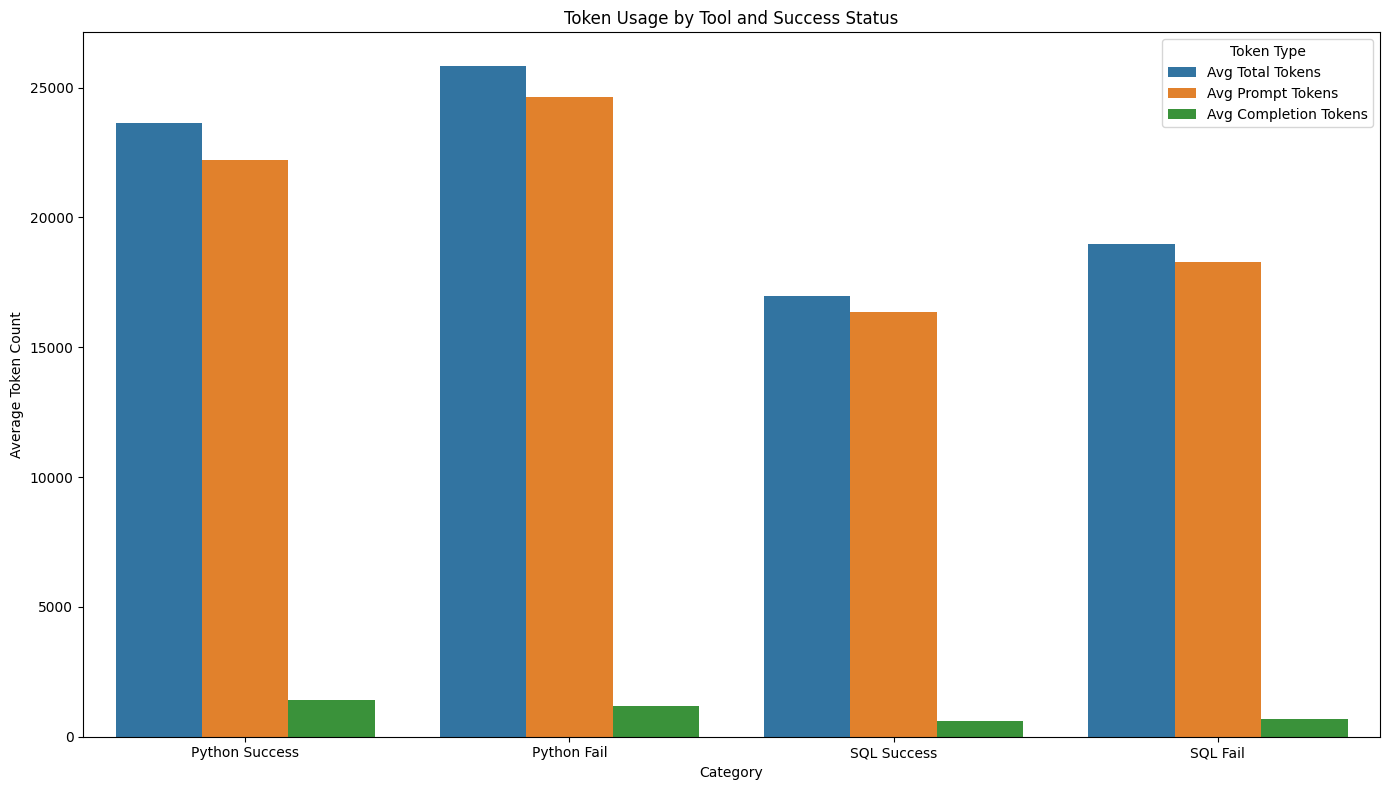


Token efficiency (tokens per correct answer):
           Tool  Tokens per Correct Answer
0  python_react               53952.130435
1     sql_react               39282.108696


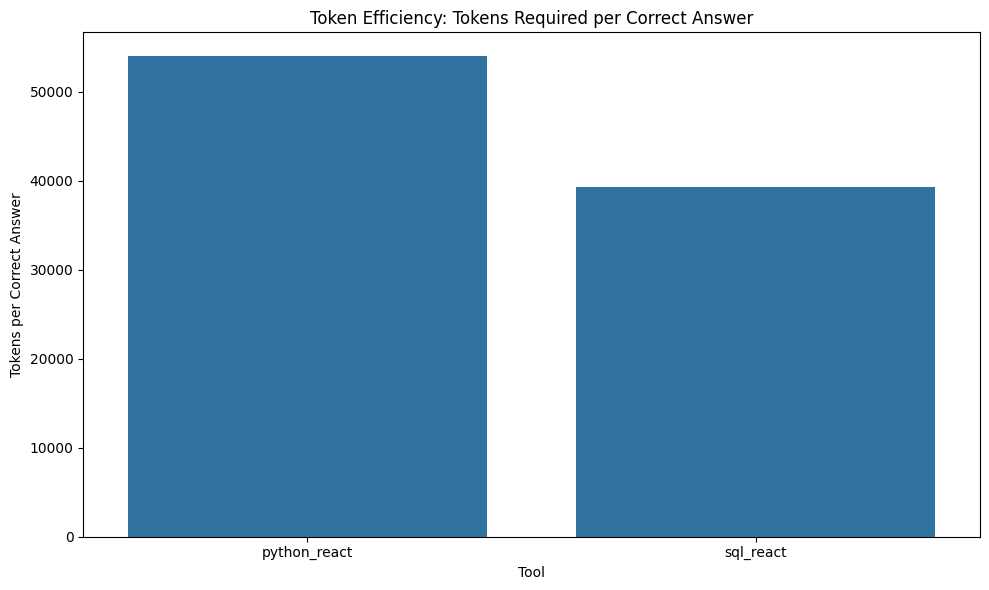


Token usage by number of tables:
     agent_type table_num  total_tokens  llm_match  count
0  python_react                24817.98       0.46    100
1     sql_react                18069.77       0.46    100


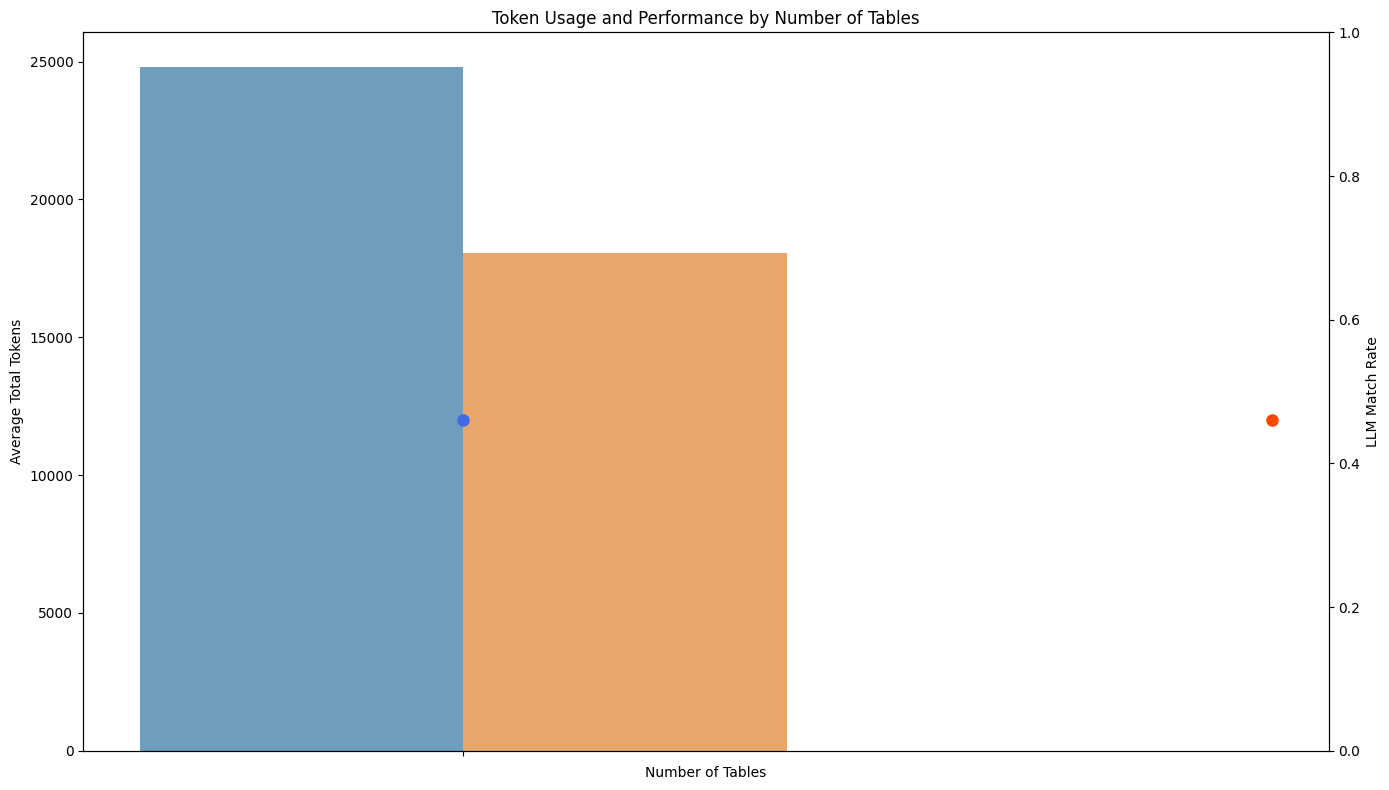


Question types where Python is more token-efficient (lower is better):
agent_type  classification  efficiency_diff
0                       10       -13103.025
1                        7        -5015.150

Question types where SQL is more token-efficient (lower is better):
agent_type  classification  efficiency_diff
2                        9      9926.500000
3                        8     13658.272727
4                        6     19757.000000
5                        3     21396.800000
6                        2     23918.357143
7                        1     34945.400000
8                        4    102648.000000


/tmp/ipykernel_53561/1498267172.py:216: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_53561/1498267172.py:238: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


ValueError: Image size of 11981739x586 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1200x650 with 1 Axes>

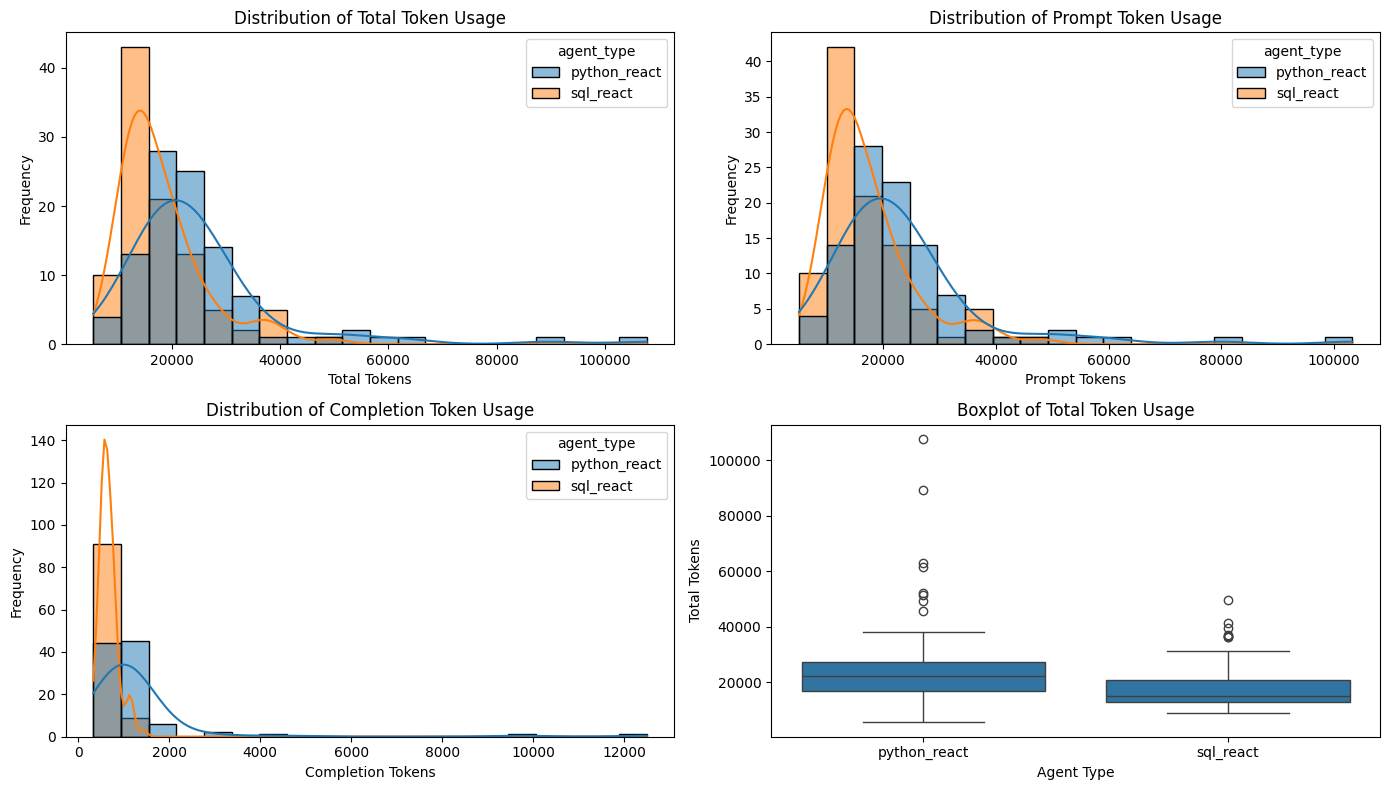

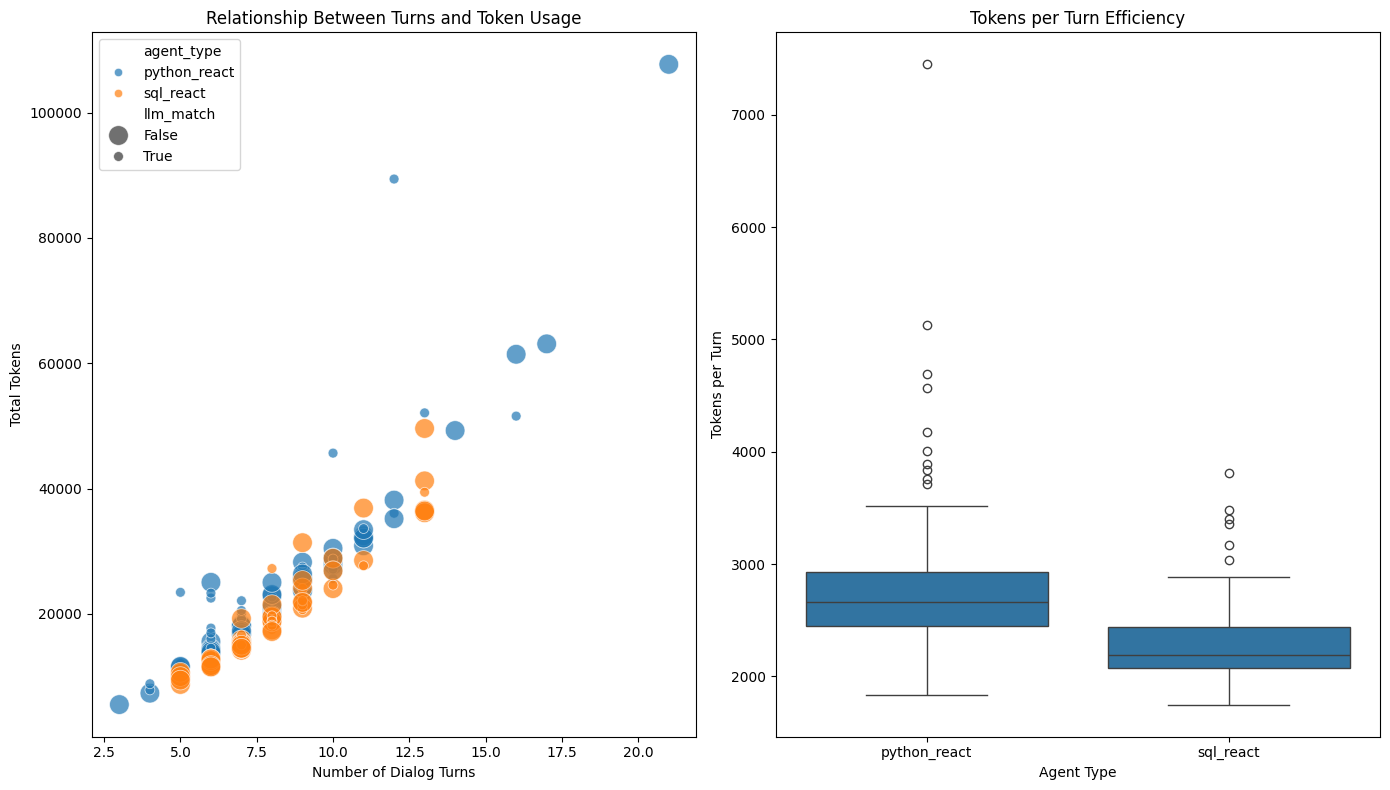


Token usage summary statistics:
              avg_tokens  median_tokens    std_tokens  min_tokens  max_tokens  \
agent_type                                                                      
python_react    24817.98        22429.0  14785.221657        5528      107710   
sql_react       18069.77        15222.0   7792.768528        8740       49593   

              total_tokens  avg_prompt_tokens  total_prompt_tokens  \
agent_type                                                           
python_react       2481798           23519.20              2351920   
sql_react          1806977           17406.05              1740605   

              avg_completion_tokens  total_completion_tokens  sample_count  \
agent_type                                                                   
python_react                1298.78                   129878           100   
sql_react                    663.72                    66372           100   

              prompt_to_completion_ratio  
agent

/tmp/ipykernel_53561/1498267172.py:343: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total = prompt_tokens[i] + completion_tokens[i]


<Figure size 1200x600 with 0 Axes>

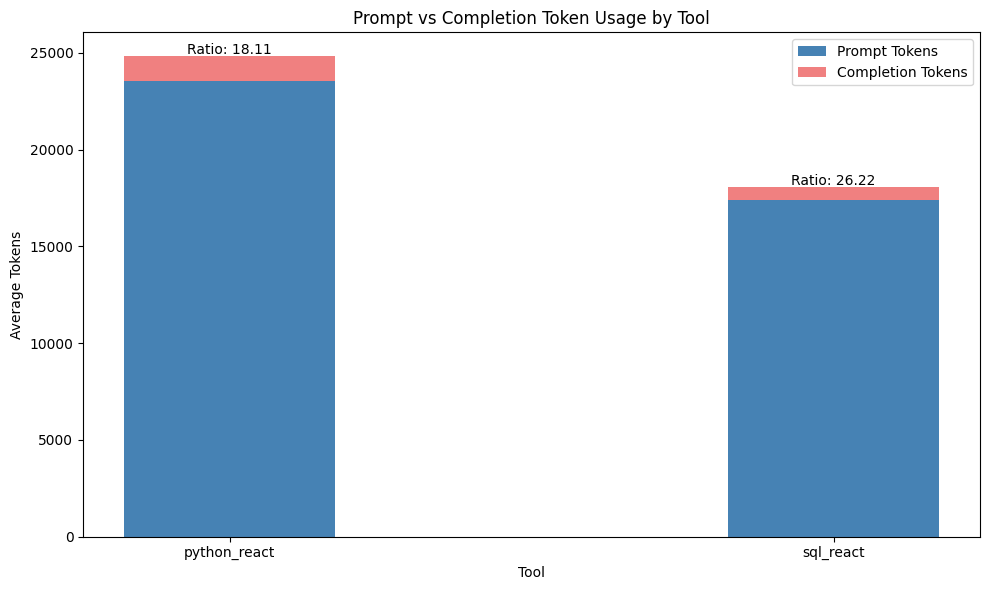

In [23]:
# 토큰 사용량 심층 분석
if 'total_tokens' in combined_df.columns and 'total_prompt_tokens' in combined_df.columns and 'total_completion_tokens' in combined_df.columns:
    print("\n=== Token Budget Analysis ===")
    
    # 1. 성공/실패 케이스별 토큰 사용량 분석
    python_success = combined_df[(combined_df['agent_type'] == python_agent_type) & (combined_df['llm_match'] == True)]
    python_fail = combined_df[(combined_df['agent_type'] == python_agent_type) & (combined_df['llm_match'] == False)]
    sql_success = combined_df[(combined_df['agent_type'] == sql_agent_type) & (combined_df['llm_match'] == True)]
    sql_fail = combined_df[(combined_df['agent_type'] == sql_agent_type) & (combined_df['llm_match'] == False)]
    
    token_success_fail = pd.DataFrame({
        'Category': ['Python Success', 'Python Fail', 'SQL Success', 'SQL Fail'],
        'Avg Total Tokens': [
            python_success['total_tokens'].mean(),
            python_fail['total_tokens'].mean(),
            sql_success['total_tokens'].mean(),
            sql_fail['total_tokens'].mean()
        ],
        'Avg Prompt Tokens': [
            python_success['total_prompt_tokens'].mean(),
            python_fail['total_prompt_tokens'].mean(),
            sql_success['total_prompt_tokens'].mean(),
            sql_fail['total_prompt_tokens'].mean()
        ],
        'Avg Completion Tokens': [
            python_success['total_completion_tokens'].mean(),
            python_fail['total_completion_tokens'].mean(),
            sql_success['total_completion_tokens'].mean(),
            sql_fail['total_completion_tokens'].mean()
        ],
        'Avg Turns': [
            python_success['total_turns'].mean(),
            python_fail['total_turns'].mean(),
            sql_success['total_turns'].mean(),
            sql_fail['total_turns'].mean()
        ],
        'Count': [
            len(python_success),
            len(python_fail),
            len(sql_success),
            len(sql_fail)
        ]
    })
    
    print("Token usage by success/fail status:")
    print(token_success_fail)
    
    # 시각화: 성공/실패 케이스별 토큰 사용량
    plt.figure(figsize=(14, 8))
    
    # 데이터 준비
    token_data_melted = pd.melt(
        token_success_fail, 
        id_vars=['Category'], 
        value_vars=['Avg Total Tokens', 'Avg Prompt Tokens', 'Avg Completion Tokens'],
        var_name='Token Type', 
        value_name='Average Tokens'
    )
    
    # 그룹 막대 차트
    sns.barplot(x='Category', y='Average Tokens', hue='Token Type', data=token_data_melted)
    plt.title('Token Usage by Tool and Success Status')
    plt.xlabel('Category')
    plt.ylabel('Average Token Count')
    plt.xticks(rotation=0)
    plt.legend(title='Token Type')
    plt.tight_layout()
    plt.show()
    
    # 2. 토큰 효율성 분석 (정답당 사용된 토큰)
    token_efficiency = pd.DataFrame({
        'Tool': [python_agent_type, sql_agent_type],
        'Correct Answers': [python_success['llm_match'].count(), sql_success['llm_match'].count()],
        'Total Tokens Used': [
            combined_df[combined_df['agent_type'] == python_agent_type]['total_tokens'].sum(),
            combined_df[combined_df['agent_type'] == sql_agent_type]['total_tokens'].sum()
        ]
    })
    
    token_efficiency['Tokens per Correct Answer'] = token_efficiency['Total Tokens Used'] / token_efficiency['Correct Answers']
    
    print("\nToken efficiency (tokens per correct answer):")
    print(token_efficiency[['Tool', 'Tokens per Correct Answer']])
    
    # 시각화: 토큰 효율성
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Tool', y='Tokens per Correct Answer', data=token_efficiency)
    plt.title('Token Efficiency: Tokens Required per Correct Answer')
    plt.xlabel('Tool')
    plt.ylabel('Tokens per Correct Answer')
    plt.tight_layout()
    plt.show()
    
    # 3. 테이블 수에 따른 토큰 사용량 분석
    token_by_tables = combined_df.groupby(['agent_type', 'table_num']).agg({
        'total_tokens': 'mean',
        'total_prompt_tokens': 'mean',
        'total_completion_tokens': 'mean',
        'llm_match': 'mean',  # 성능도 함께 보기
        'id': 'count'
    }).rename(columns={'id': 'count'}).reset_index()
    
    print("\nToken usage by number of tables:")
    print(token_by_tables[['agent_type', 'table_num', 'total_tokens', 'llm_match', 'count']])
    
    # 시각화: 테이블 수에 따른 토큰 사용량 및 성능
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # 토큰 사용량 (막대 차트)
    sns.barplot(
        x='table_num', 
        y='total_tokens', 
        hue='agent_type', 
        data=token_by_tables,
        alpha=0.7,
        ax=ax1
    )
    
    # y축 라벨
    ax1.set_ylabel('Average Total Tokens', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    
    # 두 번째 y축 생성
    ax2 = ax1.twinx()
    
    # 성능 (선 그래프)
    python_perf = token_by_tables[token_by_tables['agent_type'] == python_agent_type]
    sql_perf = token_by_tables[token_by_tables['agent_type'] == sql_agent_type]
    
    ax2.plot(
        python_perf.index, 
        python_perf['llm_match'], 
        'o-', 
        color='royalblue', 
        linewidth=2,
        markersize=8,
        label=f'{python_agent_type} Performance'
    )
    ax2.plot(
        sql_perf.index, 
        sql_perf['llm_match'], 
        'o-', 
        color='orangered', 
        linewidth=2,
        markersize=8,
        label=f'{sql_agent_type} Performance'
    )
    
    # y축 라벨 및 설정
    ax2.set_ylabel('LLM Match Rate', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylim(0, 1)
    
    # 그래프 제목 및 범례
    plt.title('Token Usage and Performance by Number of Tables')
    ax1.set_xlabel('Number of Tables')
    
    # 범례 통합
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
    
    # 원래 범례 제거
    ax1.get_legend().remove()
    
    plt.tight_layout()
    plt.show()
    
    # 4. 질문 유형에 따른 토큰 효율성 분석
    if 'classification' in combined_df.columns:
        token_class_efficiency = combined_df.groupby(['agent_type', 'classification']).agg({
            'total_tokens': ['mean', 'sum'],
            'llm_match': ['mean', 'sum'],
            'id': 'count'
        })
        
        # 열 이름 재설정
        token_class_efficiency.columns = ['avg_tokens', 'total_tokens', 'accuracy', 'correct_count', 'sample_count']
        
        # 정답당 토큰 계산
        token_class_efficiency['tokens_per_correct'] = token_class_efficiency['total_tokens'] / token_class_efficiency['correct_count']
        token_class_efficiency = token_class_efficiency.reset_index()
        
        # 질문 유형별로 Python과 SQL 간의 토큰 효율성 차이 계산
        efficiency_diff = token_class_efficiency.pivot_table(
            index='classification', 
            columns='agent_type', 
            values='tokens_per_correct'
        )
        
        # Python 효율성 - SQL 효율성 (음수이면 Python이 더 효율적)
        efficiency_diff['efficiency_diff'] = efficiency_diff[python_agent_type] - efficiency_diff[sql_agent_type]
        efficiency_diff = efficiency_diff.sort_values('efficiency_diff').reset_index()
        
        print("\nQuestion types where Python is more token-efficient (lower is better):")
        more_efficient_python = efficiency_diff[efficiency_diff['efficiency_diff'] < 0]
        if len(more_efficient_python) > 0:
            print(more_efficient_python[['classification', 'efficiency_diff']])
        else:
            print("None found.")
            
        print("\nQuestion types where SQL is more token-efficient (lower is better):")
        more_efficient_sql = efficiency_diff[efficiency_diff['efficiency_diff'] > 0]
        if len(more_efficient_sql) > 0:
            print(more_efficient_sql[['classification', 'efficiency_diff']])
        else:
            print("None found.")
        
        # 시각화: 질문 유형별 토큰 효율성
        plt.figure(figsize=(12, len(efficiency_diff) * 0.5 + 2))
        
        # 막대 색상 설정
        colors = ['royalblue' if diff < 0 else 'orangered' for diff in efficiency_diff['efficiency_diff']]
        
        # 효율성 차이 차트
        ax = sns.barplot(
            x='efficiency_diff', 
            y='classification', 
            data=efficiency_diff,
            palette=colors
        )
        
        # 0 위치에 수직선 추가
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        
        # 차트 세부 설정
        plt.title('Token Efficiency Difference by Classification (Python - SQL)')
        plt.xlabel('Token Efficiency Difference (Tokens per Correct Answer)')
        plt.ylabel('Classification')
        
        # 막대 옆에 차이 값 표시
        for i, v in enumerate(efficiency_diff['efficiency_diff']):
            if v < 0:  # Python이 더 효율적
                ax.text(v - 100, i, f"{v:.0f}", ha='right', va='center')
            else:  # SQL이 더 효율적
                ax.text(v + 100, i, f"+{v:.0f}", ha='left', va='center')
        
        plt.tight_layout()
        plt.show()
    
    # 5. 토큰 사용 분포 시각화
    plt.figure(figsize=(14, 8))
    
    # 도구별 토큰 사용 분포
    plt.subplot(2, 2, 1)
    sns.histplot(data=combined_df, x='total_tokens', hue='agent_type', kde=True, bins=20)
    plt.title('Distribution of Total Token Usage')
    plt.xlabel('Total Tokens')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 2)
    sns.histplot(data=combined_df, x='total_prompt_tokens', hue='agent_type', kde=True, bins=20)
    plt.title('Distribution of Prompt Token Usage')
    plt.xlabel('Prompt Tokens')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 3)
    sns.histplot(data=combined_df, x='total_completion_tokens', hue='agent_type', kde=True, bins=20)
    plt.title('Distribution of Completion Token Usage')
    plt.xlabel('Completion Tokens')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 4)
    sns.boxplot(data=combined_df, x='agent_type', y='total_tokens')
    plt.title('Boxplot of Total Token Usage')
    plt.xlabel('Agent Type')
    plt.ylabel('Total Tokens')
    
    plt.tight_layout()
    plt.show()
    
    # 6. 토큰 사용량과 대화 턴수 관계 및 효율성
    plt.figure(figsize=(14, 8))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        data=combined_df, 
        x='total_turns', 
        y='total_tokens', 
        hue='agent_type', 
        size='llm_match',
        sizes=(50, 200),
        alpha=0.7
    )
    plt.title('Relationship Between Turns and Token Usage')
    plt.xlabel('Number of Dialog Turns')
    plt.ylabel('Total Tokens')
    
    # 토큰 효율성: 턴당 토큰 수
    combined_df['tokens_per_turn'] = combined_df['total_tokens'] / combined_df['total_turns']
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=combined_df, x='agent_type', y='tokens_per_turn')
    plt.title('Tokens per Turn Efficiency')
    plt.xlabel('Agent Type')
    plt.ylabel('Tokens per Turn')
    
    plt.tight_layout()
    plt.show()
    
    # 7. 토큰 사용량 요약 통계
    token_summary = combined_df.groupby('agent_type').agg({
        'total_tokens': ['mean', 'median', 'std', 'min', 'max', 'sum'],
        'total_prompt_tokens': ['mean', 'sum'],
        'total_completion_tokens': ['mean', 'sum'],
        'id': 'count'
    })
    
    # 열 이름 재설정
    token_summary.columns = [
        'avg_tokens', 'median_tokens', 'std_tokens', 'min_tokens', 'max_tokens', 'total_tokens',
        'avg_prompt_tokens', 'total_prompt_tokens',
        'avg_completion_tokens', 'total_completion_tokens',
        'sample_count'
    ]
    
    # 프롬프트 대 완성 비율 계산
    token_summary['prompt_to_completion_ratio'] = token_summary['avg_prompt_tokens'] / token_summary['avg_completion_tokens']
    
    print("\nToken usage summary statistics:")
    print(token_summary)
    
    # 추가 인사이트: 프롬프트와 완성 토큰 비율
    plt.figure(figsize=(12, 6))
    
    # 데이터 준비
    tools = token_summary.index
    prompt_tokens = token_summary['avg_prompt_tokens']
    completion_tokens = token_summary['avg_completion_tokens']
    
    x = np.arange(len(tools))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 막대 그래프 생성
    ax.bar(x, prompt_tokens, width, label='Prompt Tokens', color='steelblue')
    ax.bar(x, completion_tokens, width, bottom=prompt_tokens, label='Completion Tokens', color='lightcoral')
    
    # 비율 텍스트 추가
    for i, tool in enumerate(tools):
        ratio = token_summary.loc[tool, 'prompt_to_completion_ratio']
        total = prompt_tokens[i] + completion_tokens[i]
        ax.text(i, total + 100, f'Ratio: {ratio:.2f}', ha='center')
    
    # 그래프 세부 설정
    ax.set_title('Prompt vs Completion Token Usage by Tool')
    ax.set_xlabel('Tool')
    ax.set_ylabel('Average Tokens')
    ax.set_xticks(x)
    ax.set_xticklabels(tools)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

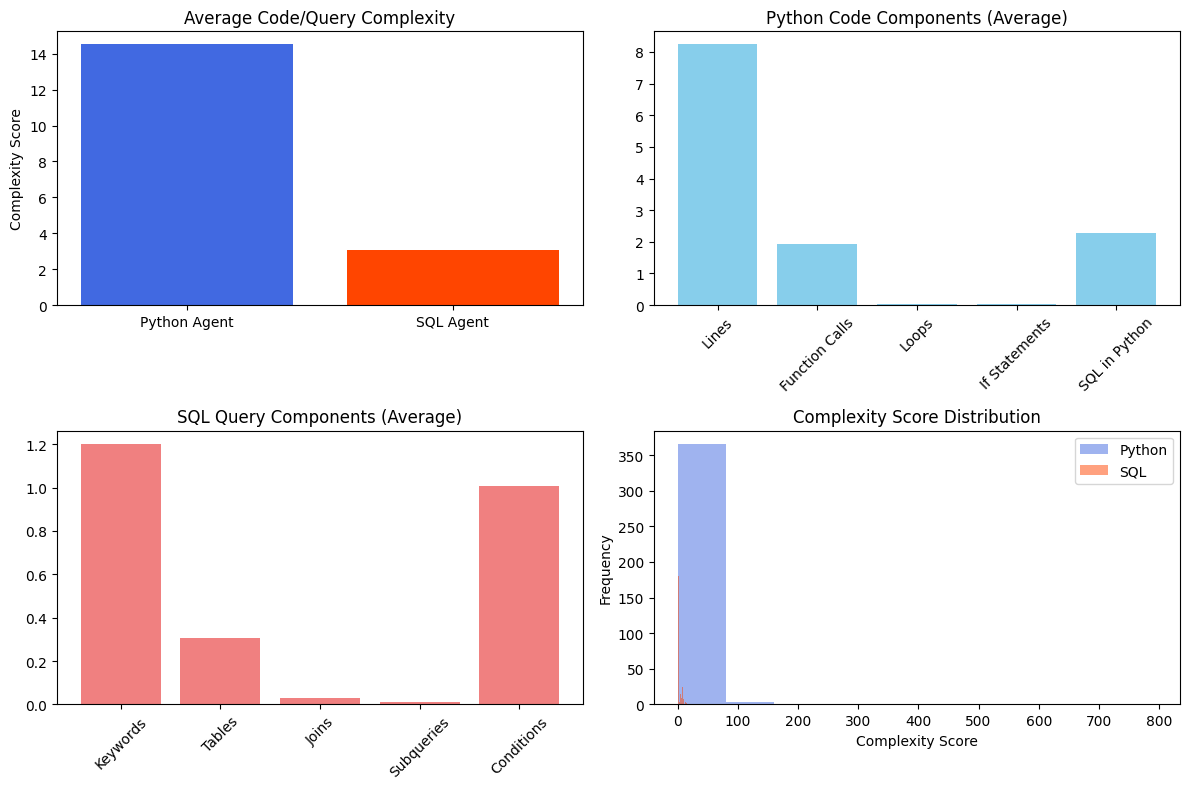

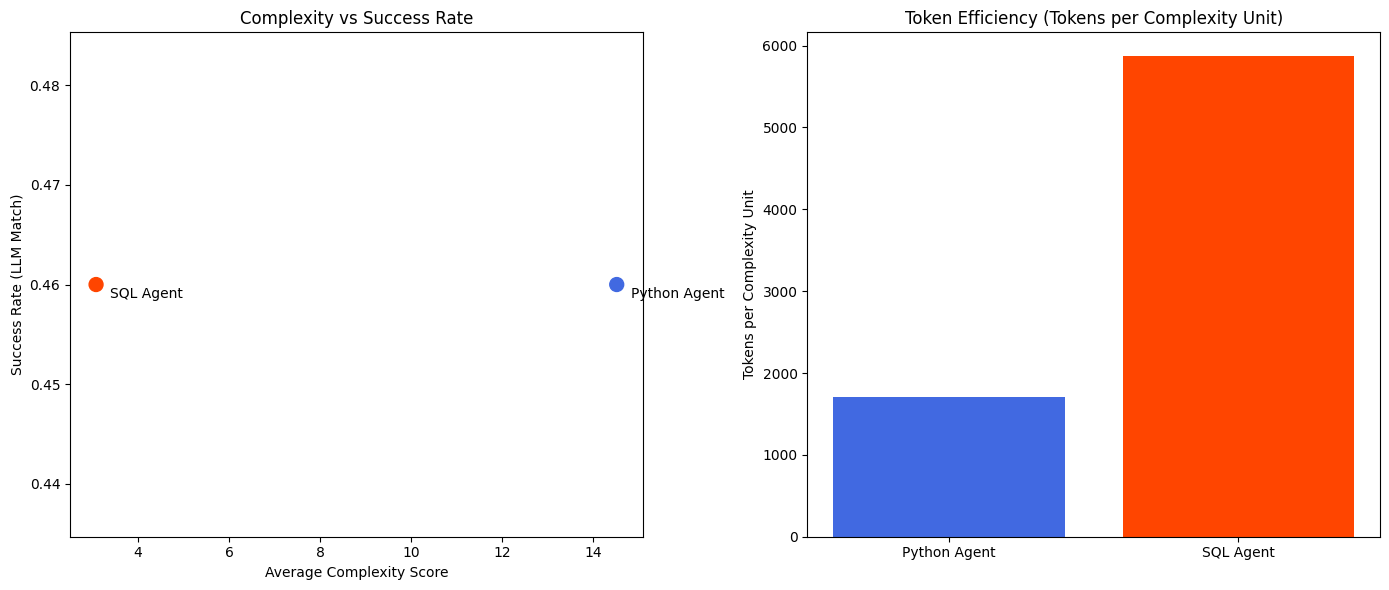


=== Code/Query Complexity Analysis ===
Python Agent: Analyzed 370 code blocks
SQL Agent: Analyzed 266 queries

Average Complexity Scores:
Python Agent: 14.52
SQL Agent: 3.08

Performance vs Complexity:
          Agent  Avg Complexity  Success Rate  Avg Tokens  \
0  Python Agent       14.519838          0.46    24817.98   
1     SQL Agent        3.079060          0.46    18069.77   

   Tokens per Complexity  
0            1709.246362  
1            5868.599221  


({'python_code': ['db_connector.execute_query("SELECT name FROM sqlite_master WHERE type=\'table\';")',
   'tables = db_connector.execute_query("SELECT name FROM sqlite_master WHERE type=\'table\';")\n_result = tables',
   '# First, explore the database to find the relevant tables\nshow_tables_query = "SHOW TABLES"\ntables = db_connector.execute_query(show_tables_query)\ntables_list = tables[\'Tables_in_database\'].tolist()\ntables_list',
   '# The initial approach resulted in an error because the column name used was incorrect or unexpected.\n# Instead of assuming the column name, let\'s print the entire results of the query\n# and check the columns to derive the correct approach to access the column with table names.\n\n# Re-running the query to list all tables and reviewing the results\nshow_tables_query = "SHOW TABLES"\ntables = db_connector.execute_query(show_tables_query)\n_result = tables',
   '# The SQL syntax used was incorrect. Let\'s adapt the code using the correct method f

In [26]:
# 코드/쿼리 복잡성 분석을 위한 함수
import re
import ast
import statistics
from collections import Counter

def extract_python_code_blocks(history):
    """
    Python 에이전트 대화 히스토리에서 Python 코드 블록 추출
    """
    code_blocks = []
    
    for turn in history:
        if turn.get('role') == 'tool-call':
            content = turn.get('content', [])
            if isinstance(content, list):
                for item in content:
                    if isinstance(item, dict) and 'text' in item:
                        text = item['text']
                        # Python 코드 패턴 찾기
                        if "function': {'name': 'python'" in text and "'arguments': {'code':" in text:
                            # 코드 추출
                            code_match = re.search(r"'code': '(.+?)'}}", text, re.DOTALL)
                            if code_match:
                                code = code_match.group(1)
                                # 이스케이프된 문자 처리
                                code = code.replace('\\n', '\n').replace("\\'", "'").replace('\\"', '"')
                                code_blocks.append(code)
    
    return code_blocks

def extract_sql_queries(history):
    """
    SQL 에이전트 대화 히스토리에서 SQL 쿼리 추출
    """
    sql_queries = []
    
    for turn in history:
        if turn.get('role') == 'tool-call':
            content = turn.get('content', [])
            if isinstance(content, list):
                for item in content:
                    if isinstance(item, dict) and 'text' in item:
                        text = item['text']
                        # SQL 쿼리 패턴 찾기
                        if "function': {'name': 'sql'" in text and "'arguments': {'query':" in text:
                            # 쿼리 추출
                            query_match = re.search(r"'query': '(.+?)'}}", text, re.DOTALL)
                            if query_match:
                                query = query_match.group(1)
                                # 이스케이프된 문자 처리
                                query = query.replace('\\n', '\n').replace("\\'", "'").replace('\\"', '"')
                                sql_queries.append(query)
    
    return sql_queries

def calculate_python_complexity(code):
    """
    Python 코드의 복잡성 계산
    """
    # 코드 길이
    length = len(code)
    
    # 라인 수
    lines = code.count('\n') + 1
    
    try:
        # AST를 사용하여 코드 구조 분석
        tree = ast.parse(code)
        
        # 함수 개수
        function_count = sum(1 for node in ast.walk(tree) if isinstance(node, ast.FunctionDef))
        
        # 루프 개수 (for, while)
        loop_count = sum(1 for node in ast.walk(tree) if isinstance(node, (ast.For, ast.While)))
        
        # 조건문 개수 (if, elif, else)
        if_count = sum(1 for node in ast.walk(tree) if isinstance(node, ast.If))
        
        # 변수 할당 개수
        assign_count = sum(1 for node in ast.walk(tree) if isinstance(node, ast.Assign))
        
        # 함수 호출 개수
        call_count = sum(1 for node in ast.walk(tree) if isinstance(node, ast.Call))
        
        # SQL 관련 코드 확인
        sql_keywords = ['SELECT', 'FROM', 'WHERE', 'JOIN', 'GROUP BY', 'ORDER BY']
        sql_count = sum(1 for kw in sql_keywords if kw in code.upper())
        
        # 복잡성 점수 계산
        complexity_score = (
            length * 0.01 +                  # 길이에 작은 가중치
            lines * 0.2 +                    # 라인 수에 작은-중간 가중치
            function_count * 1.5 +           # 함수에 중간-높은 가중치
            loop_count * 2.0 +               # 루프에 높은 가중치
            if_count * 1.0 +                 # 조건문에 중간 가중치
            assign_count * 0.5 +             # 변수 할당에 중간-낮은 가중치
            call_count * 0.8 +               # 함수 호출에 중간-낮은 가중치
            sql_count * 1.2                  # SQL 쿼리에 중간-높은 가중치
        )
        
        return {
            'length': length,
            'lines': lines,
            'function_count': function_count,
            'loop_count': loop_count,
            'if_count': if_count,
            'assign_count': assign_count,
            'call_count': call_count,
            'sql_count': sql_count,
            'complexity_score': complexity_score,
            'has_error': False
        }
    
    except SyntaxError:
        # 구문 오류가 있는 경우 기본 지표만 반환
        return {
            'length': length,
            'lines': lines,
            'complexity_score': length * 0.1,
            'has_error': True
        }

def calculate_sql_complexity(query):
    """
    SQL 쿼리의 복잡성 계산
    """
    # 쿼리 길이
    length = len(query)
    
    # 라인 수
    lines = query.count('\n') + 1
    
    # 키워드 수
    keywords = ['SELECT', 'FROM', 'WHERE', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN', 
                'GROUP BY', 'HAVING', 'ORDER BY', 'LIMIT', 'UNION', 'INTERSECT', 'EXCEPT']
    keyword_count = sum(query.upper().count(kw) for kw in keywords)
    
    # 서브쿼리 개수 (대략적인 추정)
    subquery_count = query.upper().count('SELECT') - 1 if query.upper().count('SELECT') > 0 else 0
    
    # 테이블 개수 (FROM 절과 JOIN 절에서)
    tables = re.findall(r'FROM\s+(\w+)|JOIN\s+(\w+)', query.upper())
    table_count = len([t for t in tables if any(t)])
    
    # 조인 개수
    join_count = sum(1 for j in ['JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN'] if j in query.upper())
    
    # 집계 함수 개수
    agg_functions = ['COUNT', 'SUM', 'AVG', 'MIN', 'MAX', 'GROUP_CONCAT', 'STDDEV', 'VARIANCE']
    agg_count = sum(query.upper().count(func) for func in agg_functions)
    
    # 복잡한 조건식 개수 (AND, OR, NOT, IN, EXISTS)
    conditions = ['AND', 'OR', 'NOT', 'IN', 'EXISTS', 'LIKE', 'BETWEEN']
    condition_count = sum(query.upper().count(cond) for cond in conditions)
    
    # 복잡성 점수 계산
    complexity_score = (
        length * 0.01 +                  # 길이에 작은 가중치
        lines * 0.2 +                    # 라인 수에 작은-중간 가중치
        keyword_count * 1.0 +            # 키워드에 중간 가중치
        subquery_count * 2.5 +           # 서브쿼리에 높은 가중치
        table_count * 1.0 +              # 테이블 수에 중간 가중치
        join_count * 1.5 +               # 조인에 중간-높은 가중치
        agg_count * 1.2 +                # 집계 함수에 중간-높은 가중치
        condition_count * 0.8            # 조건식에 중간-낮은 가중치
    )
    
    return {
        'length': length,
        'lines': lines,
        'keyword_count': keyword_count,
        'subquery_count': subquery_count,
        'table_count': table_count,
        'join_count': join_count,
        'agg_count': agg_count,
        'condition_count': condition_count,
        'complexity_score': complexity_score
    }

# 코드 복잡성 분석 실행
def analyze_code_complexity(data_python, data_sql):
    """
    Python과 SQL 에이전트의 코드/쿼리 복잡성 분석
    """
    all_python_code = []
    all_sql_queries = []
    
    # Python 에이전트 코드 추출 및 분석
    for entry in data_python.get('evaluation_history', []):
        history = entry.get('history', [])
        python_code = extract_python_code_blocks(history)
        all_python_code.extend(python_code)
    
    # SQL 에이전트 쿼리 추출 및 분석
    for entry in data_sql.get('evaluation_history', []):
        history = entry.get('history', [])
        sql_queries = extract_sql_queries(history)
        all_sql_queries.extend(sql_queries)
    
    # 복잡성 계산
    python_complexity = [calculate_python_complexity(code) for code in all_python_code]
    sql_complexity = [calculate_sql_complexity(query) for query in all_sql_queries]
    
    # 결과 반환
    return {
        'python_code': all_python_code,
        'sql_queries': all_sql_queries,
        'python_complexity': python_complexity,
        'sql_complexity': sql_complexity
    }

# 분석 결과 시각화
def visualize_code_complexity(results):
    """
    코드 복잡성 분석 결과 시각화
    """
    python_complexity = results['python_complexity']
    sql_complexity = results['sql_complexity']
    
    # 평균 복잡성 점수
    python_avg_complexity = statistics.mean([p['complexity_score'] for p in python_complexity]) if python_complexity else 0
    sql_avg_complexity = statistics.mean([s['complexity_score'] for s in sql_complexity]) if sql_complexity else 0
    
    # 1. 복잡성 점수 비교 막대 차트
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    values = [python_avg_complexity, sql_avg_complexity]
    labels = ['Python Agent', 'SQL Agent']
    colors = ['royalblue', 'orangered']
    
    plt.bar(labels, values, color=colors)
    plt.title('Average Code/Query Complexity')
    plt.ylabel('Complexity Score')
    
    # 2. Python 코드 주요 구성 요소
    if python_complexity:
        plt.subplot(2, 2, 2)
        
        # 평균 값 계산
        avg_metrics = {
            'Lines': statistics.mean([p.get('lines', 0) for p in python_complexity]),
            'Function Calls': statistics.mean([p.get('call_count', 0) for p in python_complexity]),
            'Loops': statistics.mean([p.get('loop_count', 0) for p in python_complexity]),
            'If Statements': statistics.mean([p.get('if_count', 0) for p in python_complexity]),
            'SQL in Python': statistics.mean([p.get('sql_count', 0) for p in python_complexity])
        }
        
        plt.bar(avg_metrics.keys(), avg_metrics.values(), color='skyblue')
        plt.title('Python Code Components (Average)')
        plt.xticks(rotation=45)
        plt.tight_layout()
    
    # 3. SQL 쿼리 주요 구성 요소
    if sql_complexity:
        plt.subplot(2, 2, 3)
        
        # 평균 값 계산
        avg_metrics = {
            'Keywords': statistics.mean([s.get('keyword_count', 0) for s in sql_complexity]),
            'Tables': statistics.mean([s.get('table_count', 0) for s in sql_complexity]),
            'Joins': statistics.mean([s.get('join_count', 0) for s in sql_complexity]),
            'Subqueries': statistics.mean([s.get('subquery_count', 0) for s in sql_complexity]),
            'Conditions': statistics.mean([s.get('condition_count', 0) for s in sql_complexity])
        }
        
        plt.bar(avg_metrics.keys(), avg_metrics.values(), color='lightcoral')
        plt.title('SQL Query Components (Average)')
        plt.xticks(rotation=45)
        plt.tight_layout()
    
    # 4. 복잡성 분포 히스토그램
    plt.subplot(2, 2, 4)
    
    if python_complexity:
        python_scores = [p['complexity_score'] for p in python_complexity]
        plt.hist(python_scores, alpha=0.5, label='Python', color='royalblue', bins=10)
    
    if sql_complexity:
        sql_scores = [s['complexity_score'] for s in sql_complexity]
        plt.hist(sql_scores, alpha=0.5, label='SQL', color='orangered', bins=10)
    
    plt.title('Complexity Score Distribution')
    plt.xlabel('Complexity Score')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 복잡성과 성공률 관계 분석
    return {
        'python_avg_complexity': python_avg_complexity,
        'sql_avg_complexity': sql_avg_complexity,
        'python_code_count': len(python_complexity),
        'sql_query_count': len(sql_complexity)
    }

# 메인 분석 함수
def analyze_agents_code_complexity(python_data, sql_data, python_df, sql_df):
    """
    두 에이전트의 코드 복잡성 종합 분석
    """
    # 코드 복잡성 분석
    complexity_results = analyze_code_complexity(python_data, sql_data)
    
    # 결과 시각화
    viz_results = visualize_code_complexity(complexity_results)
    
    # 복잡성과 성능 관계 분석
    python_avg_complexity = viz_results['python_avg_complexity']
    sql_avg_complexity = viz_results['sql_avg_complexity']
    
    # 성능 대비 복잡성 분석 데이터프레임
    performance_df = pd.DataFrame({
        'Agent': ['Python Agent', 'SQL Agent'],
        'Avg Complexity': [python_avg_complexity, sql_avg_complexity],
        'Success Rate': [python_df['llm_match'].mean(), sql_df['llm_match'].mean()],
        'Avg Tokens': [python_df['total_tokens'].mean(), sql_df['total_tokens'].mean()],
        'Tokens per Complexity': [
            python_df['total_tokens'].mean() / (python_avg_complexity if python_avg_complexity > 0 else 1),
            sql_df['total_tokens'].mean() / (sql_avg_complexity if sql_avg_complexity > 0 else 1)
        ]
    })
    
    # 복잡성-성능 관계 시각화
    plt.figure(figsize=(14, 6))
    
    # 1. 복잡성 대비 성능
    plt.subplot(1, 2, 1)
    x = performance_df['Avg Complexity']
    y = performance_df['Success Rate']
    colors = ['royalblue', 'orangered']
    
    plt.scatter(x, y, s=100, c=colors)
    
    # 텍스트 라벨 추가
    for i, agent in enumerate(performance_df['Agent']):
        plt.annotate(agent, (x[i], y[i]), xytext=(10, -10), 
                     textcoords='offset points', fontsize=10)
    
    plt.title('Complexity vs Success Rate')
    plt.xlabel('Average Complexity Score')
    plt.ylabel('Success Rate (LLM Match)')
    
    # 2. 토큰 효율성 (복잡성 단위당 토큰)
    plt.subplot(1, 2, 2)
    plt.bar(performance_df['Agent'], performance_df['Tokens per Complexity'], color=colors)
    plt.title('Token Efficiency (Tokens per Complexity Unit)')
    plt.ylabel('Tokens per Complexity Unit')
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # 상세 지표 출력
    print("\n=== Code/Query Complexity Analysis ===")
    print(f"Python Agent: Analyzed {viz_results['python_code_count']} code blocks")
    print(f"SQL Agent: Analyzed {viz_results['sql_query_count']} queries")
    print("\nAverage Complexity Scores:")
    print(f"Python Agent: {python_avg_complexity:.2f}")
    print(f"SQL Agent: {sql_avg_complexity:.2f}")
    
    print("\nPerformance vs Complexity:")
    print(performance_df)
    
    return complexity_results, performance_df

analyze_agents_code_complexity(python_data, sql_data, python_df, sql_df)

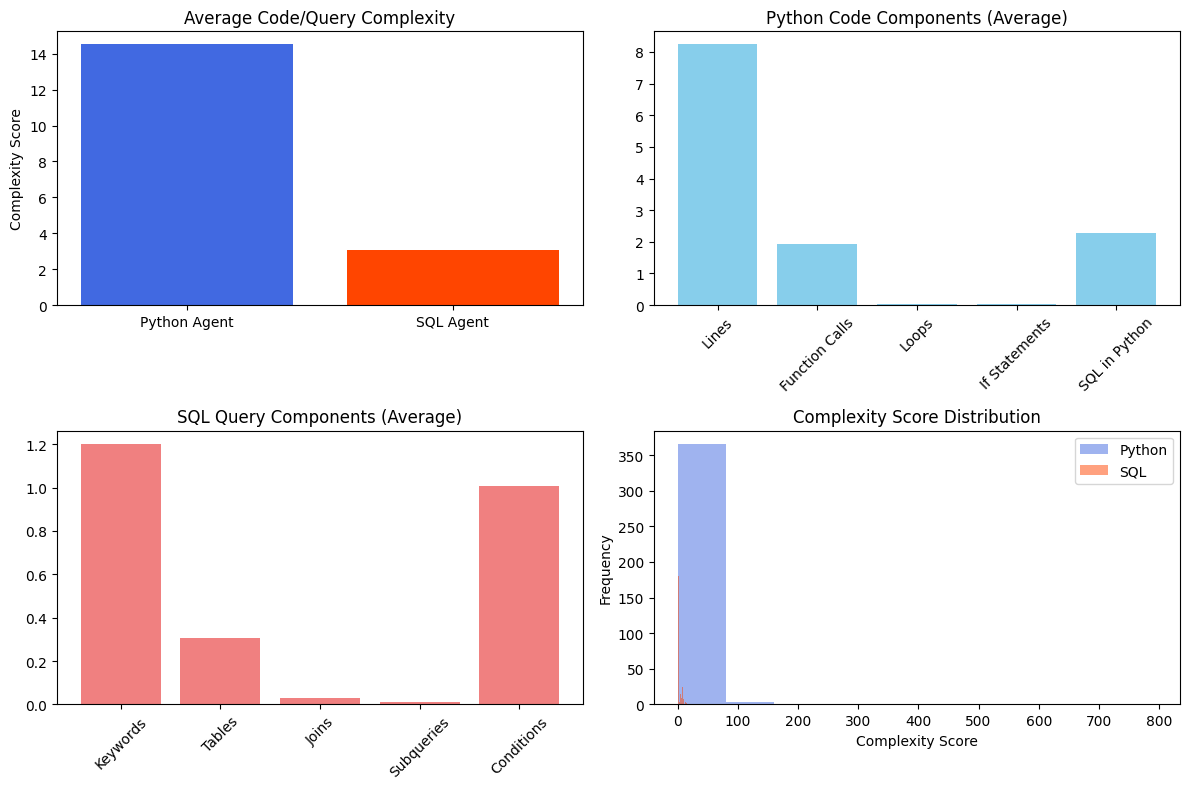

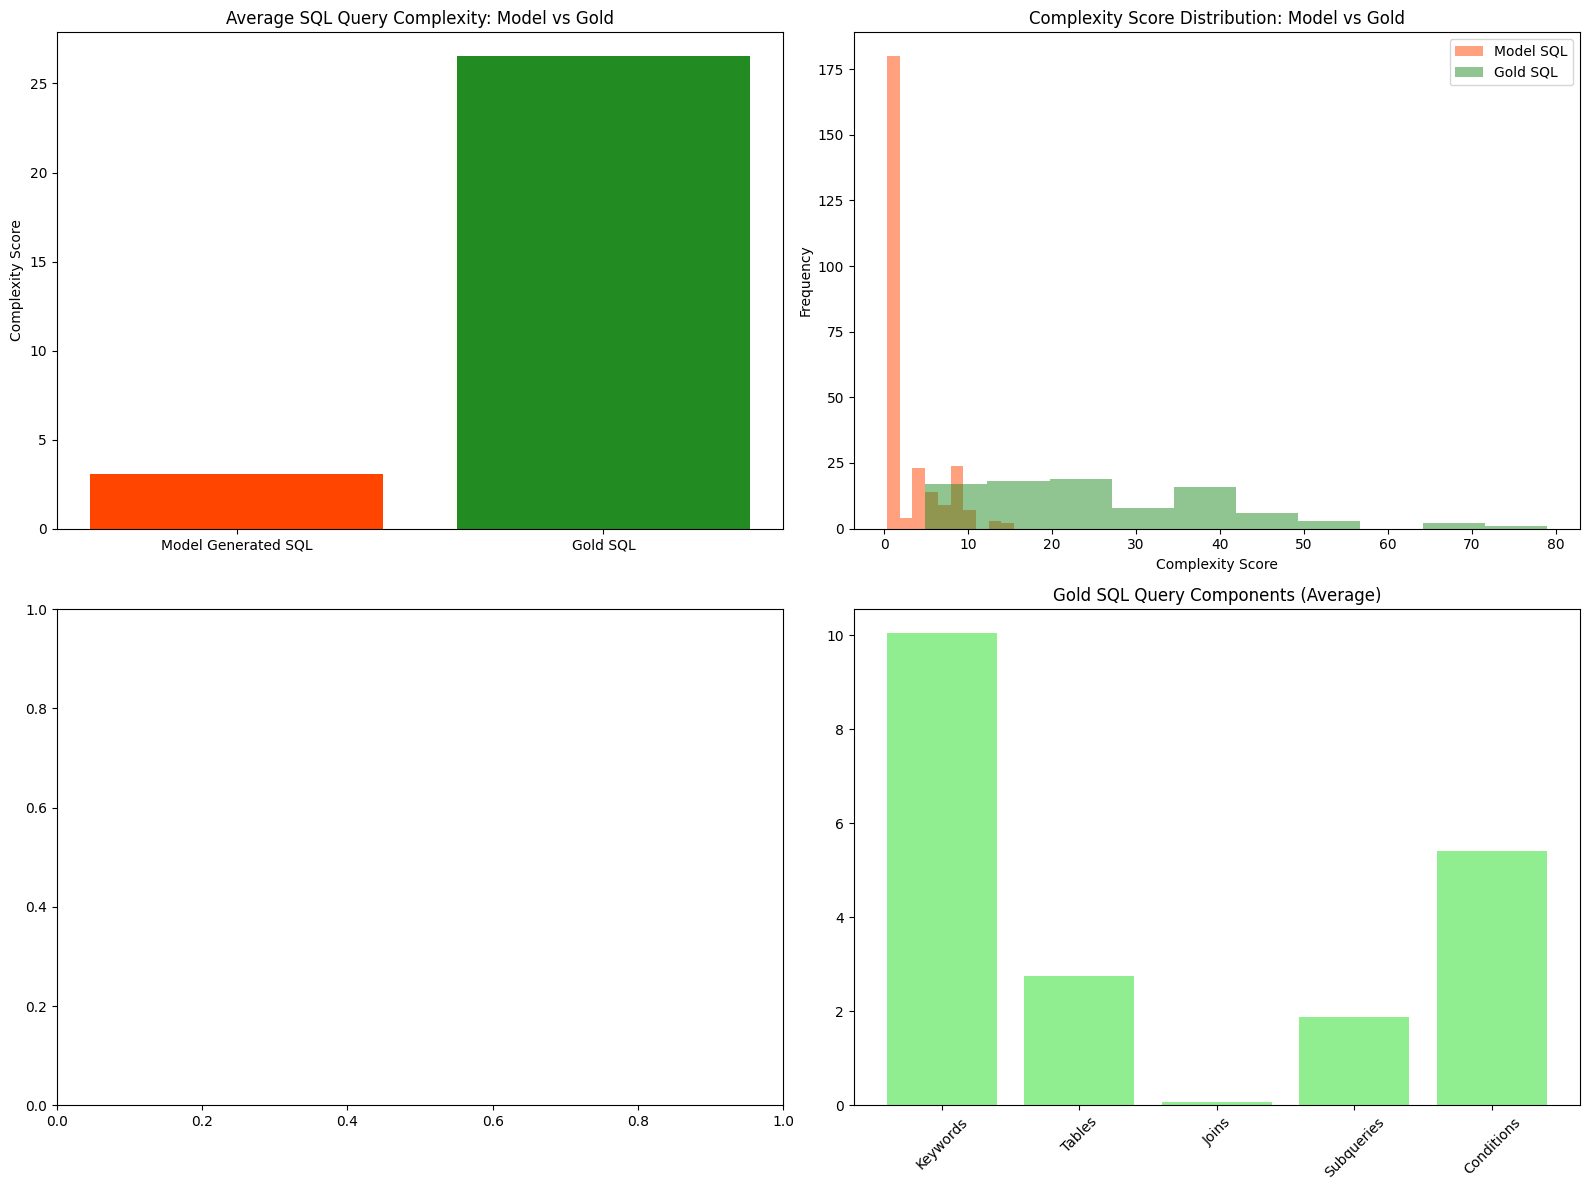


=== Gold SQL Query Complexity Analysis ===
Analyzed 90 gold SQL queries
Average gold SQL complexity: 26.55
Model SQL complexity: 3.08
Complexity difference (Model - Gold): -23.47

Most complex gold SQL queries:
1. Complexity: 67.15, Tables: , Length: 775
   Query: select ( select labevents.valuenum from labevents where labevents.hadm_id in ( select admissions.had...
2. Complexity: 68.02, Tables: , Length: 1052
   Query: select ( select count( distinct t1.subject_id ) from ( select admissions.subject_id, diagnoses_icd.c...
3. Complexity: 78.95, Tables: , Length: 895
   Query: select ( select chartevents.valuenum from chartevents where chartevents.icustay_id in ( select icust...

Simplest gold SQL queries:
1. Complexity: 4.90, Tables: , Length: 70
   Query: select patients.gender from patients where patients.subject_id = 76005
2. Complexity: 5.91, Tables: , Length: 91
   Query: select distinct prescriptions.route from prescriptions where prescriptions.drug = 'danazol'
3. Complexity: 6.0

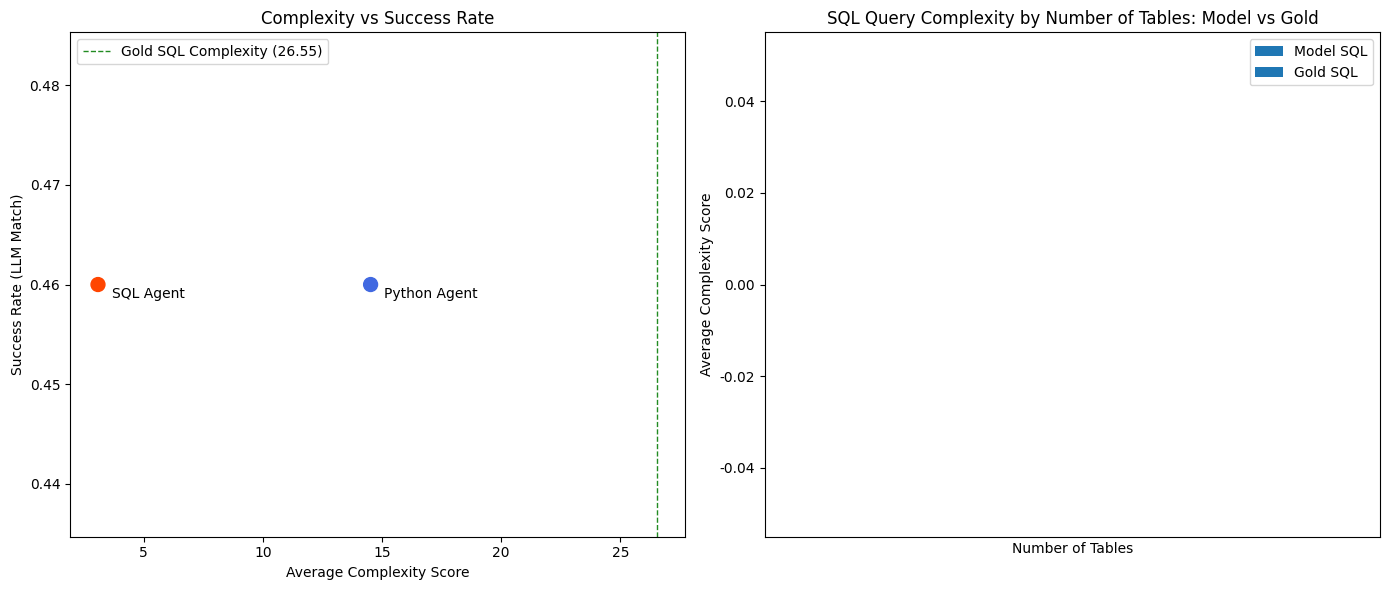

In [28]:
# Gold SQL 쿼리 복잡성 분석 추가 코드

def extract_gold_sql_queries(data):
    """
    데이터셋에서, 각 샘플별 Gold SQL 쿼리 추출
    """
    gold_queries = []
    
    for entry in data.get('evaluation_history', []):
        gold_query = entry.get('gold_sql_query', '')
        
        # 유효한 쿼리만 추가 (None, "null" 문자열, 또는 빈 문자열 제외)
        if gold_query and gold_query.lower() != "null" and gold_query.strip():
            gold_queries.append({
                'id': entry.get('id', ''),
                'query': gold_query,
                'expected_answer': entry.get('expected_answer', ''),
                'table_num': entry.get('table_num', '')
            })
    
    return gold_queries

def analyze_gold_sql_complexity(data_python, data_sql):
    """
    Gold SQL 쿼리의 복잡성 분석
    """
    # Python 데이터셋과 SQL 데이터셋에서 Gold SQL 쿼리 추출
    # (두 데이터셋이 동일한 질문 세트를 포함한다고 가정)
    gold_queries_python = extract_gold_sql_queries(data_python)
    gold_queries_sql = extract_gold_sql_queries(data_sql)
    
    # 중복 제거 (고유한 ID 기준)
    all_gold_queries = {}
    for query_info in gold_queries_python + gold_queries_sql:
        all_gold_queries[query_info['id']] = query_info
    
    gold_queries = list(all_gold_queries.values())
    
    # 복잡성 계산
    for query_info in gold_queries:
        complexity = calculate_sql_complexity(query_info['query'])
        query_info.update(complexity)
    
    return gold_queries

def compare_model_vs_gold_complexity(sql_complexity, gold_complexity_data):
    """
    모델이 생성한 SQL 쿼리와 Gold SQL 쿼리의 복잡성 비교
    """
    # 모델이 생성한 SQL 쿼리의 평균 복잡성
    model_complexity_scores = [q['complexity_score'] for q in sql_complexity]
    model_avg_complexity = statistics.mean(model_complexity_scores) if model_complexity_scores else 0
    
    # Gold SQL 쿼리의 평균 복잡성
    gold_complexity_scores = [q['complexity_score'] for q in gold_complexity_data]
    gold_avg_complexity = statistics.mean(gold_complexity_scores) if gold_complexity_scores else 0
    
    # 테이블 수에 따른 복잡성 분석
    table_complexity = {}
    for query in gold_complexity_data:
        table_num = query.get('table_num')
        if table_num:
            if table_num not in table_complexity:
                table_complexity[table_num] = []
            table_complexity[table_num].append(query['complexity_score'])
    
    table_avg_complexity = {
        t: statistics.mean(scores) if scores else 0 
        for t, scores in table_complexity.items()
    }
    
    # 시각화: 모델 vs Gold 복잡성 비교
    plt.figure(figsize=(16, 12))
    
    # 1. 평균 복잡성 비교
    plt.subplot(2, 2, 1)
    values = [model_avg_complexity, gold_avg_complexity]
    labels = ['Model Generated SQL', 'Gold SQL']
    colors = ['orangered', 'forestgreen']
    
    plt.bar(labels, values, color=colors)
    plt.title('Average SQL Query Complexity: Model vs Gold')
    plt.ylabel('Complexity Score')
    
    # 2. 복잡성 분포 비교
    plt.subplot(2, 2, 2)
    
    if model_complexity_scores:
        plt.hist(model_complexity_scores, alpha=0.5, label='Model SQL', color='orangered', bins=10)
    
    if gold_complexity_scores:
        plt.hist(gold_complexity_scores, alpha=0.5, label='Gold SQL', color='forestgreen', bins=10)
    
    plt.title('Complexity Score Distribution: Model vs Gold')
    plt.xlabel('Complexity Score')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 3. 테이블 수에 따른 Gold SQL 복잡성
    plt.subplot(2, 2, 3)
    
    if table_avg_complexity:
        # 테이블 번호 문자열을 정수로 변환 (가능한 경우)
        table_nums = []
        complexity_values = []
        
        for t, c in sorted(table_avg_complexity.items(), key=lambda x: (
            int(x[0]) if str(x[0]).isdigit() else float('inf'), x[0]
        )):
            table_nums.append(str(t))
            complexity_values.append(c)
        
        plt.bar(table_nums, complexity_values, color='skyblue')
        plt.title('Gold SQL Complexity by Number of Tables')
        plt.xlabel('Number of Tables')
        plt.ylabel('Average Complexity Score')
    
    # 4. Gold SQL 쿼리 구성 요소
    plt.subplot(2, 2, 4)
    
    if gold_complexity_data:
        # 평균 값 계산
        avg_metrics = {
            'Keywords': statistics.mean([q.get('keyword_count', 0) for q in gold_complexity_data]),
            'Tables': statistics.mean([q.get('table_count', 0) for q in gold_complexity_data]),
            'Joins': statistics.mean([q.get('join_count', 0) for q in gold_complexity_data]),
            'Subqueries': statistics.mean([q.get('subquery_count', 0) for q in gold_complexity_data]),
            'Conditions': statistics.mean([q.get('condition_count', 0) for q in gold_complexity_data])
        }
        
        plt.bar(avg_metrics.keys(), avg_metrics.values(), color='lightgreen')
        plt.title('Gold SQL Query Components (Average)')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 추가 분석: 쿼리 타입별 복잡성 패턴 (가장 복잡한/단순한 쿼리 유형)
    if gold_complexity_data:
        # 가장 복잡한 쿼리와 가장 단순한 쿼리 찾기
        sorted_by_complexity = sorted(gold_complexity_data, key=lambda x: x['complexity_score'])
        
        simplest_queries = sorted_by_complexity[:min(3, len(sorted_by_complexity))]
        most_complex_queries = sorted_by_complexity[-min(3, len(sorted_by_complexity)):]
        
        print("\n=== Gold SQL Query Complexity Analysis ===")
        print(f"Analyzed {len(gold_complexity_data)} gold SQL queries")
        print(f"Average gold SQL complexity: {gold_avg_complexity:.2f}")
        print(f"Model SQL complexity: {model_avg_complexity:.2f}")
        print(f"Complexity difference (Model - Gold): {model_avg_complexity - gold_avg_complexity:.2f}")
        
        print("\nMost complex gold SQL queries:")
        for i, q in enumerate(most_complex_queries, 1):
            print(f"{i}. Complexity: {q['complexity_score']:.2f}, Tables: {q['table_num']}, Length: {q['length']}")
            print(f"   Query: {q['query'][:100]}..." if len(q['query']) > 100 else f"   Query: {q['query']}")
        
        print("\nSimplest gold SQL queries:")
        for i, q in enumerate(simplest_queries, 1):
            print(f"{i}. Complexity: {q['complexity_score']:.2f}, Tables: {q['table_num']}, Length: {q['length']}")
            print(f"   Query: {q['query'][:100]}..." if len(q['query']) > 100 else f"   Query: {q['query']}")
    
    return {
        'model_avg_complexity': model_avg_complexity,
        'gold_avg_complexity': gold_avg_complexity,
        'complexity_diff': model_avg_complexity - gold_avg_complexity,
        'table_complexity': table_avg_complexity
    }

# 메인 분석 함수에 Gold SQL 복잡성 분석 추가
def analyze_agents_and_gold_complexity(python_data, sql_data, python_df, sql_df):
    """
    Python 코드, SQL 쿼리 및 Gold SQL 쿼리의 복잡성 종합 분석
    """
    # 1. 에이전트 코드 복잡성 분석
    complexity_results = analyze_code_complexity(python_data, sql_data)
    
    # 2. Gold SQL 쿼리 복잡성 분석
    gold_complexity_data = analyze_gold_sql_complexity(python_data, sql_data)
    
    # 3. 에이전트 코드 복잡성 시각화
    viz_results = visualize_code_complexity(complexity_results)
    
    # 4. Model SQL vs Gold SQL 복잡성 비교
    gold_comparison = compare_model_vs_gold_complexity(complexity_results['sql_complexity'], gold_complexity_data)
    
    # 5. 복잡성과 성능 관계 분석
    python_avg_complexity = viz_results['python_avg_complexity']
    sql_avg_complexity = viz_results['sql_avg_complexity']
    gold_avg_complexity = gold_comparison['gold_avg_complexity']
    
    # 성능 대비 복잡성 분석 데이터프레임
    performance_df = pd.DataFrame({
        'Agent': ['Python Agent', 'SQL Agent', 'Gold SQL'],
        'Avg Complexity': [python_avg_complexity, sql_avg_complexity, gold_avg_complexity],
        'Success Rate': [
            python_df['llm_match'].mean(), 
            sql_df['llm_match'].mean(),
            1.0  # Gold SQL은 항상 정답
        ],
        'Avg Tokens': [
            python_df['total_tokens'].mean(), 
            sql_df['total_tokens'].mean(),
            0  # Gold SQL은 토큰 사용 안 함
        ],
        'Complexity Gap': [
            0,  # Python은 비교 대상 아님
            sql_avg_complexity - gold_avg_complexity,  # SQL vs Gold
            0   # Gold 자신
        ]
    })
    
    # 복잡성-성능 관계 시각화
    plt.figure(figsize=(14, 6))
    
    # 1. 복잡성 대비 성능
    plt.subplot(1, 2, 1)
    
    # Python 및 SQL 에이전트 데이터
    x = performance_df['Avg Complexity'][:2]  # Gold SQL 제외
    y = performance_df['Success Rate'][:2]    # Gold SQL 제외
    colors = ['royalblue', 'orangered']
    
    plt.scatter(x, y, s=100, c=colors)
    
    # 텍스트 라벨 추가
    for i, agent in enumerate(performance_df['Agent'][:2]):
        plt.annotate(agent, (x[i], y[i]), xytext=(10, -10), 
                     textcoords='offset points', fontsize=10)
    
    # Gold SQL 복잡성 기준선 추가
    plt.axvline(x=gold_avg_complexity, color='forestgreen', linestyle='--', 
                linewidth=1, label=f'Gold SQL Complexity ({gold_avg_complexity:.2f})')
    
    plt.title('Complexity vs Success Rate')
    plt.xlabel('Average Complexity Score')
    plt.ylabel('Success Rate (LLM Match)')
    plt.legend()
    
    # 2. SQL vs Gold 복잡성 차이 분석
    plt.subplot(1, 2, 2)
    
    # 각 테이블 수별 복잡성 차이 계산
    table_nums = []
    model_complexities = []
    gold_complexities = []
    
    # SQL 에이전트 쿼리를 테이블 수별로 그룹화
    sql_by_table = {}
    for entry in sql_data.get('evaluation_history', []):
        table_num = entry.get('table_num')
        if table_num:
            if table_num not in sql_by_table:
                sql_by_table[table_num] = []
            
            # 해당 샘플에 대한 SQL 쿼리 추출
            history = entry.get('history', [])
            queries = extract_sql_queries(history)
            
            # 복잡성 계산 및 저장
            if queries:
                query_complexities = [calculate_sql_complexity(q)['complexity_score'] for q in queries]
                avg_complexity = statistics.mean(query_complexities) if query_complexities else 0
                sql_by_table[table_num].append(avg_complexity)
    
    # 테이블 수별 평균 복잡성 계산
    sql_table_avg = {
        t: statistics.mean(scores) if scores else 0 
        for t, scores in sql_by_table.items()
    }
    
    # Gold SQL의 테이블 수별 복잡성
    gold_table_avg = gold_comparison['table_complexity']
    
    # 모든 테이블 수 목록
    all_tables = sorted(set(list(sql_table_avg.keys()) + list(gold_table_avg.keys())))
    
    # 데이터 준비
    for table in all_tables:
        table_nums.append(str(table))
        model_complexities.append(sql_table_avg.get(table, 0))
        gold_complexities.append(gold_table_avg.get(table, 0))
    
    # 그래프 데이터
    x = np.arange(len(table_nums))
    width = 0.35
    
    # 막대 그래프 생성
    plt.bar(x - width/2, model_complexities, width, label='Model SQL', color='orangered')
    plt.bar(x + width/2, gold_complexities, width, label='Gold SQL', color='forestgreen')
    
    plt.title('SQL Query Complexity by Number of Tables: Model vs Gold')
    plt.xlabel('Number of Tables')
    plt.ylabel('Average Complexity Score')
    plt.xticks(x, table_nums)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 6. 복잡성 차이와 성능의 관계
    if len(sql_by_table) > 0 and len(gold_table_avg) > 0:
        # 테이블 수별 성능 계산
        performance_by_table = {}
        for entry in sql_data.get('evaluation_history', []):
            table_num = entry.get('table_num')
            llm_match = entry.get('sample_metrics', {}).get('llm_match', False)
            
            if table_num:
                if table_num not in performance_by_table:
                    performance_by_table[table_num] = []
                performance_by_table[table_num].append(1 if llm_match else 0)
        
        # 테이블 수별 평균 성능
        perf_table_avg = {
            t: statistics.mean(scores) if scores else 0 
            for t, scores in performance_by_table.items()
        }
        
        # 복잡성 차이 계산
        complexity_diff = {}
        for table in set(sql_table_avg.keys()) & set(gold_table_avg.keys()):
            complexity_diff[table] = sql_table_avg[table] - gold_table_avg[table]
        
        # 복잡성 차이와 성능의 상관관계 시각화
        plt.figure(figsize=(10, 6))
        
        # 데이터 준비
        tables = []
        diffs = []
        performance = []
        
        for table in complexity_diff:
            if table in perf_table_avg:
                tables.append(str(table))
                diffs.append(complexity_diff[table])
                performance.append(perf_table_avg[table])
        
        # 산점도
        plt.scatter(diffs, performance, s=80, c='purple', alpha=0.7)
        
        # 텍스트 라벨 추가
        for i, table in enumerate(tables):
            plt.annotate(f"Table {table}", (diffs[i], performance[i]), 
                         xytext=(5, 5), textcoords='offset points')
        
        # 추세선 추가
        if len(diffs) > 1:
            z = np.polyfit(diffs, performance, 1)
            p = np.poly1d(z)
            plt.plot(sorted(diffs), p(sorted(diffs)), "r--", alpha=0.7)
            
            # 상관계수 계산
            correlation = np.corrcoef(diffs, performance)[0, 1]
            plt.title(f'Complexity Difference vs Performance (Correlation: {correlation:.2f})')
        else:
            plt.title('Complexity Difference vs Performance')
            
        plt.xlabel('Complexity Difference (Model - Gold)')
        plt.ylabel('Success Rate (LLM Match)')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)
        plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'complexity_results': complexity_results,
        'gold_complexity_data': gold_complexity_data,
        'performance_df': performance_df,
        'gold_comparison': gold_comparison
    }

# 이 함수를 메인 분석 스크립트에서 호출하여 사용
analysis_results = analyze_agents_and_gold_complexity(python_data, sql_data, python_df, sql_df)

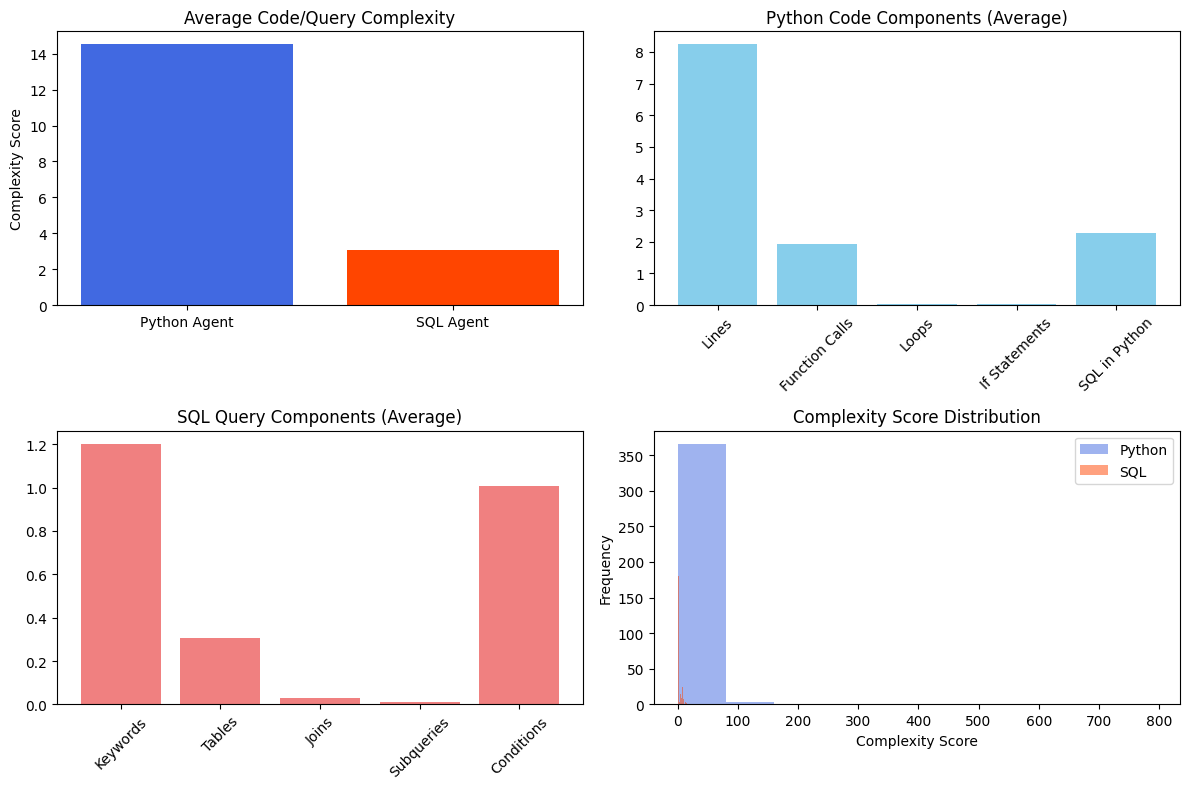

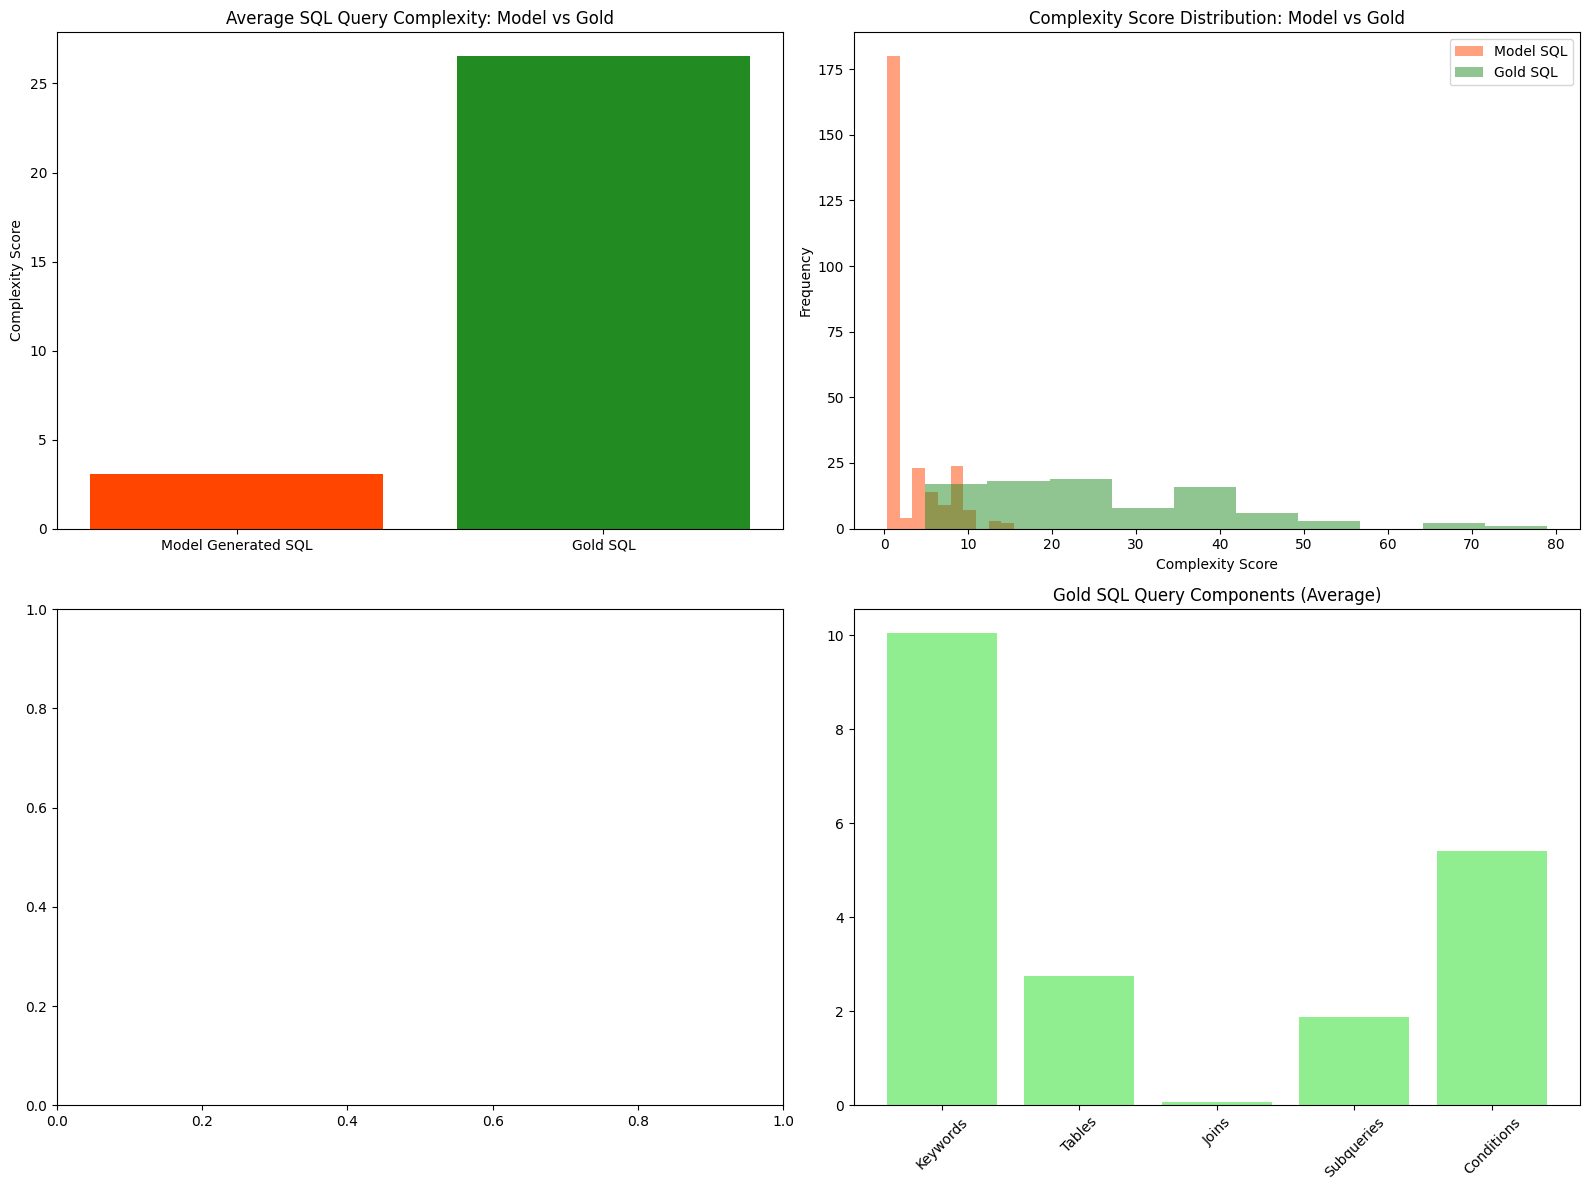


=== Gold SQL Query Complexity Analysis ===
Analyzed 90 gold SQL queries
Average gold SQL complexity: 26.55
Model SQL complexity: 3.08
Complexity difference (Model - Gold): -23.47

Most complex gold SQL queries:
1. Complexity: 67.15, Tables: , Length: 775
   Query: select ( select labevents.valuenum from labevents where labevents.hadm_id in ( select admissions.had...
2. Complexity: 68.02, Tables: , Length: 1052
   Query: select ( select count( distinct t1.subject_id ) from ( select admissions.subject_id, diagnoses_icd.c...
3. Complexity: 78.95, Tables: , Length: 895
   Query: select ( select chartevents.valuenum from chartevents where chartevents.icustay_id in ( select icust...

Simplest gold SQL queries:
1. Complexity: 4.90, Tables: , Length: 70
   Query: select patients.gender from patients where patients.subject_id = 76005
2. Complexity: 5.91, Tables: , Length: 91
   Query: select distinct prescriptions.route from prescriptions where prescriptions.drug = 'danazol'
3. Complexity: 6.0

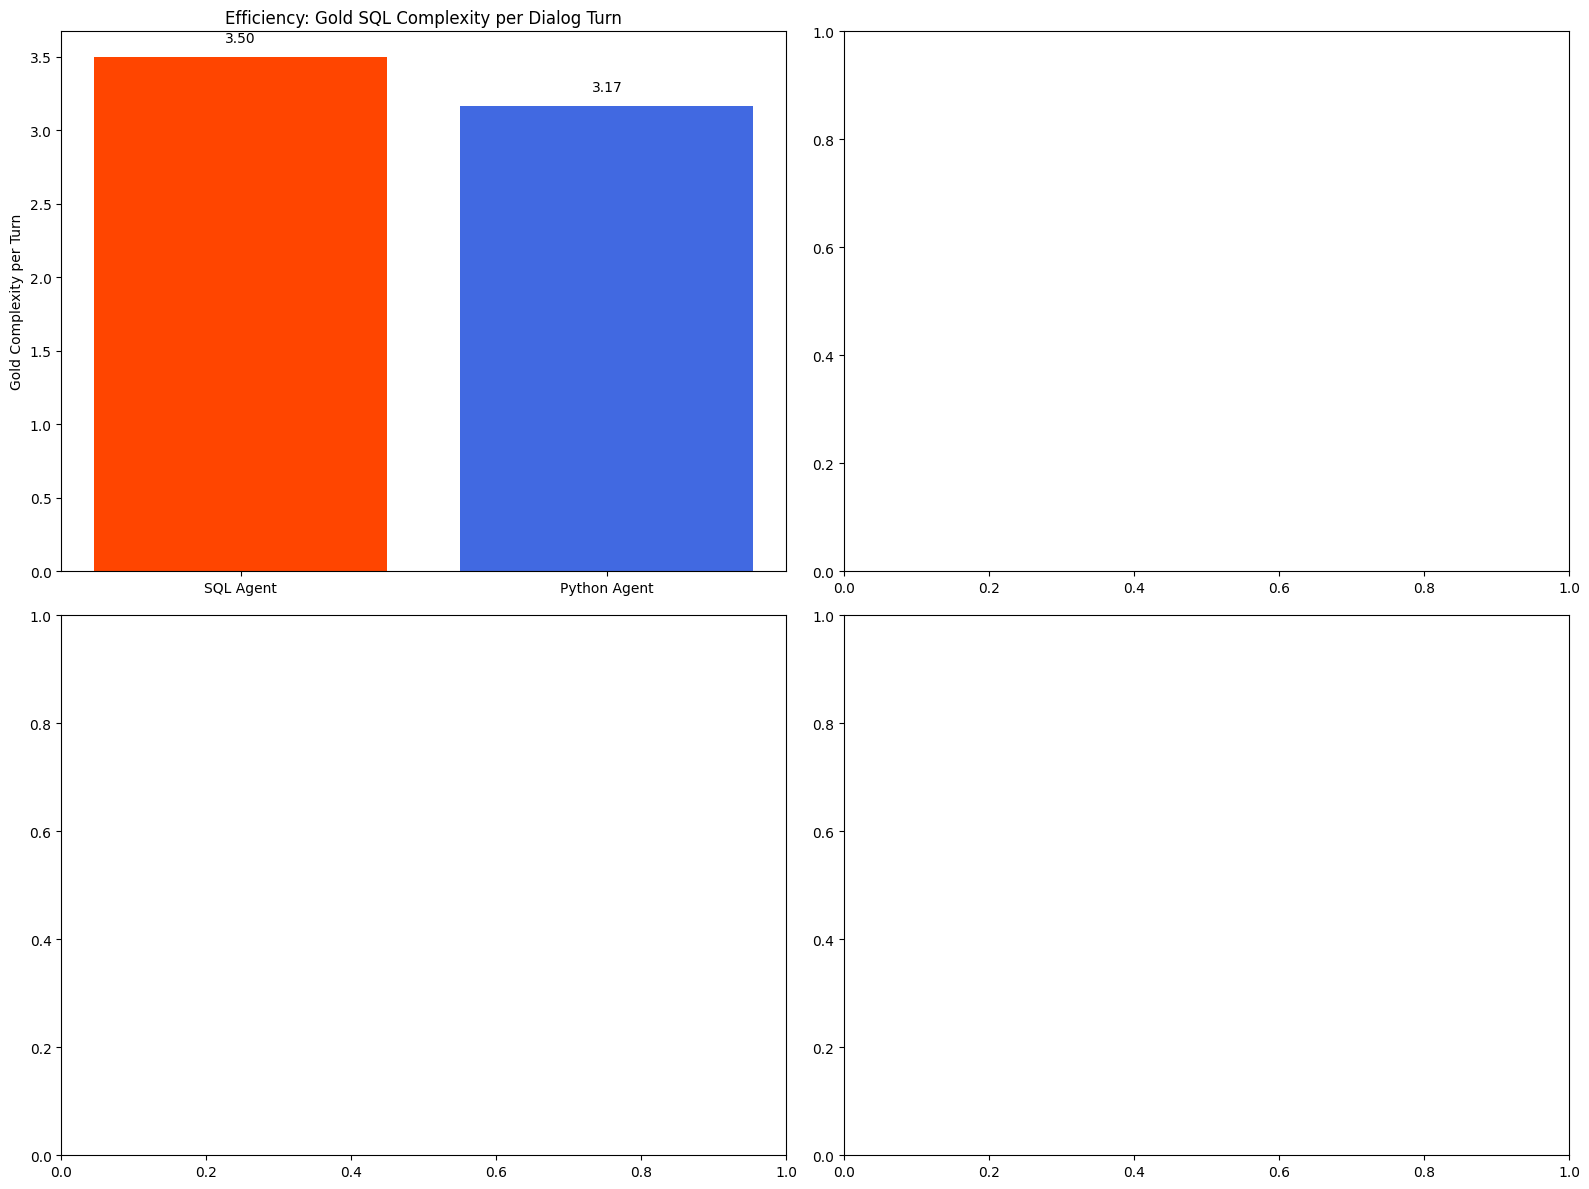


=== Gold SQL Complexity per Turn Analysis ===
Average efficiency (Gold SQL complexity per dialog turn):
          Agent  Avg Dialog Turns  Efficiency (Complexity/Turn)
0     SQL Agent              7.59                      3.497526
1  Python Agent              8.38                      3.167807

SQL vs. Python relative efficiency:
SQL Agent is 1.10x more efficient than Python Agent

Table-wise efficiency comparison:

=== Comprehensive Analysis Summary ===
                       Metric Python Agent SQL Agent
     Success Rate (LLM Match)       46.00%    46.00%
    Avg Code/Query Complexity        14.52      3.08
      Avg Gold SQL Complexity        26.55     26.55
Complexity Gap (Model - Gold)          N/A    -23.47
             Avg Dialog Turns         8.38      7.59
     Gold Complexity per Turn         3.17      3.50
              Tokens per Turn      2961.57   2380.73
   Tokens per Gold Complexity       934.90    680.69

=== Conclusion ===
Based on the analysis, here are the winner

In [29]:
# Gold SQL 복잡성과 평균 턴 수 관계 분석 추가 코드
def analyze_gold_complexity_per_turn(gold_complexity_data, sql_df, python_df):
    """
    Gold SQL 쿼리 복잡성을 평균 턴 수로 나눈 효율성 분석
    """
    # 각 데이터셋의 평균 턴 수
    sql_avg_turns = sql_df['total_turns'].mean()
    python_avg_turns = python_df['total_turns'].mean()
    
    # Gold SQL 평균 복잡성
    gold_complexity_scores = [q['complexity_score'] for q in gold_complexity_data]
    gold_avg_complexity = statistics.mean(gold_complexity_scores) if gold_complexity_scores else 0
    
    # 턴당 Gold SQL 복잡성 계산
    sql_efficiency = gold_avg_complexity / sql_avg_turns if sql_avg_turns > 0 else 0
    python_efficiency = gold_avg_complexity / python_avg_turns if python_avg_turns > 0 else 0
    
    # 테이블 수별 분석
    table_efficiency = {}
    
    # 각 테이블 수별 Gold SQL 복잡성 데이터 그룹화
    table_gold_complexity = {}
    for query in gold_complexity_data:
        table_num = query.get('table_num')
        if table_num:
            if table_num not in table_gold_complexity:
                table_gold_complexity[table_num] = []
            table_gold_complexity[table_num].append(query['complexity_score'])
    
    # 각 테이블 수별 평균 턴 수 계산
    sql_turns_by_table = sql_df.groupby('table_num')['total_turns'].mean().to_dict()
    python_turns_by_table = python_df.groupby('table_num')['total_turns'].mean().to_dict()
    
    # 각 테이블 수별 효율성 계산
    for table_num, complexity_scores in table_gold_complexity.items():
        avg_complexity = statistics.mean(complexity_scores) if complexity_scores else 0
        
        sql_turns = sql_turns_by_table.get(table_num, 0)
        python_turns = python_turns_by_table.get(table_num, 0)
        
        sql_table_efficiency = avg_complexity / sql_turns if sql_turns > 0 else 0
        python_table_efficiency = avg_complexity / python_turns if python_turns > 0 else 0
        
        table_efficiency[table_num] = {
            'gold_complexity': avg_complexity,
            'sql_turns': sql_turns,
            'python_turns': python_turns,
            'sql_efficiency': sql_table_efficiency,
            'python_efficiency': python_table_efficiency
        }
    
    # 결과 시각화
    plt.figure(figsize=(16, 12))
    
    # 1. 전체 효율성 비교 (턴당 Gold SQL 복잡성)
    plt.subplot(2, 2, 1)
    
    efficiency_data = pd.DataFrame({
        'Agent': ['SQL Agent', 'Python Agent'],
        'Efficiency (Gold Complexity / Turn)': [sql_efficiency, python_efficiency]
    })
    
    colors = ['orangered', 'royalblue']
    plt.bar(efficiency_data['Agent'], efficiency_data['Efficiency (Gold Complexity / Turn)'], color=colors)
    plt.title('Efficiency: Gold SQL Complexity per Dialog Turn')
    plt.ylabel('Gold Complexity per Turn')
    
    # 효율성 값 표시
    for i, v in enumerate(efficiency_data['Efficiency (Gold Complexity / Turn)']):
        plt.text(i, v + 0.1, f"{v:.2f}", ha='center')
    
    # 2. 테이블 수별 효율성 비교
    plt.subplot(2, 2, 2)
    
    if table_efficiency:
        # 데이터 준비
        tables = sorted(table_efficiency.keys())
        sql_efficiencies = [table_efficiency[t]['sql_efficiency'] for t in tables]
        python_efficiencies = [table_efficiency[t]['python_efficiency'] for t in tables]
        
        # 위치 설정
        x = range(len(tables))
        width = 0.35
        
        plt.bar([i - width/2 for i in x], sql_efficiencies, width, label='SQL Agent', color='orangered')
        plt.bar([i + width/2 for i in x], python_efficiencies, width, label='Python Agent', color='royalblue')
        
        plt.title('Gold SQL Complexity per Turn by Number of Tables')
        plt.xlabel('Number of Tables')
        plt.ylabel('Gold Complexity per Turn')
        plt.xticks(x, tables)
        plt.legend()
    
    # 3. Gold SQL 복잡성과 턴 수의 관계 (SQL Agent)
    plt.subplot(2, 2, 3)
    
    if table_efficiency:
        # 데이터 준비
        tables = []
        complexities = []
        turns = []
        
        for table_num, data in sorted(table_efficiency.items()):
            tables.append(str(table_num))
            complexities.append(data['gold_complexity'])
            turns.append(data['sql_turns'])
        
        # 첫 번째 Y축 (Gold SQL 복잡성)
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.set_xlabel('Number of Tables')
        ax1.set_ylabel('Gold SQL Complexity', color='forestgreen')
        line1 = ax1.plot(tables, complexities, 'o-', color='forestgreen', linewidth=2, label='Gold Complexity')
        ax1.tick_params(axis='y', labelcolor='forestgreen')
        
        # 두 번째 Y축 (평균 턴 수)
        ax2 = ax1.twinx()
        ax2.set_ylabel('Average Turns (SQL Agent)', color='orangered')
        line2 = ax2.plot(tables, turns, 'o-', color='orangered', linewidth=2, label='SQL Turns')
        ax2.tick_params(axis='y', labelcolor='orangered')
        
        # 제목 및 범례
        plt.title('Gold SQL Complexity vs. SQL Agent Turns by Table Count')
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left')
        
        plt.tight_layout()
        
        # 현재 subplot에 그림 삽입
        plt.subplot(2, 2, 3)
        plt.imshow(fig.canvas.renderer.buffer_rgba())
        plt.axis('off')
        plt.close(fig)
    
    # 4. Gold SQL 복잡성과 턴 수의 관계 (Python Agent)
    plt.subplot(2, 2, 4)
    
    if table_efficiency:
        # 데이터 준비
        tables = []
        complexities = []
        turns = []
        
        for table_num, data in sorted(table_efficiency.items()):
            tables.append(str(table_num))
            complexities.append(data['gold_complexity'])
            turns.append(data['python_turns'])
        
        # 첫 번째 Y축 (Gold SQL 복잡성)
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.set_xlabel('Number of Tables')
        ax1.set_ylabel('Gold SQL Complexity', color='forestgreen')
        line1 = ax1.plot(tables, complexities, 'o-', color='forestgreen', linewidth=2, label='Gold Complexity')
        ax1.tick_params(axis='y', labelcolor='forestgreen')
        
        # 두 번째 Y축 (평균 턴 수)
        ax2 = ax1.twinx()
        ax2.set_ylabel('Average Turns (Python Agent)', color='royalblue')
        line2 = ax2.plot(tables, turns, 'o-', color='royalblue', linewidth=2, label='Python Turns')
        ax2.tick_params(axis='y', labelcolor='royalblue')
        
        # 제목 및 범례
        plt.title('Gold SQL Complexity vs. Python Agent Turns by Table Count')
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left')
        
        plt.tight_layout()
        
        # 현재 subplot에 그림 삽입
        plt.subplot(2, 2, 4)
        plt.imshow(fig.canvas.renderer.buffer_rgba())
        plt.axis('off')
        plt.close(fig)
    
    plt.tight_layout()
    plt.show()
    
    # 효율성 분석 결과 표 생성
    efficiency_table = pd.DataFrame({
        'Agent': ['SQL Agent', 'Python Agent'],
        'Avg Gold SQL Complexity': [gold_avg_complexity, gold_avg_complexity],
        'Avg Dialog Turns': [sql_avg_turns, python_avg_turns],
        'Efficiency (Complexity/Turn)': [sql_efficiency, python_efficiency],
        'Relative Efficiency': [sql_efficiency / python_efficiency if python_efficiency > 0 else float('inf'),
                               1.0]
    })
    
    print("\n=== Gold SQL Complexity per Turn Analysis ===")
    print("Average efficiency (Gold SQL complexity per dialog turn):")
    print(efficiency_table[['Agent', 'Avg Dialog Turns', 'Efficiency (Complexity/Turn)']])
    
    print("\nSQL vs. Python relative efficiency:")
    if sql_efficiency > python_efficiency and python_efficiency > 0:
        print(f"SQL Agent is {sql_efficiency / python_efficiency:.2f}x more efficient than Python Agent")
    elif python_efficiency > sql_efficiency and sql_efficiency > 0:
        print(f"Python Agent is {python_efficiency / sql_efficiency:.2f}x more efficient than SQL Agent")
    else:
        print("Efficiency comparison could not be determined")
    
    print("\nTable-wise efficiency comparison:")
    for table_num, data in sorted(table_efficiency.items()):
        print(f"Table {table_num}:")
        print(f"  Gold SQL Complexity: {data['gold_complexity']:.2f}")
        print(f"  SQL Agent: {data['sql_turns']:.2f} turns → {data['sql_efficiency']:.2f} complexity/turn")
        print(f"  Python Agent: {data['python_turns']:.2f} turns → {data['python_efficiency']:.2f} complexity/turn")
        
        if data['sql_efficiency'] > data['python_efficiency'] and data['python_efficiency'] > 0:
            ratio = data['sql_efficiency'] / data['python_efficiency']
            print(f"  For table {table_num}, SQL Agent is {ratio:.2f}x more efficient")
        elif data['python_efficiency'] > data['sql_efficiency'] and data['sql_efficiency'] > 0:
            ratio = data['python_efficiency'] / data['sql_efficiency']
            print(f"  For table {table_num}, Python Agent is {ratio:.2f}x more efficient")
        print()
    
    return {
        'sql_efficiency': sql_efficiency,
        'python_efficiency': python_efficiency,
        'table_efficiency': table_efficiency,
        'efficiency_table': efficiency_table
    }

# 기존 분석 함수에 턴당 Gold SQL 복잡성 분석 추가
def analyze_complete_complexity(python_data, sql_data, python_df, sql_df):
    """
    Python 코드, SQL 쿼리, Gold SQL 쿼리 및 턴당 효율성의 종합 분석
    """
    # 1. 에이전트 코드 복잡성 분석
    complexity_results = analyze_code_complexity(python_data, sql_data)
    
    # 2. Gold SQL 쿼리 복잡성 분석
    gold_complexity_data = analyze_gold_sql_complexity(python_data, sql_data)
    
    # 3. 에이전트 코드 복잡성 시각화
    viz_results = visualize_code_complexity(complexity_results)
    
    # 4. Model SQL vs Gold SQL 복잡성 비교
    gold_comparison = compare_model_vs_gold_complexity(complexity_results['sql_complexity'], gold_complexity_data)
    
    # 5. 턴당 Gold SQL 복잡성 효율성 분석
    efficiency_results = analyze_gold_complexity_per_turn(gold_complexity_data, sql_df, python_df)
    
    # 6. 종합 분석 표 생성
    summary_df = pd.DataFrame({
        'Metric': [
            'Success Rate (LLM Match)',
            'Avg Code/Query Complexity',
            'Avg Gold SQL Complexity',
            'Complexity Gap (Model - Gold)',
            'Avg Dialog Turns',
            'Gold Complexity per Turn',
            'Tokens per Turn',
            'Tokens per Gold Complexity'
        ],
        'Python Agent': [
            f"{python_df['llm_match'].mean():.2%}",
            f"{viz_results['python_avg_complexity']:.2f}",
            f"{gold_comparison['gold_avg_complexity']:.2f}",
            "N/A",  # Python은 Gold SQL과 직접 비교 안 함
            f"{python_df['total_turns'].mean():.2f}",
            f"{efficiency_results['python_efficiency']:.2f}",
            f"{python_df['total_tokens'].mean() / python_df['total_turns'].mean():.2f}",
            f"{python_df['total_tokens'].mean() / gold_comparison['gold_avg_complexity']:.2f}"
        ],
        'SQL Agent': [
            f"{sql_df['llm_match'].mean():.2%}",
            f"{viz_results['sql_avg_complexity']:.2f}",
            f"{gold_comparison['gold_avg_complexity']:.2f}",
            f"{gold_comparison['complexity_diff']:.2f}",
            f"{sql_df['total_turns'].mean():.2f}",
            f"{efficiency_results['sql_efficiency']:.2f}",
            f"{sql_df['total_tokens'].mean() / sql_df['total_turns'].mean():.2f}",
            f"{sql_df['total_tokens'].mean() / gold_comparison['gold_avg_complexity']:.2f}"
        ]
    })
    
    print("\n=== Comprehensive Analysis Summary ===")
    print(summary_df.to_string(index=False))
    
    # 7. 결론 및 추천
    winner_metric = {}
    
    # Success Rate
    if python_df['llm_match'].mean() > sql_df['llm_match'].mean():
        winner_metric['Success Rate'] = 'Python Agent'
    elif sql_df['llm_match'].mean() > python_df['llm_match'].mean():
        winner_metric['Success Rate'] = 'SQL Agent'
    else:
        winner_metric['Success Rate'] = 'Tie'
    
    # Code Efficiency
    if efficiency_results['python_efficiency'] > efficiency_results['sql_efficiency']:
        winner_metric['Gold Complexity per Turn'] = 'Python Agent'
    elif efficiency_results['sql_efficiency'] > efficiency_results['python_efficiency']:
        winner_metric['Gold Complexity per Turn'] = 'SQL Agent'
    else:
        winner_metric['Gold Complexity per Turn'] = 'Tie'
    
    # Token Efficiency
    p_token_per_turn = python_df['total_tokens'].mean() / python_df['total_turns'].mean()
    s_token_per_turn = sql_df['total_tokens'].mean() / sql_df['total_turns'].mean()
    
    if p_token_per_turn < s_token_per_turn:
        winner_metric['Token Efficiency'] = 'Python Agent'
    elif s_token_per_turn < p_token_per_turn:
        winner_metric['Token Efficiency'] = 'SQL Agent'
    else:
        winner_metric['Token Efficiency'] = 'Tie'
    
    print("\n=== Conclusion ===")
    print("Based on the analysis, here are the winners by metric:")
    for metric, winner in winner_metric.items():
        print(f"- {metric}: {winner}")
    
    print("\nOverall recommendation:")
    python_wins = sum(1 for winner in winner_metric.values() if winner == 'Python Agent')
    sql_wins = sum(1 for winner in winner_metric.values() if winner == 'SQL Agent')
    
    if python_wins > sql_wins:
        print(f"The Python Agent performs better overall, winning in {python_wins} out of {len(winner_metric)} key metrics.")
    elif sql_wins > python_wins:
        print(f"The SQL Agent performs better overall, winning in {sql_wins} out of {len(winner_metric)} key metrics.")
    else:
        print(f"Both agents perform similarly, with each winning in {python_wins} out of {len(winner_metric)} key metrics.")
    
    return {
        'complexity_results': complexity_results,
        'gold_complexity_data': gold_complexity_data,
        'gold_comparison': gold_comparison,
        'efficiency_results': efficiency_results,
        'summary_df': summary_df,
        'winner_metric': winner_metric
    }

# 이 함수를 메인 분석 스크립트에서 호출하여 사용
complete_analysis = analyze_complete_complexity(python_data, sql_data, python_df, sql_df)

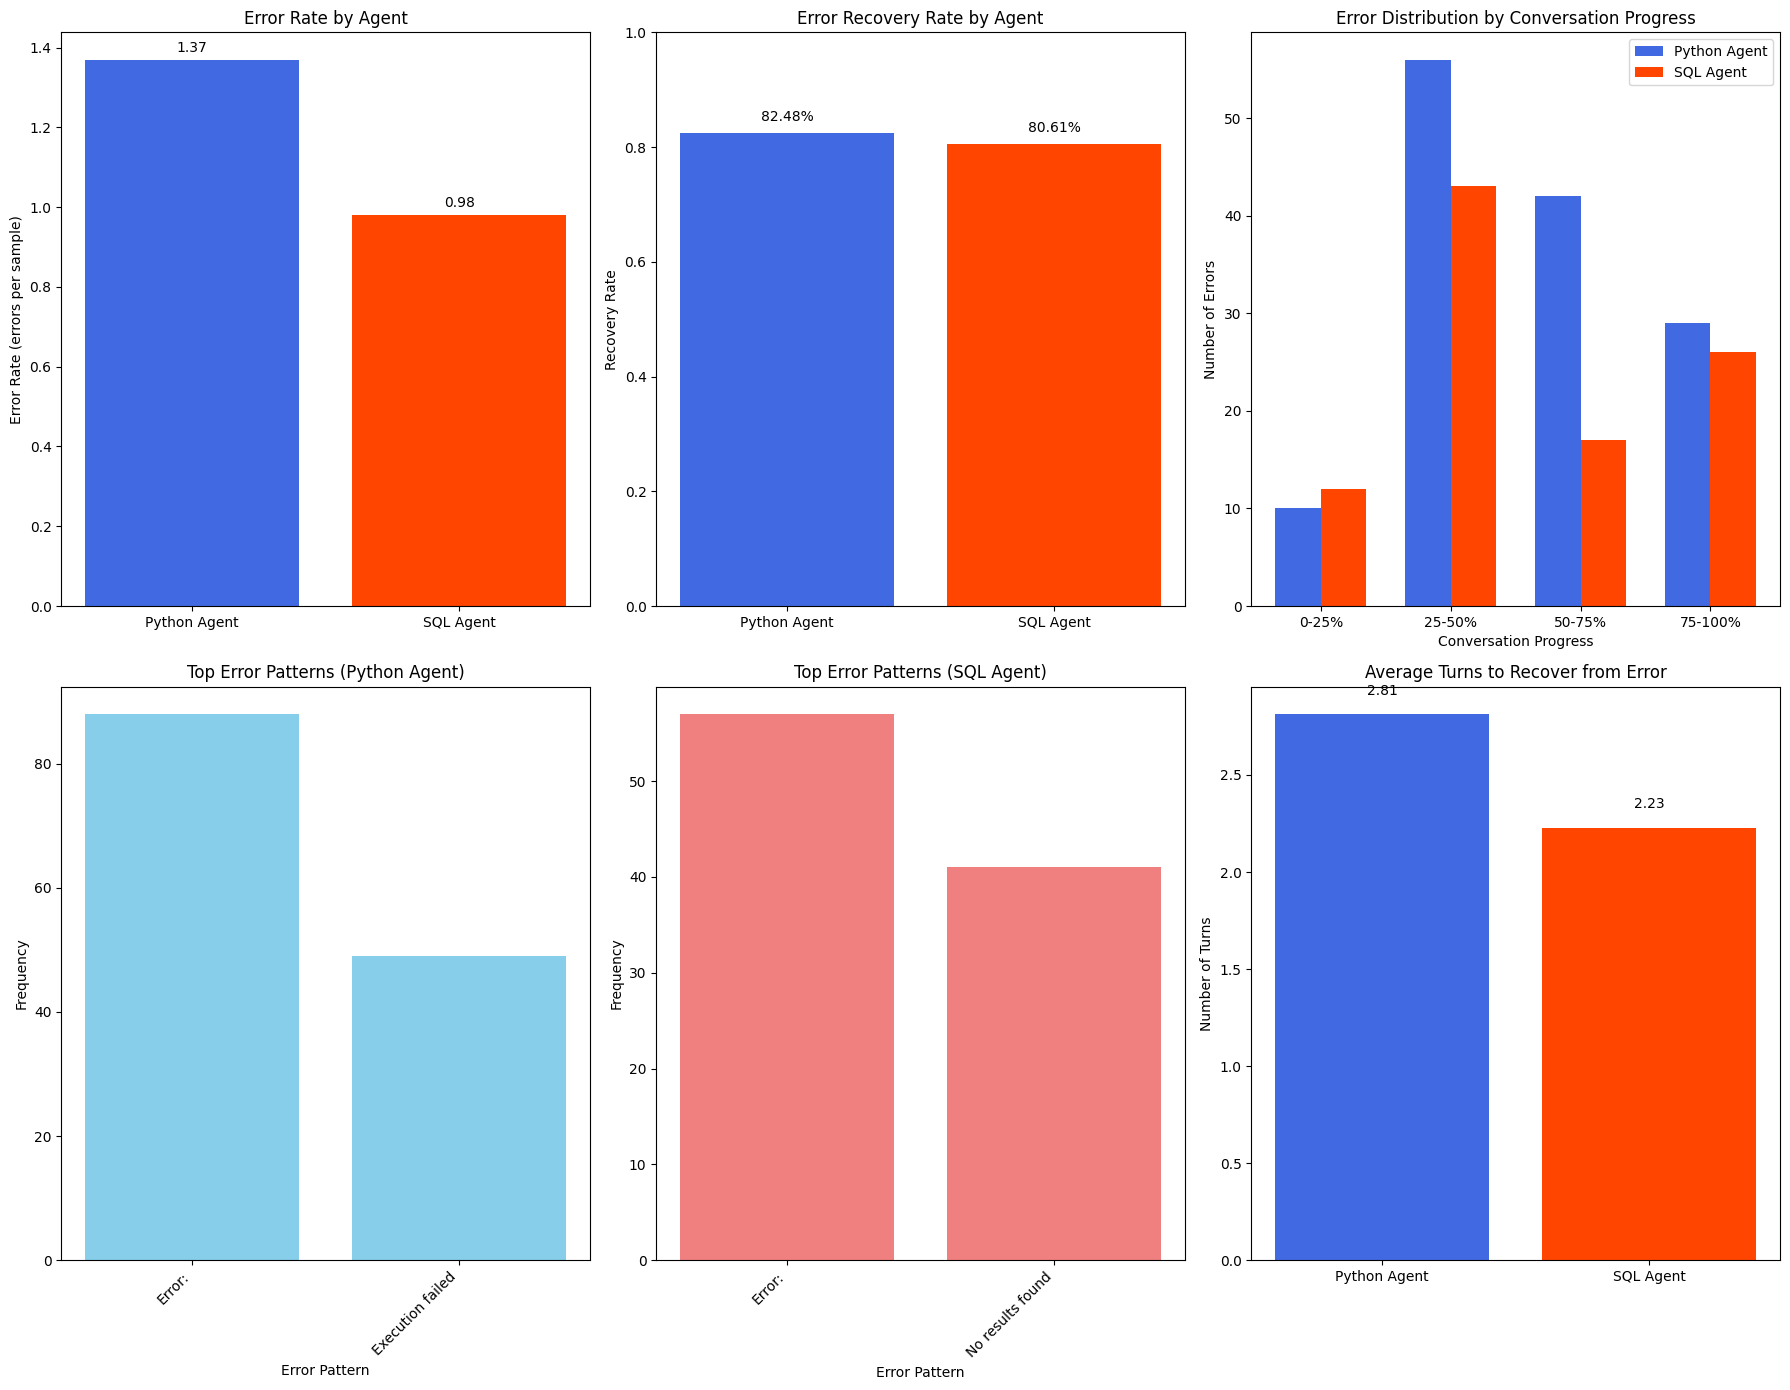


=== Agent Error Analysis ===
Python Agent: 137 errors in 100 samples (1.37 errors/sample)
SQL Agent: 98 errors in 100 samples (0.98 errors/sample)

Error Recovery Rate:
Python Agent: 82.48% (113/137)
SQL Agent: 80.61% (79/98)

Average Turns to Recover:
Python Agent: 2.81 turns
SQL Agent: 2.23 turns

Most Common Error Patterns:
Python Agent:
  - Error:: 88 occurrences
  - Execution failed: 49 occurrences

SQL Agent:
  - Error:: 57 occurrences
  - No results found: 41 occurrences

Error Distribution by Conversation Progress:
Python Agent:
  - 0-25%: 10 errors
  - 25-50%: 56 errors
  - 50-75%: 42 errors
  - 75-100%: 29 errors

SQL Agent:
  - 0-25%: 12 errors
  - 25-50%: 43 errors
  - 50-75%: 17 errors
  - 75-100%: 26 errors

Error Rate in Successful vs Failed Samples:
Python Agent:
  - Successful samples: 1.04 errors/sample (48 errors in 46 samples)
  - Failed samples: 1.65 errors/sample (89 errors in 54 samples)

SQL Agent:
  - Successful samples: 0.74 errors/sample (34 errors in 46 sam

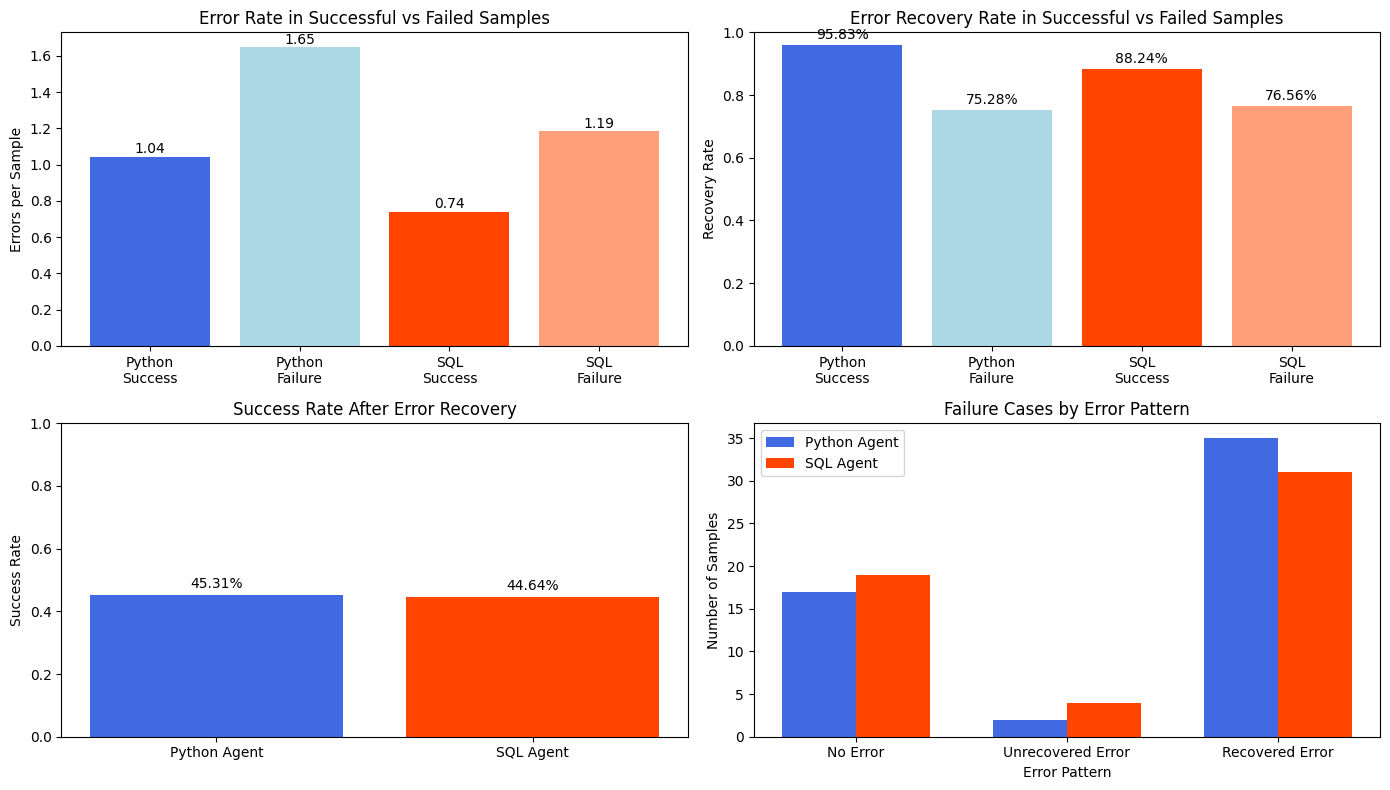


=== Error Analysis Conclusion ===

Error Recovery and Success Correlation:
Python Agent:
  - Samples with errors: 67/100 (67.00%)
  - Samples with successful error recovery: 64/67 (95.52% of error cases)
  - Success rate after error recovery: 45.31% (29/64)

SQL Agent:
  - Samples with errors: 61/100 (61.00%)
  - Samples with successful error recovery: 56/61 (91.80% of error cases)
  - Success rate after error recovery: 44.64% (25/56)

Failure Patterns:
Python Agent:
  - Failures without errors: 17/54 (31.48% of failures)
  - Failures due to unrecovered errors: 2/54 (3.70% of failures)
  - Failures despite error recovery: 35/54 (64.81% of failures)

SQL Agent:
  - Failures without errors: 19/54 (35.19% of failures)
  - Failures due to unrecovered errors: 4/54 (7.41% of failures)
  - Failures despite error recovery: 31/54 (57.41% of failures)


In [30]:
# 에이전트 에러 분석을 위한 함수
import re
from collections import Counter, defaultdict

def extract_errors_from_history(history):
    """
    대화 히스토리에서 에러 메시지 추출
    """
    errors = []
    for i, turn in enumerate(history):
        # 도구 응답(tool-response)에서 에러 찾기
        if turn.get('role') == 'tool-response':
            content = turn.get('content', [])
            if isinstance(content, list):
                for item in content:
                    if isinstance(item, dict) and 'text' in item:
                        text = item['text']
                        
                        # 에러 패턴 확인
                        error_patterns = [
                            r"Error:", 
                            r"Execution failed", 
                            r"Exception:", 
                            r"syntax error", 
                            r"no such table", 
                            r"near \".*\": syntax error",
                            r"No results found"
                        ]
                        
                        for pattern in error_patterns:
                            if re.search(pattern, text, re.IGNORECASE):
                                # 에러 정보 저장
                                errors.append({
                                    'turn_index': i,
                                    'error_text': text,
                                    'error_pattern': pattern
                                })
                                break
    
    return errors

def check_error_recovery(history, errors):
    """
    에러 발생 후 복구 여부 확인
    """
    recovery_info = []
    
    for error in errors:
        turn_index = error['turn_index']
        
        # 에러 발생 후 성공적인 도구 호출 확인
        recovered = False
        recovery_turn = None
        
        for i in range(turn_index + 1, len(history)):
            if history[i].get('role') == 'tool-response':
                content = history[i].get('content', [])
                if isinstance(content, list):
                    for item in content:
                        if isinstance(item, dict) and 'text' in item:
                            text = item['text']
                            
                            # 에러가 아닌 응답 (성공적인 복구)
                            error_detected = any(re.search(pattern, text, re.IGNORECASE) for pattern in [
                                r"Error:", r"Execution failed", r"Exception:", r"syntax error"
                            ])
                            
                            if not error_detected and "Observation:" in text:
                                recovered = True
                                recovery_turn = i - turn_index
                                break
                
                if recovered:
                    break
        
        recovery_info.append({
            'error_turn': turn_index,
            'recovered': recovered,
            'recovery_turns': recovery_turn
        })
    
    return recovery_info

def analyze_agent_errors(python_data, sql_data):
    """
    Python 및 SQL 에이전트의 에러 발생 패턴 분석
    """
    python_all_errors = []
    sql_all_errors = []
    python_all_recoveries = []
    sql_all_recoveries = []
    
    # 각 샘플에 대한 에러 분석
    for entry in python_data.get('evaluation_history', []):
        history = entry.get('history', [])
        sample_id = entry.get('id', '')
        
        # 에러 추출
        errors = extract_errors_from_history(history)
        for error in errors:
            error['sample_id'] = sample_id
            error['total_turns'] = len(history)
        
        python_all_errors.extend(errors)
        
        # 에러 복구 분석
        recoveries = check_error_recovery(history, errors)
        for recovery in recoveries:
            recovery['sample_id'] = sample_id
            recovery['total_turns'] = len(history)
        
        python_all_recoveries.extend(recoveries)
    
    # SQL 에이전트 에러 분석
    for entry in sql_data.get('evaluation_history', []):
        history = entry.get('history', [])
        sample_id = entry.get('id', '')
        
        # 에러 추출
        errors = extract_errors_from_history(history)
        for error in errors:
            error['sample_id'] = sample_id
            error['total_turns'] = len(history)
        
        sql_all_errors.extend(errors)
        
        # 에러 복구 분석
        recoveries = check_error_recovery(history, errors)
        for recovery in recoveries:
            recovery['sample_id'] = sample_id
            recovery['total_turns'] = len(history)
        
        sql_all_recoveries.extend(recoveries)
    
    # 에러 빈도 및 패턴 분석
    python_error_count = len(python_all_errors)
    sql_error_count = len(sql_all_errors)
    
    python_samples = len(python_data.get('evaluation_history', []))
    sql_samples = len(sql_data.get('evaluation_history', []))
    
    python_error_rate = python_error_count / python_samples if python_samples > 0 else 0
    sql_error_rate = sql_error_count / sql_samples if sql_samples > 0 else 0
    
    # 에러 패턴 분석
    python_error_patterns = Counter([e['error_pattern'] for e in python_all_errors])
    sql_error_patterns = Counter([e['error_pattern'] for e in sql_all_errors])
    
    # 턴별 에러 발생 빈도
    python_error_by_turn = defaultdict(int)
    sql_error_by_turn = defaultdict(int)
    
    for error in python_all_errors:
        # 상대적 턴 위치 (전체 턴의 몇 % 지점에서 발생)
        rel_position = error['turn_index'] / error['total_turns'] if error['total_turns'] > 0 else 0
        # 0-25%, 25-50%, 50-75%, 75-100%로 구간화
        position_bucket = int(rel_position * 4)
        python_error_by_turn[position_bucket] += 1
    
    for error in sql_all_errors:
        rel_position = error['turn_index'] / error['total_turns'] if error['total_turns'] > 0 else 0
        position_bucket = int(rel_position * 4)
        sql_error_by_turn[position_bucket] += 1
    
    # 에러 복구율
    python_recovered = sum(1 for r in python_all_recoveries if r['recovered'])
    sql_recovered = sum(1 for r in sql_all_recoveries if r['recovered'])
    
    python_recovery_rate = python_recovered / python_error_count if python_error_count > 0 else 0
    sql_recovery_rate = sql_recovered / sql_error_count if sql_error_count > 0 else 0
    
    # 복구에 필요한 평균 턴 수
    python_recovery_turns = [r['recovery_turns'] for r in python_all_recoveries if r['recovered'] and r['recovery_turns'] is not None]
    sql_recovery_turns = [r['recovery_turns'] for r in sql_all_recoveries if r['recovered'] and r['recovery_turns'] is not None]
    
    python_avg_recovery_turns = sum(python_recovery_turns) / len(python_recovery_turns) if python_recovery_turns else 0
    sql_avg_recovery_turns = sum(sql_recovery_turns) / len(sql_recovery_turns) if sql_recovery_turns else 0
    
    # 결과 시각화
    plt.figure(figsize=(18, 14))
    
    # 1. 에러 발생률 비교
    plt.subplot(2, 3, 1)
    error_rates = [python_error_rate, sql_error_rate]
    labels = ['Python Agent', 'SQL Agent']
    colors = ['royalblue', 'orangered']
    
    plt.bar(labels, error_rates, color=colors)
    plt.title('Error Rate by Agent')
    plt.ylabel('Error Rate (errors per sample)')
    
    # 값 표시
    for i, v in enumerate(error_rates):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    
    # 2. 에러 복구율 비교
    plt.subplot(2, 3, 2)
    recovery_rates = [python_recovery_rate, sql_recovery_rate]
    
    plt.bar(labels, recovery_rates, color=colors)
    plt.title('Error Recovery Rate by Agent')
    plt.ylabel('Recovery Rate')
    plt.ylim(0, 1)
    
    # 값 표시
    for i, v in enumerate(recovery_rates):
        plt.text(i, v + 0.02, f"{v:.2%}", ha='center')
    
    # 3. 에러 발생 시점 분포
    plt.subplot(2, 3, 3)
    turn_buckets = ['0-25%', '25-50%', '50-75%', '75-100%']
    
    python_turn_dist = [python_error_by_turn.get(i, 0) for i in range(4)]
    sql_turn_dist = [sql_error_by_turn.get(i, 0) for i in range(4)]
    
    x = range(len(turn_buckets))
    width = 0.35
    
    plt.bar([i - width/2 for i in x], python_turn_dist, width, label='Python Agent', color='royalblue')
    plt.bar([i + width/2 for i in x], sql_turn_dist, width, label='SQL Agent', color='orangered')
    
    plt.title('Error Distribution by Conversation Progress')
    plt.xlabel('Conversation Progress')
    plt.ylabel('Number of Errors')
    plt.xticks(x, turn_buckets)
    plt.legend()
    
    # 4. 에러 패턴 분포 (Python)
    plt.subplot(2, 3, 4)
    
    if python_error_patterns:
        # 상위 5개 에러 패턴만 표시
        top_patterns = dict(python_error_patterns.most_common(5))
        pattern_labels = [p[:20] + '...' if len(p) > 20 else p for p in top_patterns.keys()]
        
        plt.bar(pattern_labels, top_patterns.values(), color='skyblue')
        plt.title('Top Error Patterns (Python Agent)')
        plt.xlabel('Error Pattern')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
    else:
        plt.text(0.5, 0.5, 'No errors found', ha='center', va='center')
        plt.title('Error Patterns (Python Agent)')
    
    # 5. 에러 패턴 분포 (SQL)
    plt.subplot(2, 3, 5)
    
    if sql_error_patterns:
        # 상위 5개 에러 패턴만 표시
        top_patterns = dict(sql_error_patterns.most_common(5))
        pattern_labels = [p[:20] + '...' if len(p) > 20 else p for p in top_patterns.keys()]
        
        plt.bar(pattern_labels, top_patterns.values(), color='lightcoral')
        plt.title('Top Error Patterns (SQL Agent)')
        plt.xlabel('Error Pattern')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
    else:
        plt.text(0.5, 0.5, 'No errors found', ha='center', va='center')
        plt.title('Error Patterns (SQL Agent)')
    
    # 6. 복구에 필요한 평균 턴 수
    plt.subplot(2, 3, 6)
    avg_turns = [python_avg_recovery_turns, sql_avg_recovery_turns]
    
    plt.bar(labels, avg_turns, color=colors)
    plt.title('Average Turns to Recover from Error')
    plt.ylabel('Number of Turns')
    
    # 값 표시
    for i, v in enumerate(avg_turns):
        plt.text(i, v + 0.1, f"{v:.2f}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # 추가 분석: 에러와 성공률의 관계
    print("\n=== Agent Error Analysis ===")
    print(f"Python Agent: {python_error_count} errors in {python_samples} samples ({python_error_rate:.2f} errors/sample)")
    print(f"SQL Agent: {sql_error_count} errors in {sql_samples} samples ({sql_error_rate:.2f} errors/sample)")
    
    print(f"\nError Recovery Rate:")
    print(f"Python Agent: {python_recovery_rate:.2%} ({python_recovered}/{python_error_count})")
    print(f"SQL Agent: {sql_recovery_rate:.2%} ({sql_recovered}/{sql_error_count})")
    
    print(f"\nAverage Turns to Recover:")
    print(f"Python Agent: {python_avg_recovery_turns:.2f} turns")
    print(f"SQL Agent: {sql_avg_recovery_turns:.2f} turns")
    
    print("\nMost Common Error Patterns:")
    print("Python Agent:")
    for pattern, count in python_error_patterns.most_common(5):
        print(f"  - {pattern}: {count} occurrences")
    
    print("\nSQL Agent:")
    for pattern, count in sql_error_patterns.most_common(5):
        print(f"  - {pattern}: {count} occurrences")
    
    print("\nError Distribution by Conversation Progress:")
    print("Python Agent:")
    for i, bucket in enumerate(turn_buckets):
        print(f"  - {bucket}: {python_error_by_turn.get(i, 0)} errors")
    
    print("\nSQL Agent:")
    for i, bucket in enumerate(turn_buckets):
        print(f"  - {bucket}: {sql_error_by_turn.get(i, 0)} errors")
    
    # 성공/실패 샘플에서의 에러 발생 패턴 (Python 에이전트)
    python_success_samples = set(entry.get('id') for entry in python_data.get('evaluation_history', []) 
                               if entry.get('sample_metrics', {}).get('llm_match', False))
    
    python_success_errors = sum(1 for e in python_all_errors if e['sample_id'] in python_success_samples)
    python_failure_errors = python_error_count - python_success_errors
    
    python_success_samples_count = len(python_success_samples)
    python_failure_samples_count = python_samples - python_success_samples_count
    
    python_success_error_rate = python_success_errors / python_success_samples_count if python_success_samples_count > 0 else 0
    python_failure_error_rate = python_failure_errors / python_failure_samples_count if python_failure_samples_count > 0 else 0
    
    # 성공/실패 샘플에서의 에러 발생 패턴 (SQL 에이전트)
    sql_success_samples = set(entry.get('id') for entry in sql_data.get('evaluation_history', []) 
                            if entry.get('sample_metrics', {}).get('llm_match', False))
    
    sql_success_errors = sum(1 for e in sql_all_errors if e['sample_id'] in sql_success_samples)
    sql_failure_errors = sql_error_count - sql_success_errors
    
    sql_success_samples_count = len(sql_success_samples)
    sql_failure_samples_count = sql_samples - sql_success_samples_count
    
    sql_success_error_rate = sql_success_errors / sql_success_samples_count if sql_success_samples_count > 0 else 0
    sql_failure_error_rate = sql_failure_errors / sql_failure_samples_count if sql_failure_samples_count > 0 else 0
    
    print("\nError Rate in Successful vs Failed Samples:")
    print(f"Python Agent:")
    print(f"  - Successful samples: {python_success_error_rate:.2f} errors/sample ({python_success_errors} errors in {python_success_samples_count} samples)")
    print(f"  - Failed samples: {python_failure_error_rate:.2f} errors/sample ({python_failure_errors} errors in {python_failure_samples_count} samples)")
    
    print(f"\nSQL Agent:")
    print(f"  - Successful samples: {sql_success_error_rate:.2f} errors/sample ({sql_success_errors} errors in {sql_success_samples_count} samples)")
    print(f"  - Failed samples: {sql_failure_error_rate:.2f} errors/sample ({sql_failure_errors} errors in {sql_failure_samples_count} samples)")
    
    # 성공/실패 샘플에서의 에러 복구율 비교
    python_success_recoveries = [r for r in python_all_recoveries if r['sample_id'] in python_success_samples and r['recovered']]
    python_failure_recoveries = [r for r in python_all_recoveries if r['sample_id'] not in python_success_samples and r['recovered']]
    
    python_success_recovery_rate = len(python_success_recoveries) / python_success_errors if python_success_errors > 0 else 0
    python_failure_recovery_rate = len(python_failure_recoveries) / python_failure_errors if python_failure_errors > 0 else 0
    
    sql_success_recoveries = [r for r in sql_all_recoveries if r['sample_id'] in sql_success_samples and r['recovered']]
    sql_failure_recoveries = [r for r in sql_all_recoveries if r['sample_id'] not in sql_success_samples and r['recovered']]
    
    sql_success_recovery_rate = len(sql_success_recoveries) / sql_success_errors if sql_success_errors > 0 else 0
    sql_failure_recovery_rate = len(sql_failure_recoveries) / sql_failure_errors if sql_failure_errors > 0 else 0
    
    print("\nError Recovery Rate in Successful vs Failed Samples:")
    print(f"Python Agent:")
    print(f"  - Successful samples: {python_success_recovery_rate:.2%}")
    print(f"  - Failed samples: {python_failure_recovery_rate:.2%}")
    
    print(f"\nSQL Agent:")
    print(f"  - Successful samples: {sql_success_recovery_rate:.2%}")
    print(f"  - Failed samples: {sql_failure_recovery_rate:.2%}")
    
    # 추가 시각화: 성공/실패 샘플의 에러 발생 및 복구 패턴
    plt.figure(figsize=(14, 8))
    
    # 1. 성공/실패 샘플에서의 에러율 비교
    plt.subplot(2, 2, 1)
    
    labels = ['Python\nSuccess', 'Python\nFailure', 'SQL\nSuccess', 'SQL\nFailure']
    error_rates = [python_success_error_rate, python_failure_error_rate, sql_success_error_rate, sql_failure_error_rate]
    colors = ['royalblue', 'lightblue', 'orangered', 'lightsalmon']
    
    plt.bar(labels, error_rates, color=colors)
    plt.title('Error Rate in Successful vs Failed Samples')
    plt.ylabel('Errors per Sample')
    
    # 값 표시
    for i, v in enumerate(error_rates):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    
    # 2. 성공/실패 샘플에서의 에러 복구율 비교
    plt.subplot(2, 2, 2)
    
    recovery_rates = [python_success_recovery_rate, python_failure_recovery_rate, sql_success_recovery_rate, sql_failure_recovery_rate]
    
    plt.bar(labels, recovery_rates, color=colors)
    plt.title('Error Recovery Rate in Successful vs Failed Samples')
    plt.ylabel('Recovery Rate')
    plt.ylim(0, 1)
    
    # 값 표시
    for i, v in enumerate(recovery_rates):
        plt.text(i, v + 0.02, f"{v:.2%}", ha='center')
    
    # 3. 에러 복구와 최종 성공의 상관관계
    plt.subplot(2, 2, 3)
    
    # Python 에이전트
    python_samples_with_errors = len(set(e['sample_id'] for e in python_all_errors))
    python_samples_with_recovery = len(set(r['sample_id'] for r in python_all_recoveries if r['recovered']))
    python_successful_recovered = len(set(r['sample_id'] for r in python_all_recoveries if r['recovered'] and r['sample_id'] in python_success_samples))
    
    python_recovery_success_rate = python_successful_recovered / python_samples_with_recovery if python_samples_with_recovery > 0 else 0
    
    # SQL 에이전트
    sql_samples_with_errors = len(set(e['sample_id'] for e in sql_all_errors))
    sql_samples_with_recovery = len(set(r['sample_id'] for r in sql_all_recoveries if r['recovered']))
    sql_successful_recovered = len(set(r['sample_id'] for r in sql_all_recoveries if r['recovered'] and r['sample_id'] in sql_success_samples))
    
    sql_recovery_success_rate = sql_successful_recovered / sql_samples_with_recovery if sql_samples_with_recovery > 0 else 0
    
    labels = ['Python Agent', 'SQL Agent']
    success_rates = [python_recovery_success_rate, sql_recovery_success_rate]
    colors = ['royalblue', 'orangered']
    
    plt.bar(labels, success_rates, color=colors)
    plt.title('Success Rate After Error Recovery')
    plt.ylabel('Success Rate')
    plt.ylim(0, 1)
    
    # 값 표시
    for i, v in enumerate(success_rates):
        plt.text(i, v + 0.02, f"{v:.2%}", ha='center')
    
    # 4. 최종 실패 원인 분석
    plt.subplot(2, 2, 4)
    
    # Python 실패 케이스 중 에러 없음, 에러 있지만 복구 실패, 에러 복구했지만 최종 실패
    python_failure_no_error = python_failure_samples_count - len(set(e['sample_id'] for e in python_all_errors if e['sample_id'] not in python_success_samples))
    python_failure_unrecovered = len(set(e['sample_id'] for e in python_all_errors if e['sample_id'] not in python_success_samples)) - len(set(r['sample_id'] for r in python_all_recoveries if r['recovered'] and r['sample_id'] not in python_success_samples))
    python_failure_recovered = len(set(r['sample_id'] for r in python_all_recoveries if r['recovered'] and r['sample_id'] not in python_success_samples))
    
    # SQL 실패 케이스 중 에러 없음, 에러 있지만 복구 실패, 에러 복구했지만 최종 실패
    sql_failure_no_error = sql_failure_samples_count - len(set(e['sample_id'] for e in sql_all_errors if e['sample_id'] not in sql_success_samples))
    sql_failure_unrecovered = len(set(e['sample_id'] for e in sql_all_errors if e['sample_id'] not in sql_success_samples)) - len(set(r['sample_id'] for r in sql_all_recoveries if r['recovered'] and r['sample_id'] not in sql_success_samples))
    sql_failure_recovered = len(set(r['sample_id'] for r in sql_all_recoveries if r['recovered'] and r['sample_id'] not in sql_success_samples))
    
    # 데이터 준비
    labels = ['No Error', 'Unrecovered Error', 'Recovered Error']
    python_failure_types = [python_failure_no_error, python_failure_unrecovered, python_failure_recovered]
    sql_failure_types = [sql_failure_no_error, sql_failure_unrecovered, sql_failure_recovered]
    
    x = range(len(labels))
    width = 0.35
    
    plt.bar([i - width/2 for i in x], python_failure_types, width, label='Python Agent', color='royalblue')
    plt.bar([i + width/2 for i in x], sql_failure_types, width, label='SQL Agent', color='orangered')
    
    plt.title('Failure Cases by Error Pattern')
    plt.xlabel('Error Pattern')
    plt.ylabel('Number of Samples')
    plt.xticks(x, labels)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 결론: 에러와 성공률의 관계
    print("\n=== Error Analysis Conclusion ===")
    
    print("\nError Recovery and Success Correlation:")
    print(f"Python Agent:")
    print(f"  - Samples with errors: {python_samples_with_errors}/{python_samples} ({python_samples_with_errors/python_samples:.2%})")
    print(f"  - Samples with successful error recovery: {python_samples_with_recovery}/{python_samples_with_errors} ({python_samples_with_recovery/python_samples_with_errors:.2%} of error cases)")
    print(f"  - Success rate after error recovery: {python_recovery_success_rate:.2%} ({python_successful_recovered}/{python_samples_with_recovery})")
    
    print(f"\nSQL Agent:")
    print(f"  - Samples with errors: {sql_samples_with_errors}/{sql_samples} ({sql_samples_with_errors/sql_samples:.2%})")
    print(f"  - Samples with successful error recovery: {sql_samples_with_recovery}/{sql_samples_with_errors} ({sql_samples_with_recovery/sql_samples_with_errors:.2%} of error cases)")
    print(f"  - Success rate after error recovery: {sql_recovery_success_rate:.2%} ({sql_successful_recovered}/{sql_samples_with_recovery})")
    
    print("\nFailure Patterns:")
    print(f"Python Agent:")
    print(f"  - Failures without errors: {python_failure_no_error}/{python_failure_samples_count} ({python_failure_no_error/python_failure_samples_count:.2%} of failures)")
    print(f"  - Failures due to unrecovered errors: {python_failure_unrecovered}/{python_failure_samples_count} ({python_failure_unrecovered/python_failure_samples_count:.2%} of failures)")
    print(f"  - Failures despite error recovery: {python_failure_recovered}/{python_failure_samples_count} ({python_failure_recovered/python_failure_samples_count:.2%} of failures)")
    
    print(f"\nSQL Agent:")
    print(f"  - Failures without errors: {sql_failure_no_error}/{sql_failure_samples_count} ({sql_failure_no_error/sql_failure_samples_count:.2%} of failures)")
    print(f"  - Failures due to unrecovered errors: {sql_failure_unrecovered}/{sql_failure_samples_count} ({sql_failure_unrecovered/sql_failure_samples_count:.2%} of failures)")
    print(f"  - Failures despite error recovery: {sql_failure_recovered}/{sql_failure_samples_count} ({sql_failure_recovered/sql_failure_samples_count:.2%} of failures)")
    
    return {
        'python_error_count': python_error_count,
        'sql_error_count': sql_error_count,
        'python_error_rate': python_error_rate,
        'sql_error_rate': sql_error_rate,
        'python_recovery_rate': python_recovery_rate,
        'sql_recovery_rate': sql_recovery_rate,
        'python_avg_recovery_turns': python_avg_recovery_turns,
        'sql_avg_recovery_turns': sql_avg_recovery_turns,
        'python_error_patterns': python_error_patterns,
        'sql_error_patterns': sql_error_patterns,
        'python_error_by_turn': dict(python_error_by_turn),
        'sql_error_by_turn': dict(sql_error_by_turn),
        'python_recovery_success_rate': python_recovery_success_rate,
        'sql_recovery_success_rate': sql_recovery_success_rate
    }

# 메인 분석 스크립트에서 이 함수를 호출
error_analysis = analyze_agent_errors(python_data, sql_data)